In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import datetime
import time

## Import Data

In [2]:
meta = pd.read_csv('../../../d11_traffic_data/meta/d11/d11_text_meta_2015_01_01.txt', sep='\t')
meta = meta[['ID', 'Fwy','District', 'Dir','Latitude', 'Longitude']]

In [3]:
raw_5_min_data = pd.read_csv('../../../five_min_frame.csv')

## Helper functions

In [4]:
def reduce_data_by_dict(_df, keyval_dict):
    for key, val in keyval_dict.iteritems():
        #print key, val
        _df = _df[_df[key] == val]
    return _df

In [17]:
def plot_freeway_heatmap(_df, _meta_redux, _title):
    freeway = _df.merge(_meta_redux, 
                              left_on=['Station', 'District','Freeway #', 'Direction'], 
                              right_on=['ID', 'District', 'Fwy', 'Dir'])
    
    freeway = freeway[freeway['% Observed'] > 95 ]
    freeway['time'] = pd.to_datetime(freeway['Timestamp'], format="%m/%d/%Y %H:%M:%S")
    freeway['timeOfDay'] = freeway['time'].apply(lambda x: x.strftime("%H:%M")) 
    freeway_metrics = freeway[['Station', 'Total Flow', 'Avg Occupancy', 'Avg Speed', 'timeOfDay', 'Latitude'] ]
    freeway_metrics['Avg Density'] = freeway_metrics['Total Flow']/freeway_metrics['Avg Speed']
    fwy_grouping = freeway_metrics[['Station', 'Total Flow', 
                                    'Avg Occupancy', 'Avg Speed', 
                                    'Avg Density', 'timeOfDay', 
                                    'Latitude'] ].groupby(['timeOfDay', 'Station']).agg(['mean','std'])
    
    metrics = fwy_grouping.reset_index()
    metrics.columns = ['time', 'Station', 'MeanTotalFlow','StdTotalFlow', 
                                                    'MeanAvgOccupancy', 'StdAvgOccupancy',
                                                    'MeanAvgSpeed', 'StdAvgSpeed', 
                                                    'MeanAvgDensity', 'StdAvgDensity',
                                                    'Latitude', 'Nothing']
    
    metrics['MeanPlusStdTotalFlow'] = metrics['MeanTotalFlow'] + metrics['StdTotalFlow']
    metrics['MeanMinusStdTotalFlow'] = metrics['MeanTotalFlow'] - metrics['StdTotalFlow']

    metrics['MeanPlusStdOccupancy'] = metrics['MeanAvgOccupancy'] + metrics['StdAvgOccupancy']
    metrics['MeanMinusStdOccupancy'] = metrics['MeanAvgOccupancy'] - metrics['StdAvgOccupancy']

    metrics['MeanPlusStdAvgSpeed'] = metrics['MeanAvgSpeed'] + metrics['StdAvgSpeed']
    metrics['MeanMinusStdAvgSpeed'] = metrics['MeanAvgSpeed'] - metrics['StdAvgSpeed']

    metrics['MeanPlusStdAvgDensity'] = metrics['MeanAvgDensity'] + metrics['StdAvgDensity']
    metrics['MeanMinusStdAvgDensity'] = metrics['MeanAvgDensity'] - metrics['StdAvgDensity']
    
    metrics = metrics[['time', 'Station', 'Latitude', 'MeanTotalFlow','MeanPlusStdTotalFlow', 'MeanMinusStdTotalFlow',
                                                    'MeanAvgOccupancy', 'MeanPlusStdOccupancy', 'MeanMinusStdOccupancy',
                                                    'MeanAvgSpeed', 'MeanPlusStdAvgSpeed', 'MeanMinusStdAvgSpeed',
                                                    'MeanAvgDensity', 'MeanPlusStdAvgDensity', 'MeanMinusStdAvgDensity',
                                                    ]].sort_values(['Latitude', 'time'])
    metrics['Latitude']  = metrics['Latitude'].apply(lambda x: round(x,5))

    # Set up the matplotlib figure
    f, axes = plt.subplots(3, 3, figsize=(20, 50), sharey=True)
    
    
    sns.despine(left=True)

    sns.set(context="paper", font="monospace")
    cmap = sns.diverging_palette(h_neg=0, h_pos=240, s=99, l=10,as_cmap=True, center='light')
    sns.heatmap(metrics[['Latitude', 'time', 'MeanAvgSpeed']].pivot("Latitude", "time","MeanAvgSpeed" ), vmin=metrics['MeanPlusStdAvgSpeed'].min(), vmax=metrics['MeanAvgSpeed'].max(), ax=axes[0, 0], cmap=cmap, cbar=False, xticklabels=12)
    axes[0, 0].set_title('Speed Mean')
    sns.heatmap(metrics[['Latitude', 'time', 'MeanPlusStdAvgSpeed']].pivot("Latitude", "time","MeanPlusStdAvgSpeed" ),vmin=metrics['MeanPlusStdAvgSpeed'].min(), vmax=metrics['MeanAvgSpeed'].max(), ax=axes[2, 0], cmap=cmap, cbar=False, xticklabels=12)
    axes[2, 0].set_title('Speed Mean+Std')
    sns.heatmap(metrics[['Latitude', 'time', 'MeanMinusStdAvgSpeed']].pivot("Latitude", "time","MeanMinusStdAvgSpeed" ), vmin=metrics['MeanPlusStdAvgSpeed'].min(), vmax=metrics['MeanAvgSpeed'].max(), ax=axes[1, 0], cmap=cmap, cbar=False, xticklabels=12)
    axes[1, 0].set_title('Speed Mean-Std')
    
    cmap = sns.diverging_palette(h_neg=100, h_pos=240, s=99, l=50,as_cmap=True, center='light')
    sns.heatmap(metrics[['Latitude', 'time', 'MeanTotalFlow']].pivot("Latitude", "time","MeanTotalFlow" ), vmin=metrics['MeanMinusStdTotalFlow'].mean(), vmax=metrics['MeanTotalFlow'].max(), ax=axes[0, 1], cmap=cmap, cbar=False, xticklabels=12)
    axes[0, 1].set_title('Flow Mean')
    sns.heatmap(metrics[['Latitude', 'time', 'MeanPlusStdTotalFlow']].pivot("Latitude", "time","MeanPlusStdTotalFlow" ), vmin=metrics['MeanMinusStdTotalFlow'].mean(), vmax=metrics['MeanTotalFlow'].max(), ax=axes[1, 1], cmap=cmap, cbar=False, xticklabels=12)
    axes[1, 1].set_title('Flow Mean+Std')
    sns.heatmap(metrics[['Latitude', 'time', 'MeanMinusStdTotalFlow']].pivot("Latitude", "time","MeanMinusStdTotalFlow" ), vmin=metrics['MeanMinusStdTotalFlow'].mean(), vmax=metrics['MeanTotalFlow'].max(), ax=axes[2, 1], cmap=cmap, cbar=False, xticklabels=12)
    axes[2, 1].set_title('Flow Mean-Std')

    cmap = sns.diverging_palette(h_neg=0, h_pos=200, s=45, l=40, as_cmap=True, center='light')
    sns.heatmap(metrics[['Latitude', 'time', 'MeanAvgOccupancy']].pivot("Latitude", "time","MeanAvgOccupancy" ), vmin=metrics['MeanMinusStdOccupancy'].mean(), vmax=metrics['MeanAvgOccupancy'].max(), ax=axes[0, 2], cmap=cmap, cbar=False, xticklabels=12)
    axes[0, 2].set_title('Occupancy Mean')
    sns.heatmap(metrics[['Latitude', 'time', 'MeanPlusStdOccupancy']].pivot("Latitude", "time","MeanPlusStdOccupancy" ), vmin=metrics['MeanMinusStdOccupancy'].mean(), vmax=metrics['MeanAvgOccupancy'].max(), ax=axes[1, 2], cmap=cmap, cbar=False, xticklabels=12)
    axes[1, 2].set_title('Occupancy Mean+Std')
    sns.heatmap(metrics[['Latitude', 'time', 'MeanMinusStdOccupancy']].pivot("Latitude", "time","MeanMinusStdOccupancy" ), vmin=metrics['MeanMinusStdOccupancy'].mean(), vmax=metrics['MeanAvgOccupancy'].max(), ax=axes[2, 2], cmap=cmap, cbar=False, xticklabels=12)
    axes[2, 2].set_title('Occupancy Mean-Std')

    plt.title(_title)
    #cmap = sns.diverging_palette(h_neg=0, h_pos=200, s=45, l=40, as_cmap=True, center='light')
    #sns.heatmap(metrics[['Latitude', 'time', 'MeanAvgDensity']].pivot("Latitude", "time","MeanAvgDensity" ), vmin=metrics['MeanMinusStdAvgDensity'].mean(), vmax=metrics['MeanAvgDensity'].max(), ax=axes[0, 3], cmap=cmap, cbar=False,xticklabels=12)
    #sns.heatmap(metrics[['Latitude', 'time', 'MeanPlusStdAvgDensity']].pivot("Latitude", "time","MeanPlusStdAvgDensity" ), vmin=metrics['MeanMinusStdAvgDensity'].mean(), vmax=metrics['MeanAvgDensity'].max(), ax=axes[1, 3], cmap=cmap, cbar=False, xticklabels=12)
    #sns.heatmap(metrics[['Latitude', 'time', 'MeanMinusStdAvgDensity']].pivot("Latitude", "time","MeanMinusStdAvgDensity" ), vmin=metrics['MeanMinusStdAvgDensity'].mean(), vmax=metrics['MeanAvgDensity'].max(), ax=axes[2, 3], cmap=cmap, cbar=False, xticklabels=12)
    
    return metrics

# Statistics for I5S

/Users/mikihardisty/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


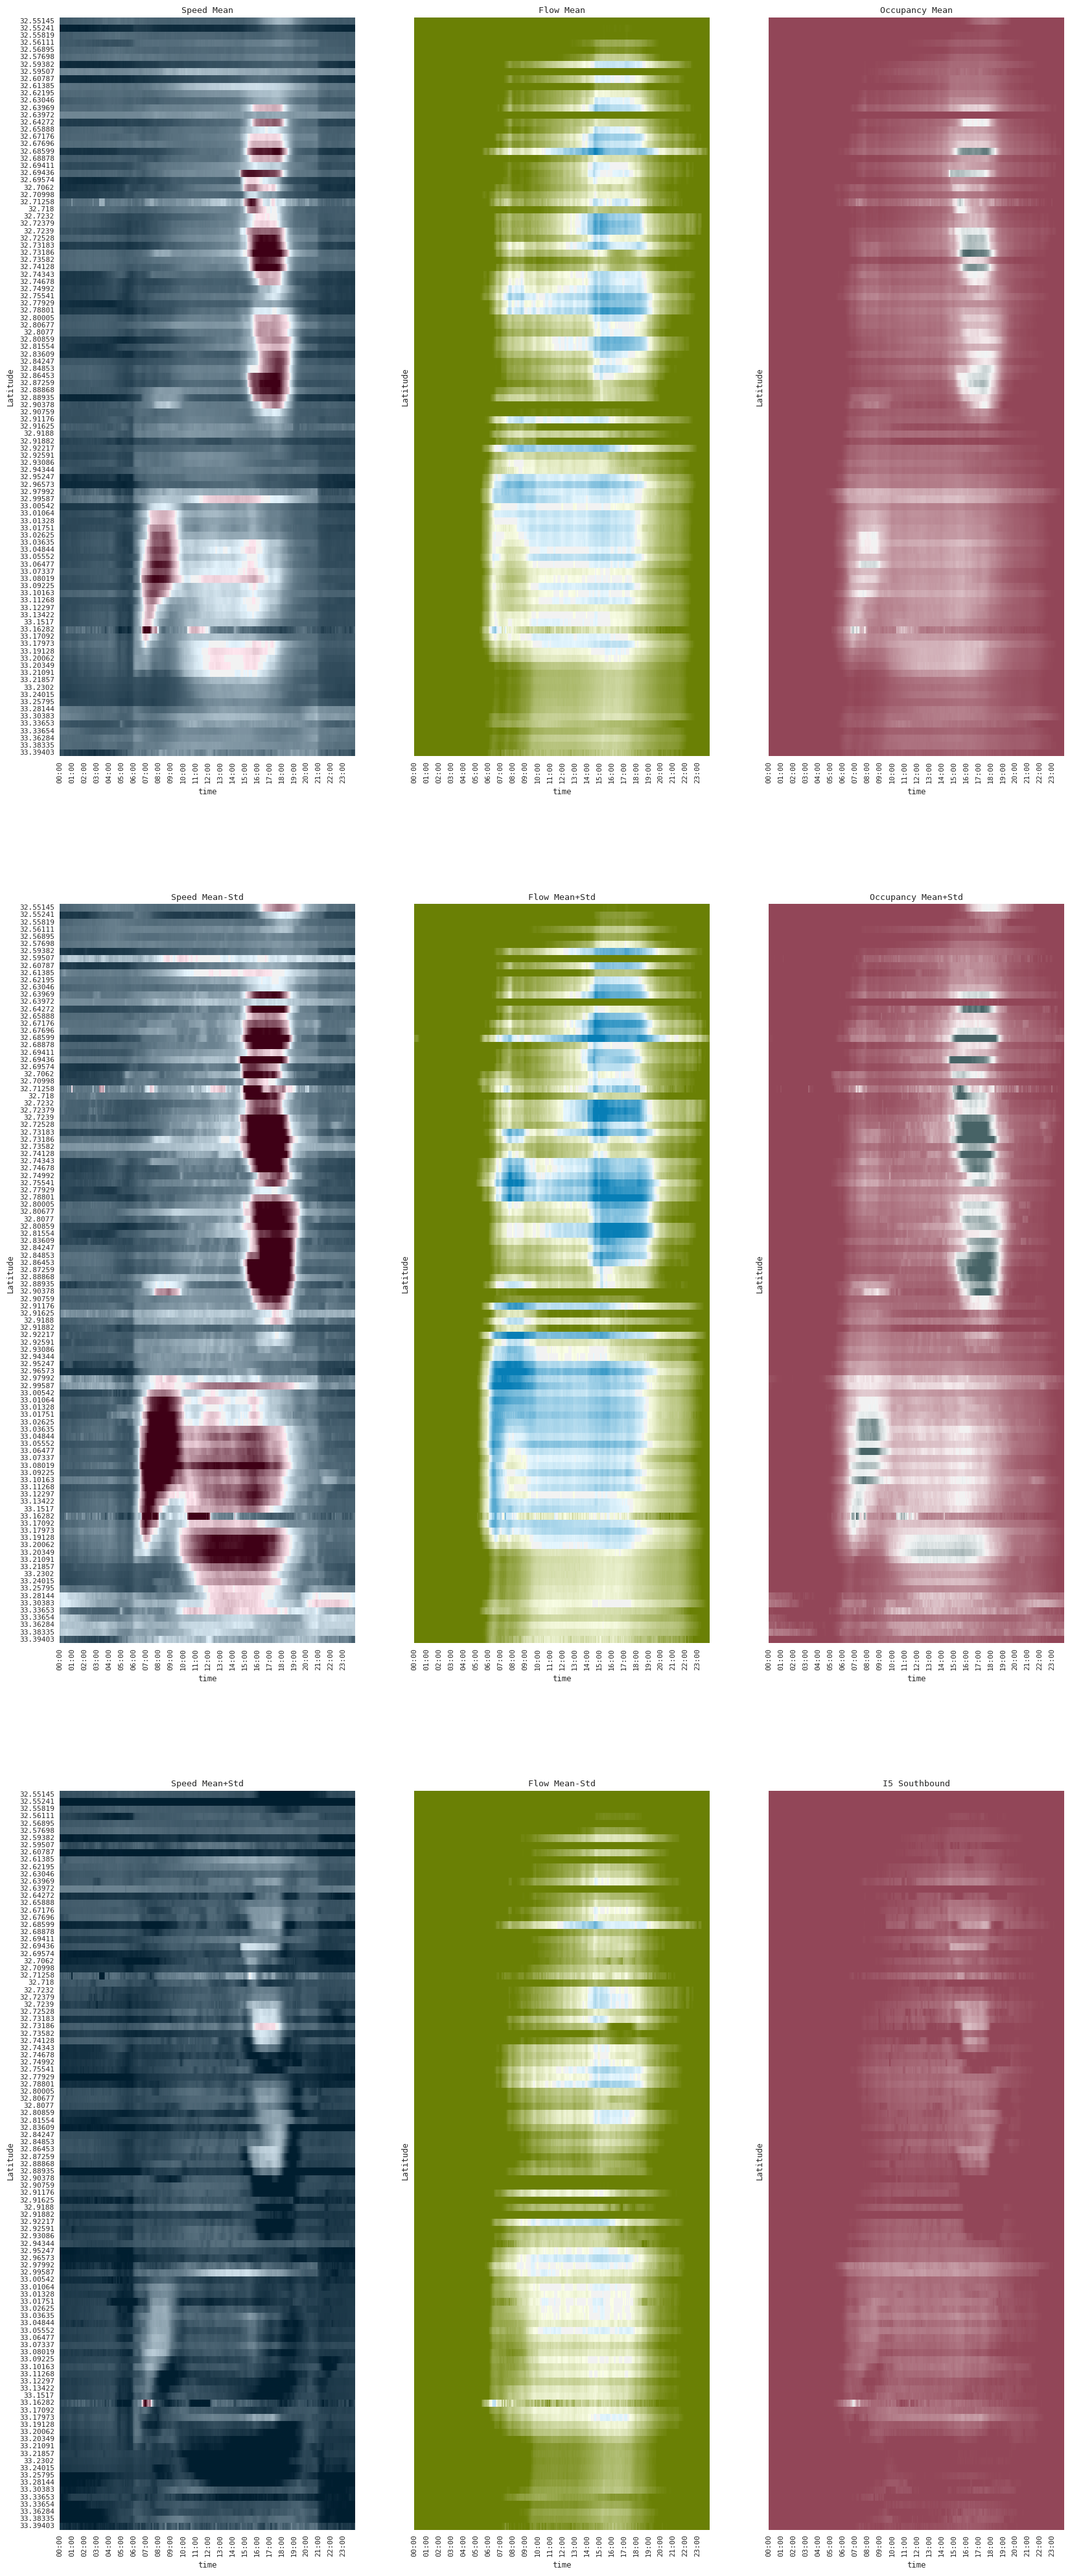

In [19]:
keyval_dict = {"District": 11, "Freeway #":5,  "Lane Type": 'ML', "Direction": 'S'} 
freeway_redux = reduce_data_by_dict(raw_5_min_data, keyval_dict)

meta_dict= {"District": 11, "Fwy": 5,  "Dir": 'S'}
meta_redux = reduce_data_by_dict(meta, meta_dict)

i5S = plot_freeway_heatmap(freeway_redux, meta_redux, "I5 Southbound")

# Statistics for 56 West

/Users/mikihardisty/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


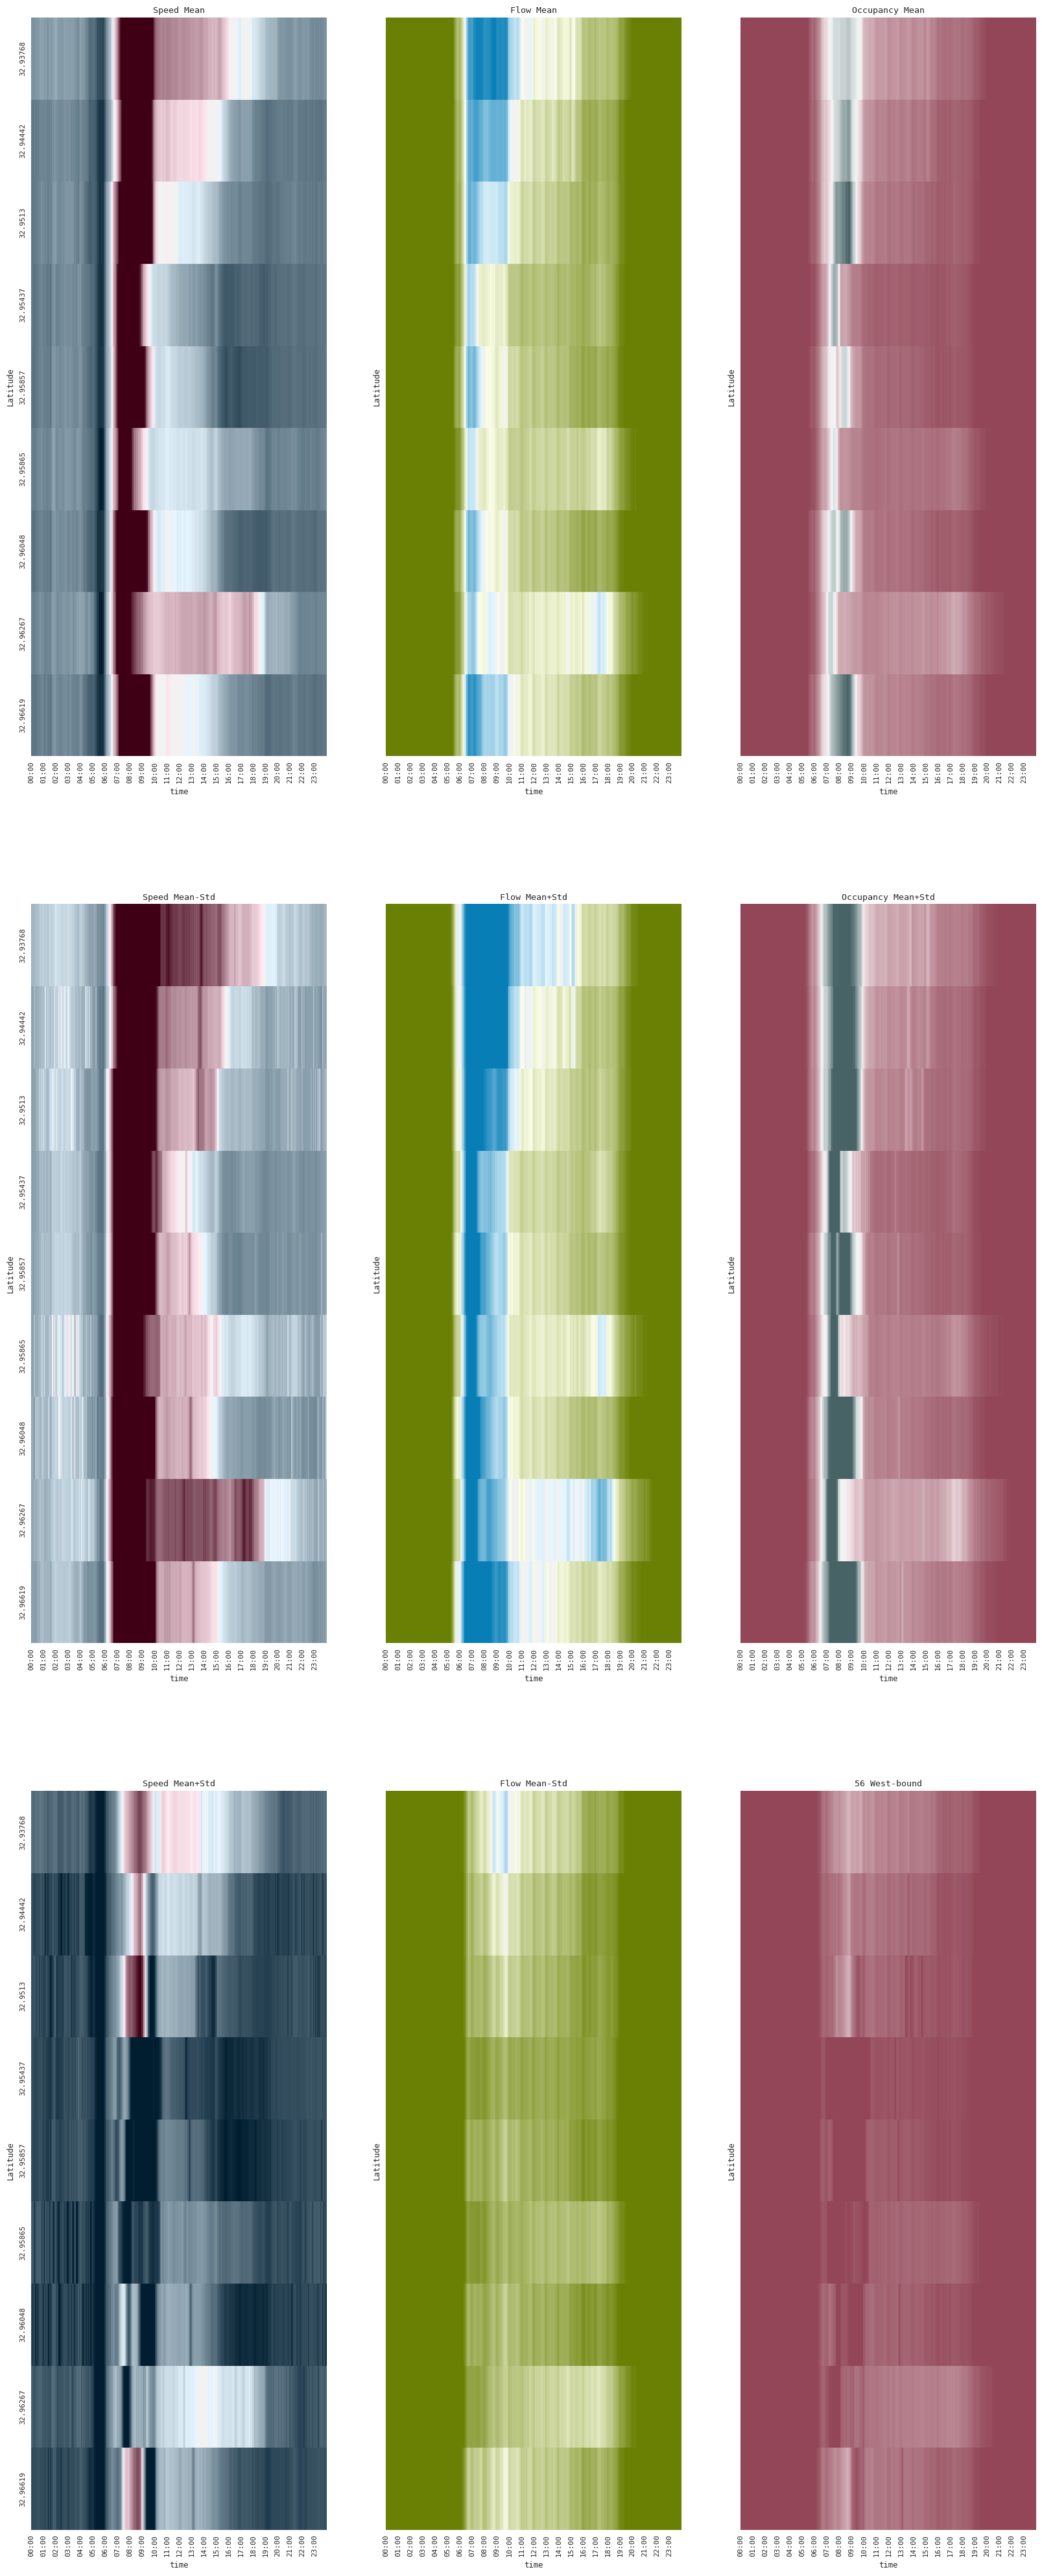

In [20]:
keyval_dict = {"District": 11, "Freeway #":56,  "Lane Type": 'ML', "Direction": 'W'} 
freeway_redux = reduce_data_by_dict(raw_5_min_data, keyval_dict)

meta_dict= {"District": 11, "Fwy": 56,  "Dir": 'W'}
meta_redux = reduce_data_by_dict(meta, meta_dict)

i5S = plot_freeway_heatmap(freeway_redux, meta_redux, "56 West-bound")

# Statistics for 56 East

/Users/mikihardisty/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


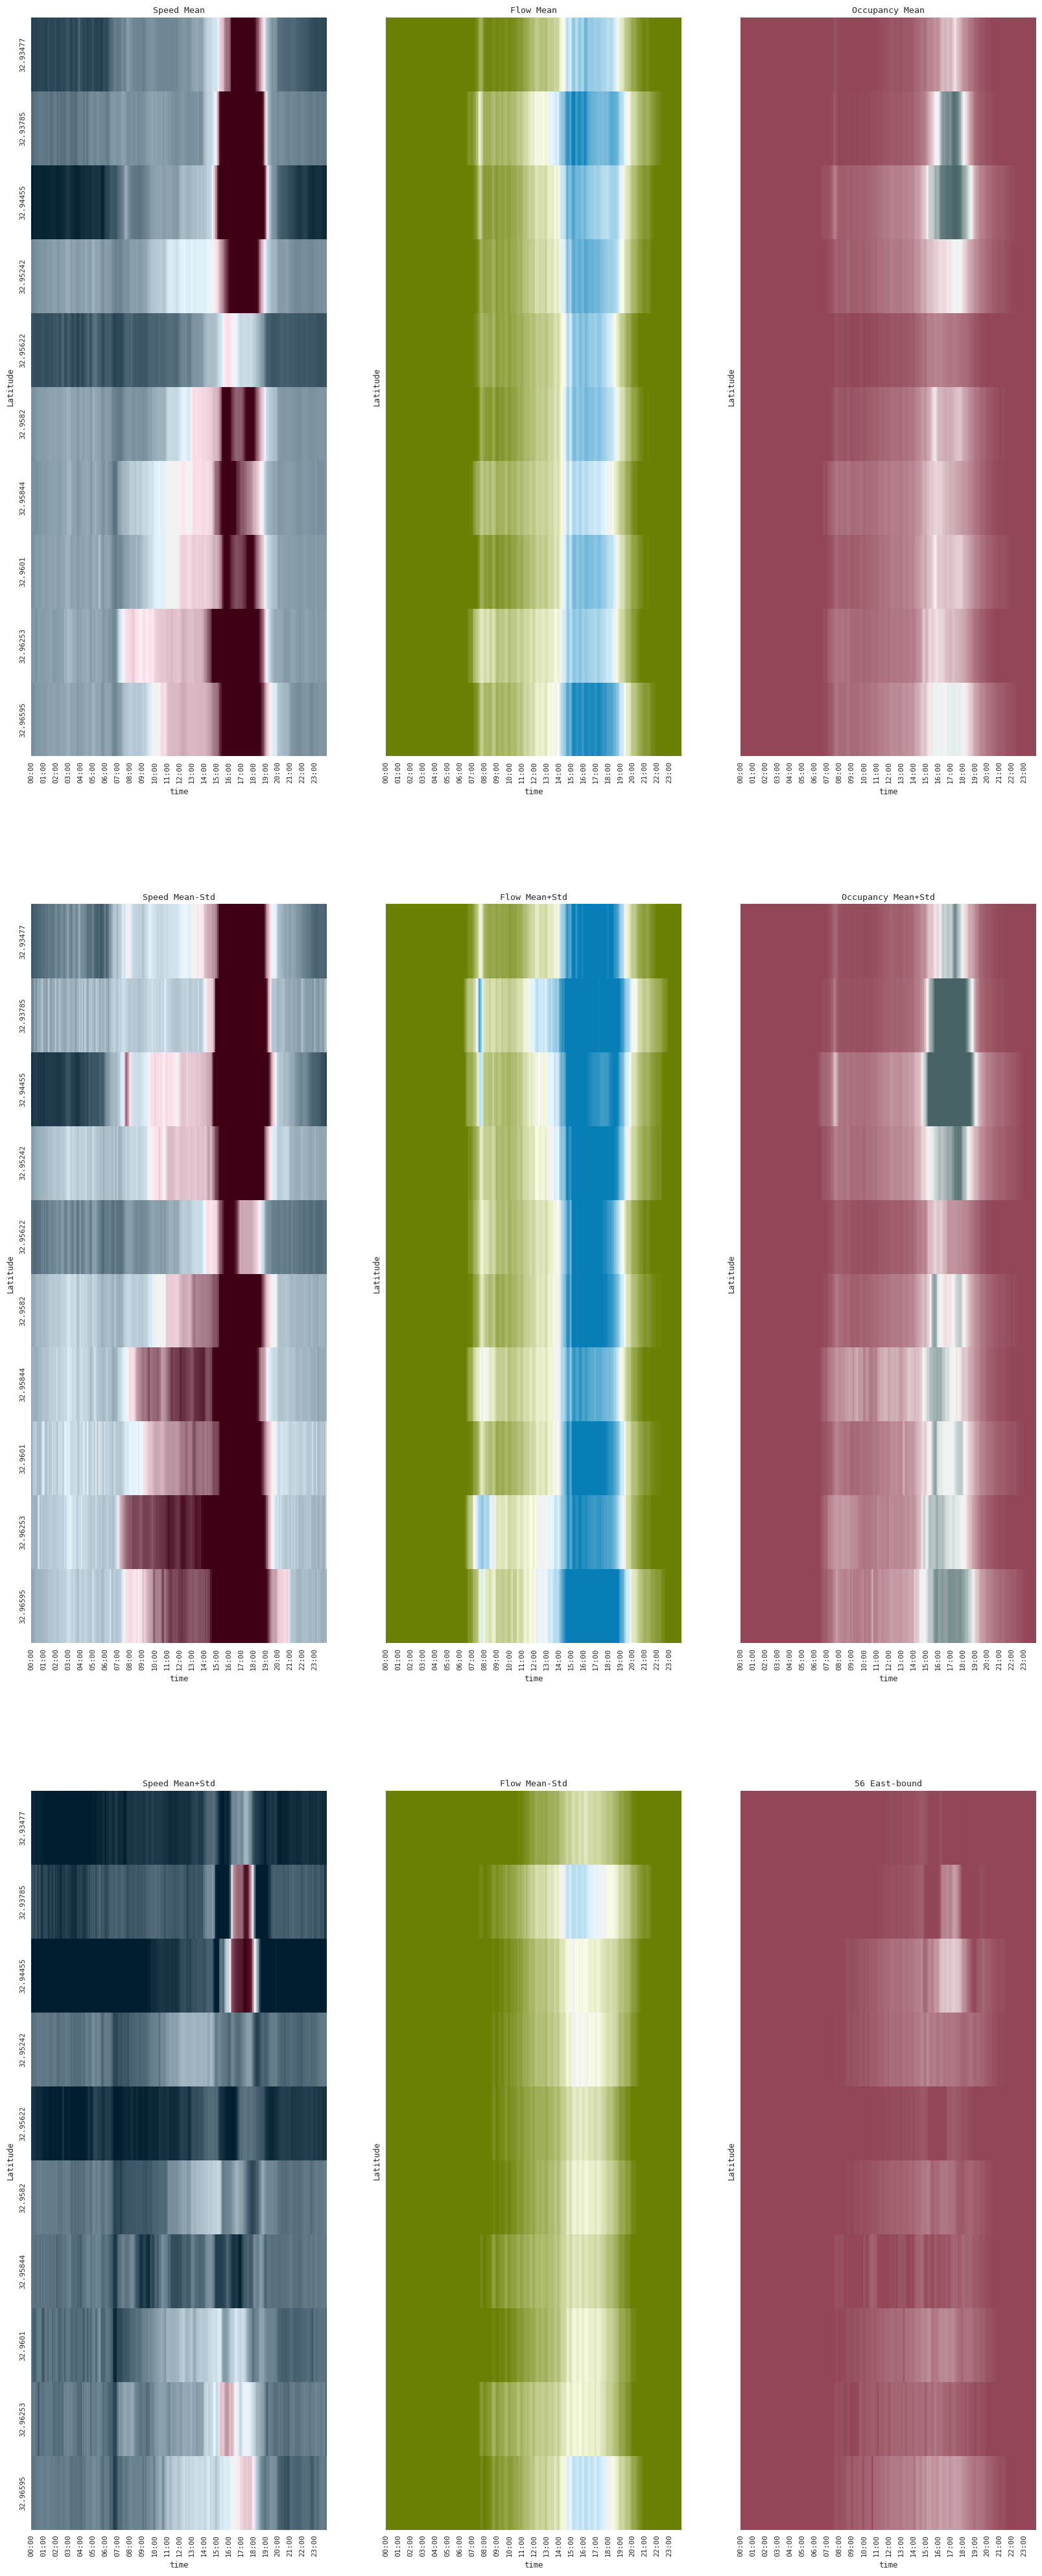

In [21]:
keyval_dict = {"District": 11, "Freeway #":56,  "Lane Type": 'ML', "Direction": 'E'} 
freeway_redux = reduce_data_by_dict(raw_5_min_data, keyval_dict)

meta_dict= {"District": 11, "Fwy": 56,  "Dir": 'E'}
meta_redux = reduce_data_by_dict(meta, meta_dict)

i5S = plot_freeway_heatmap(freeway_redux, meta_redux, "56 East-bound")

/Users/mikihardisty/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


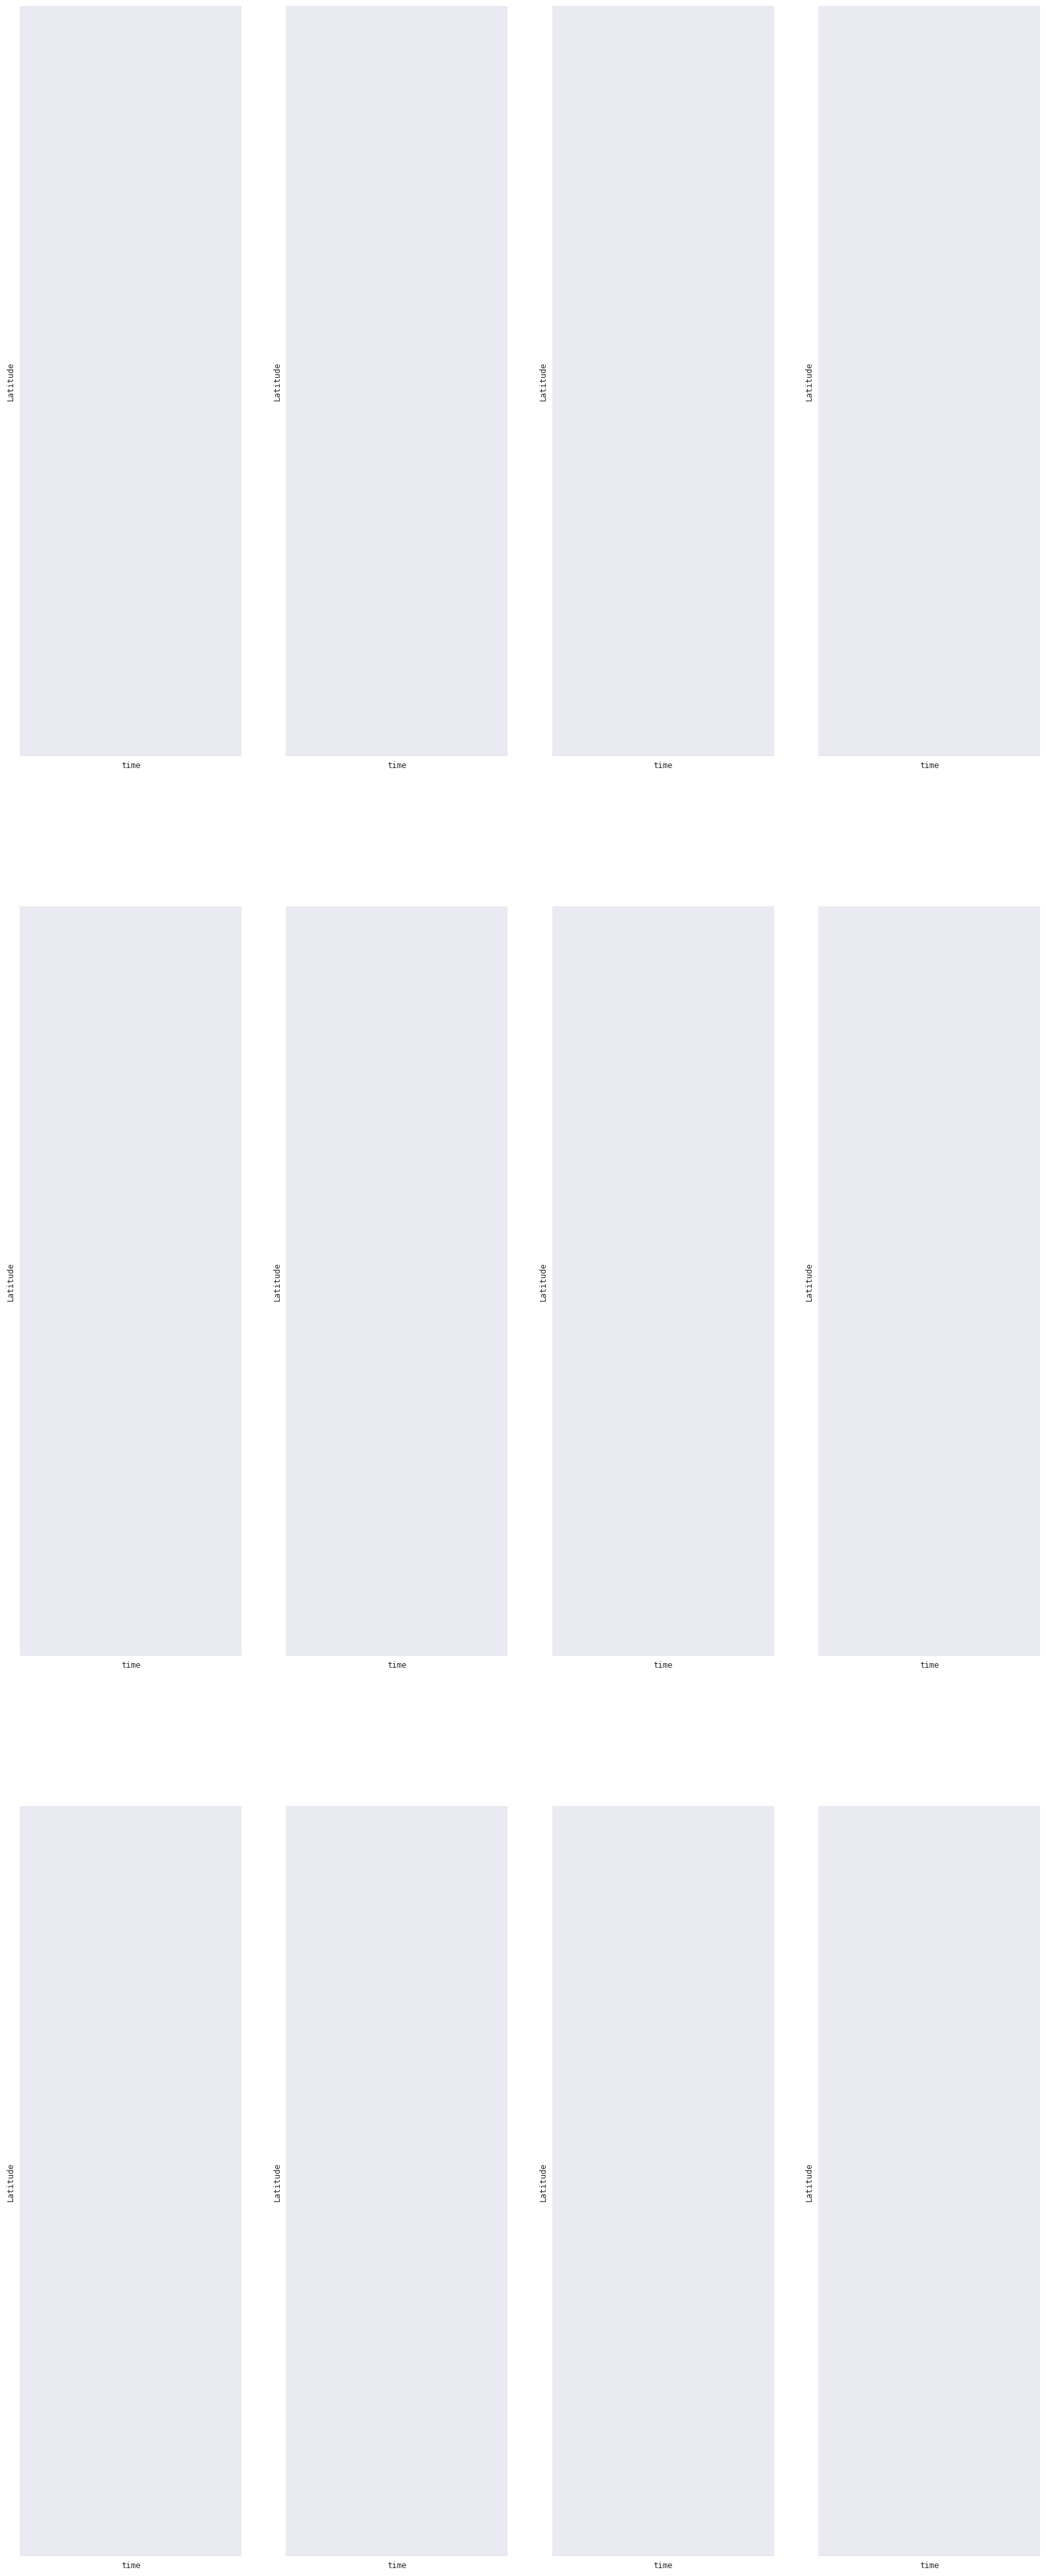

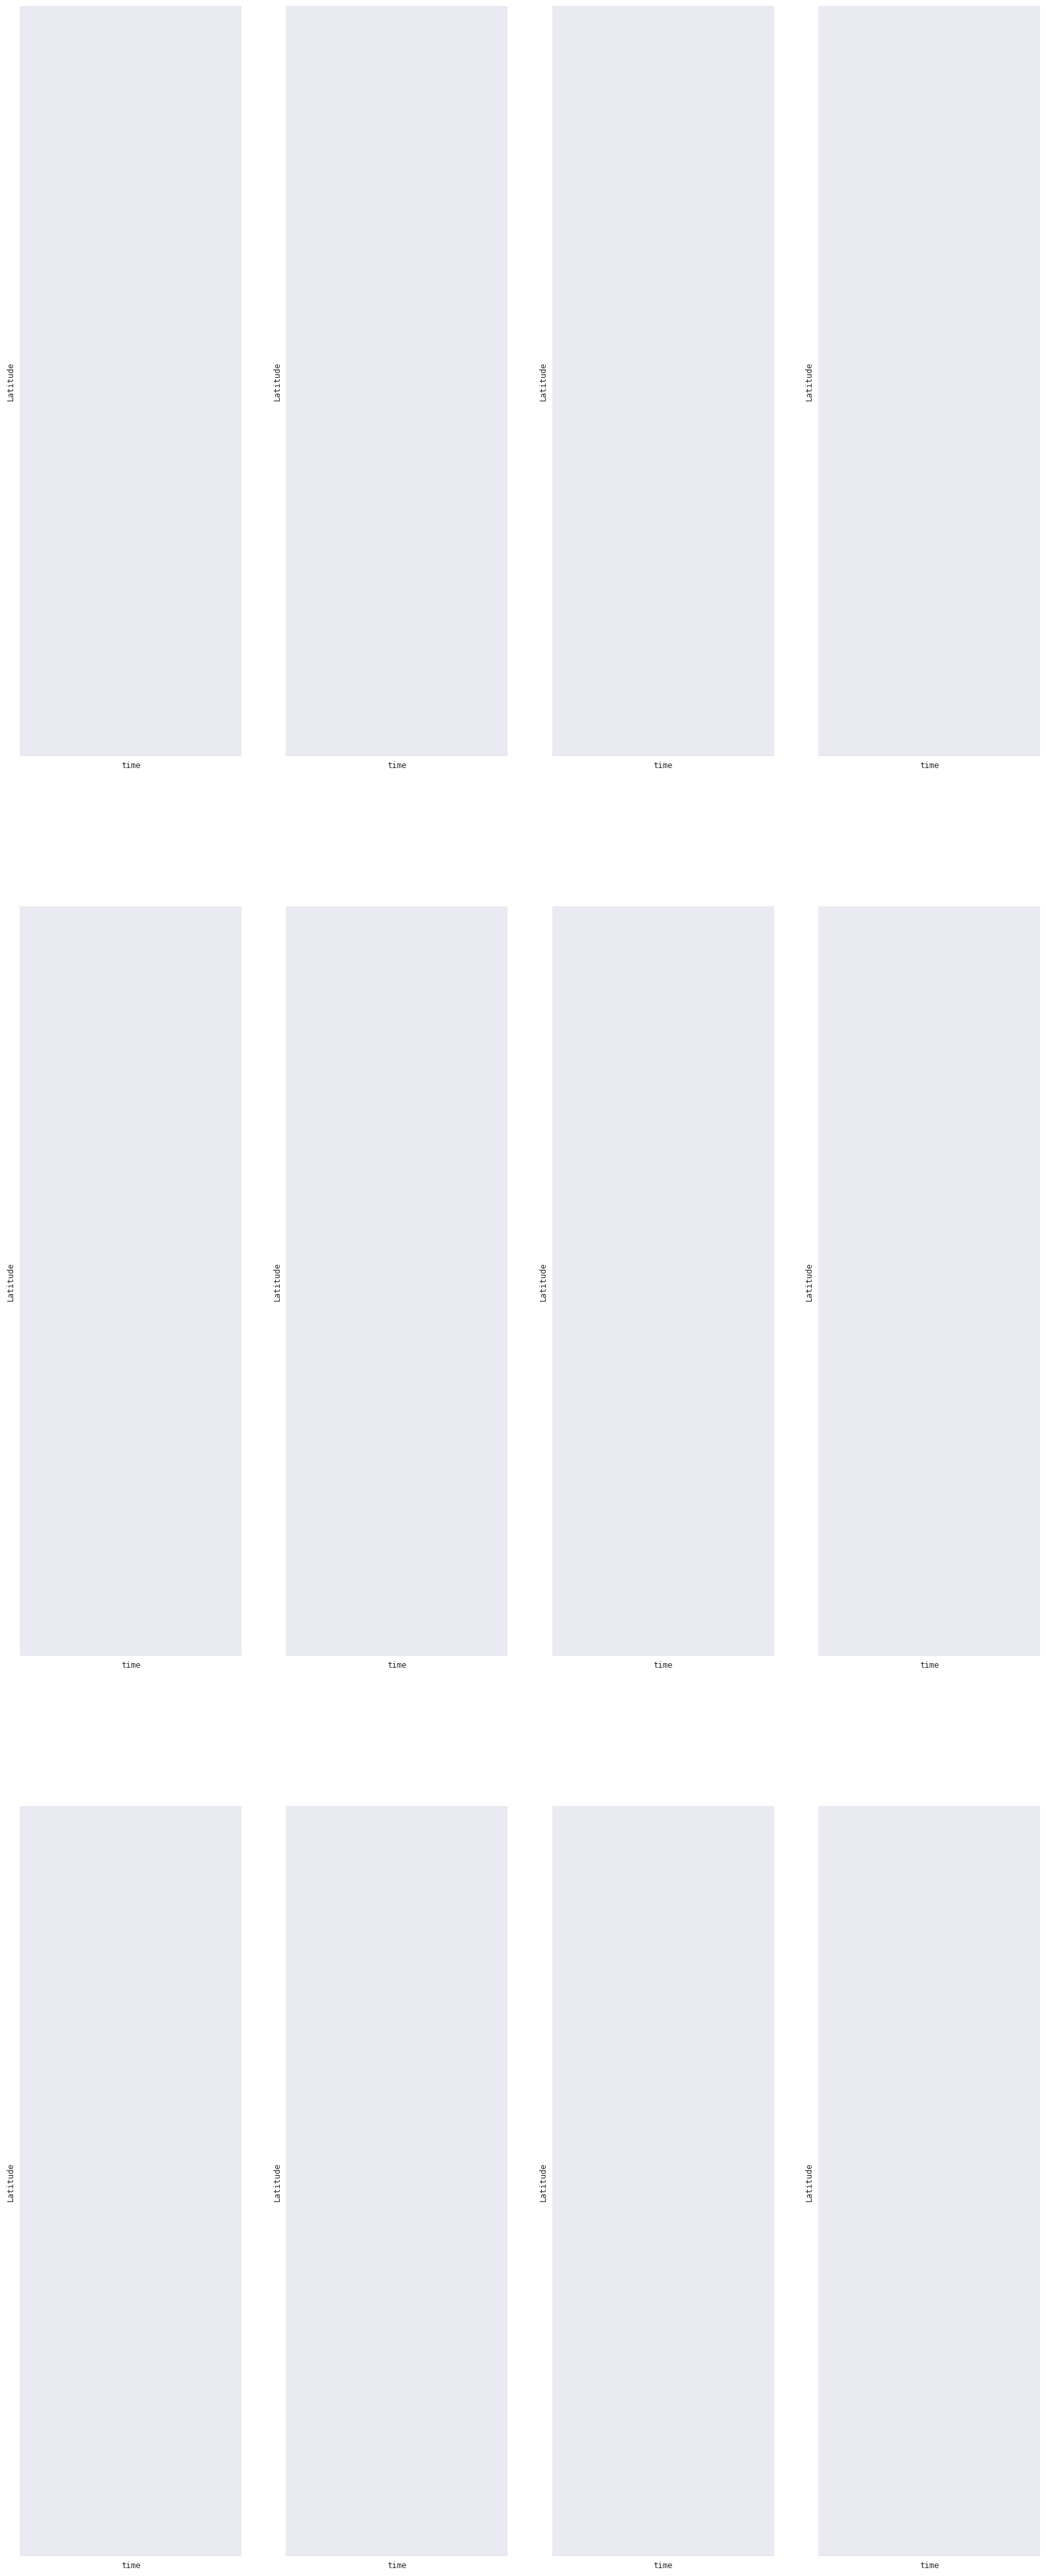

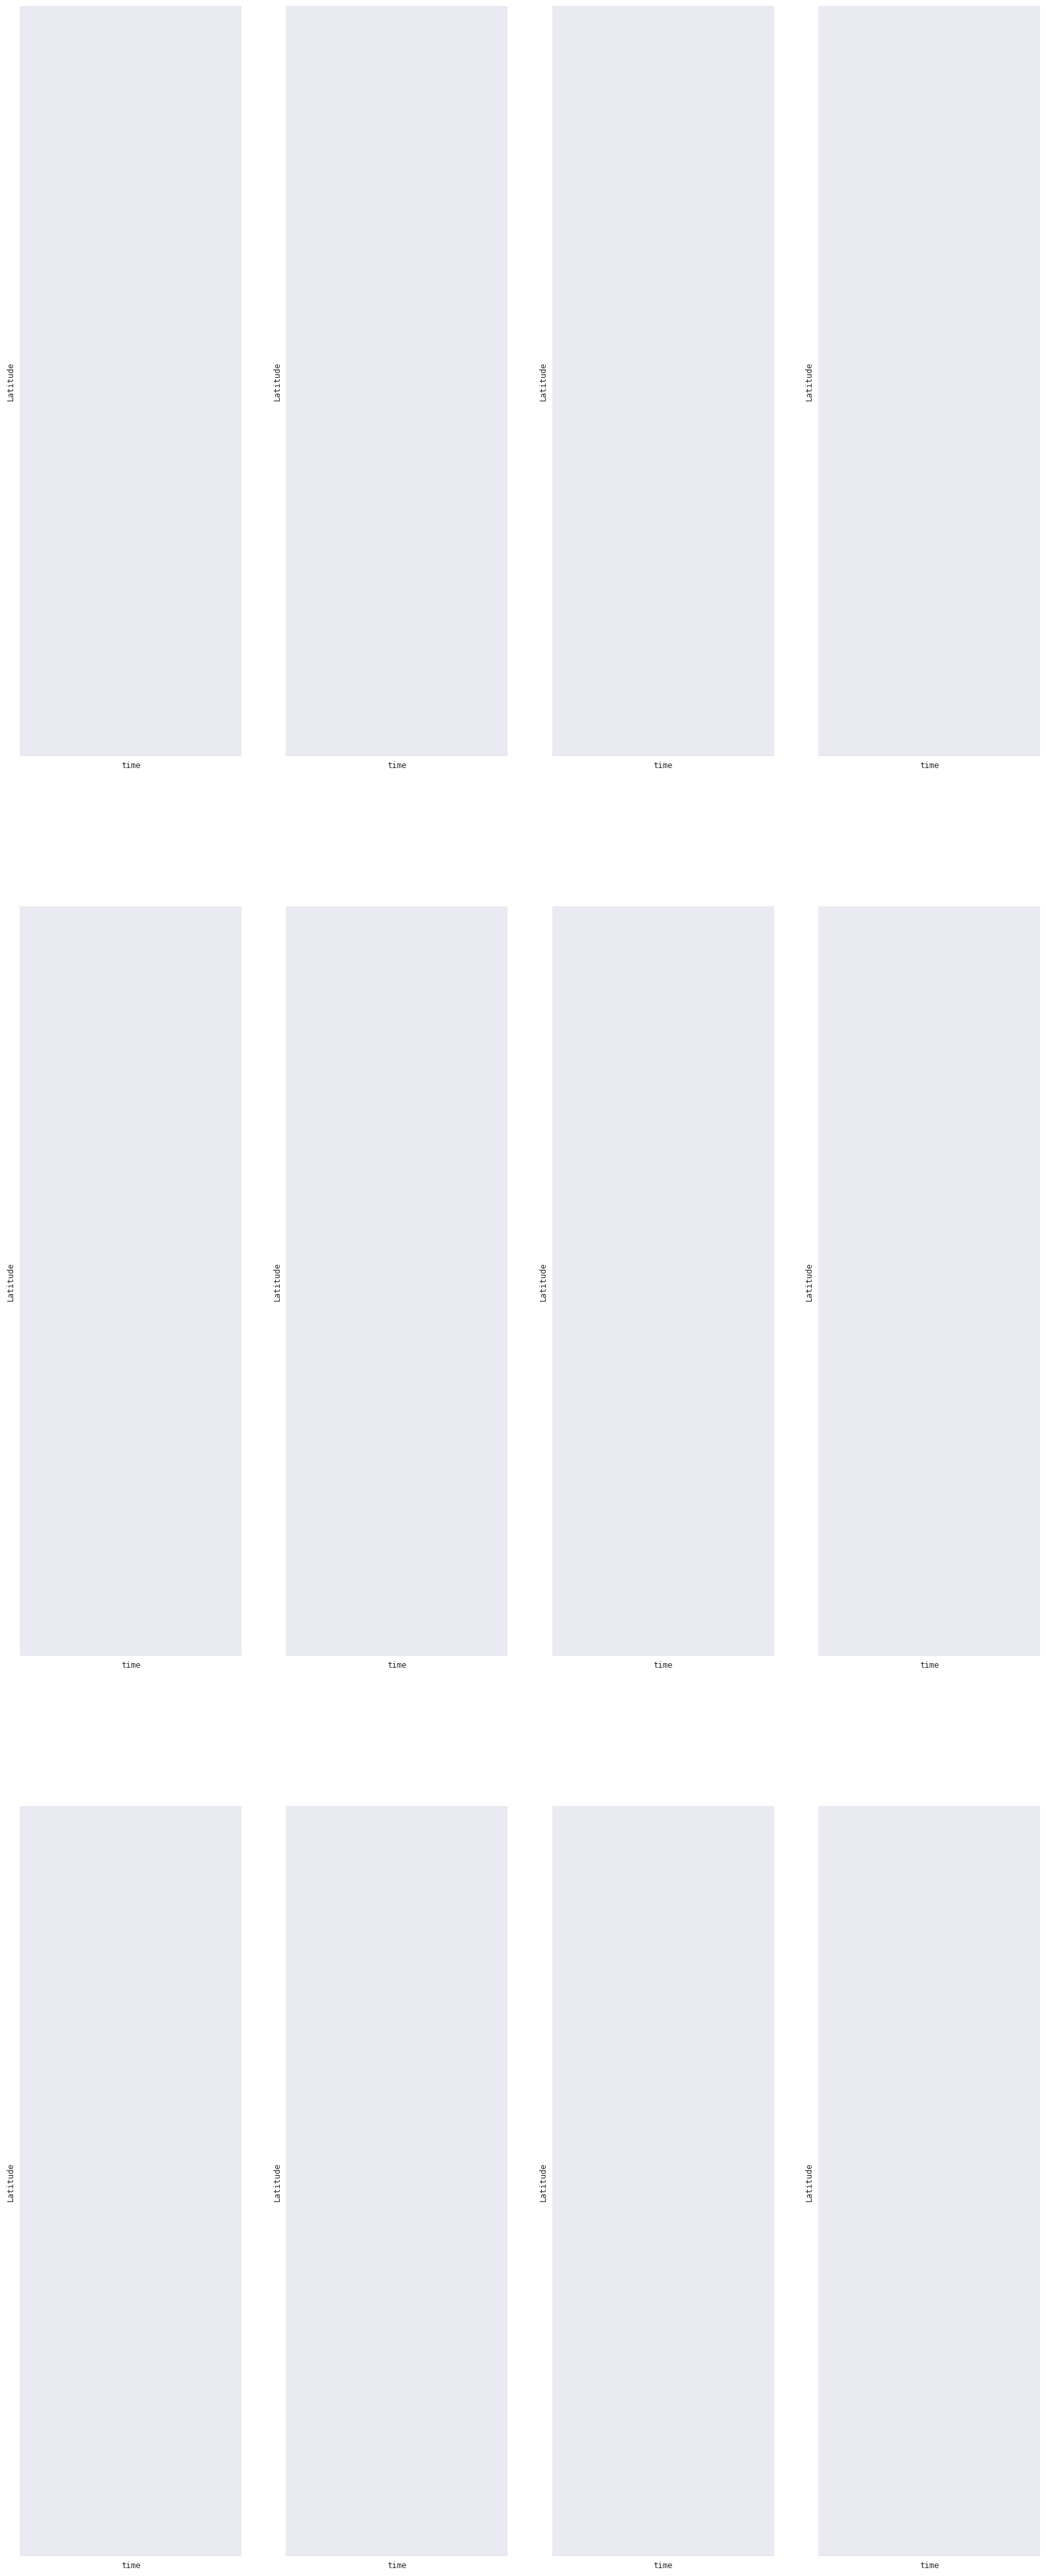

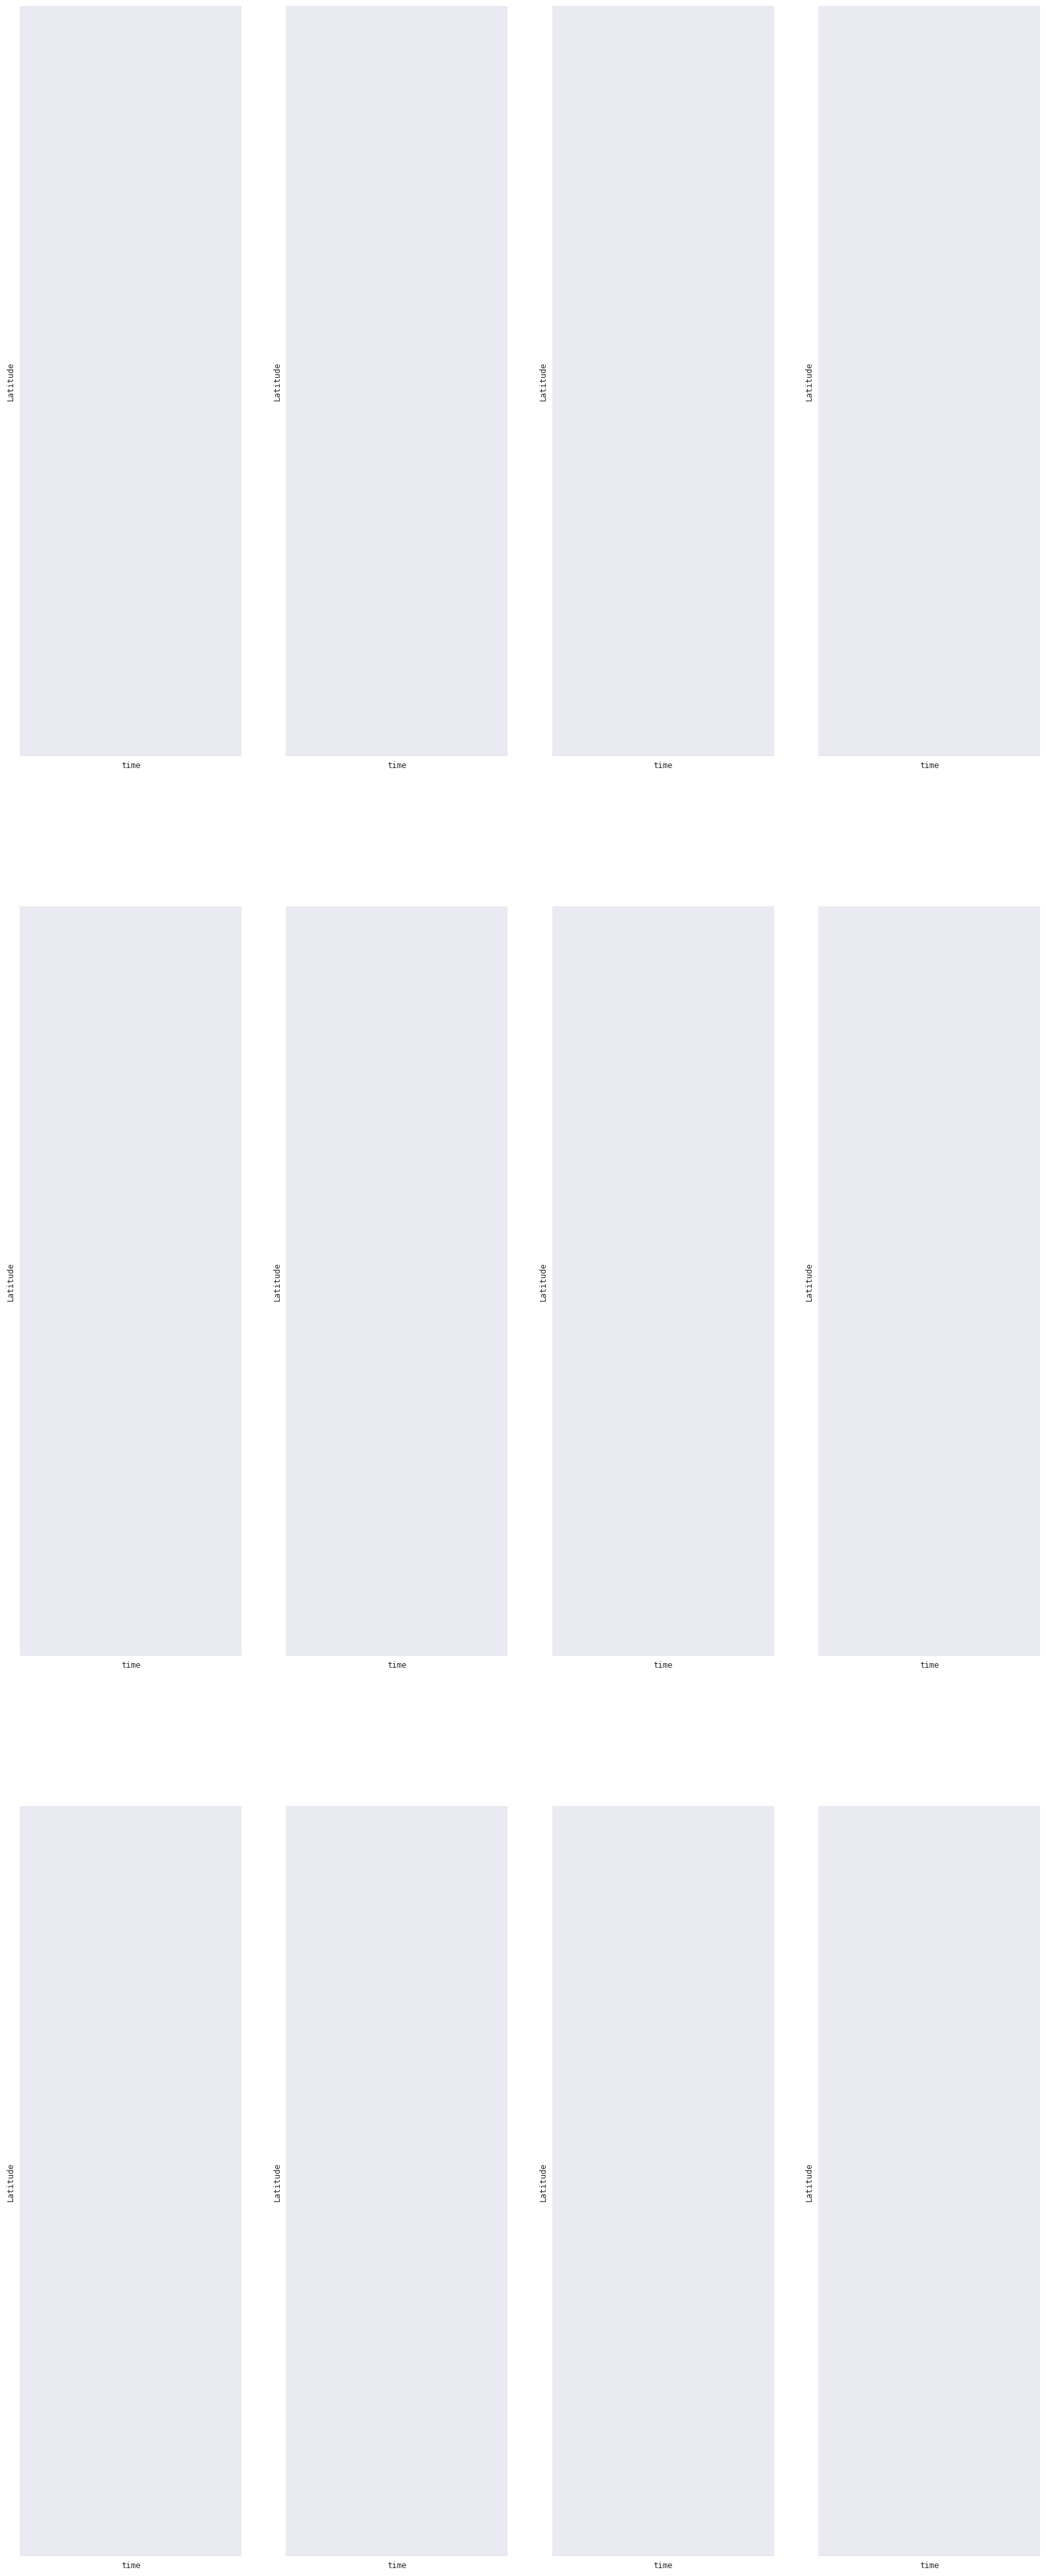

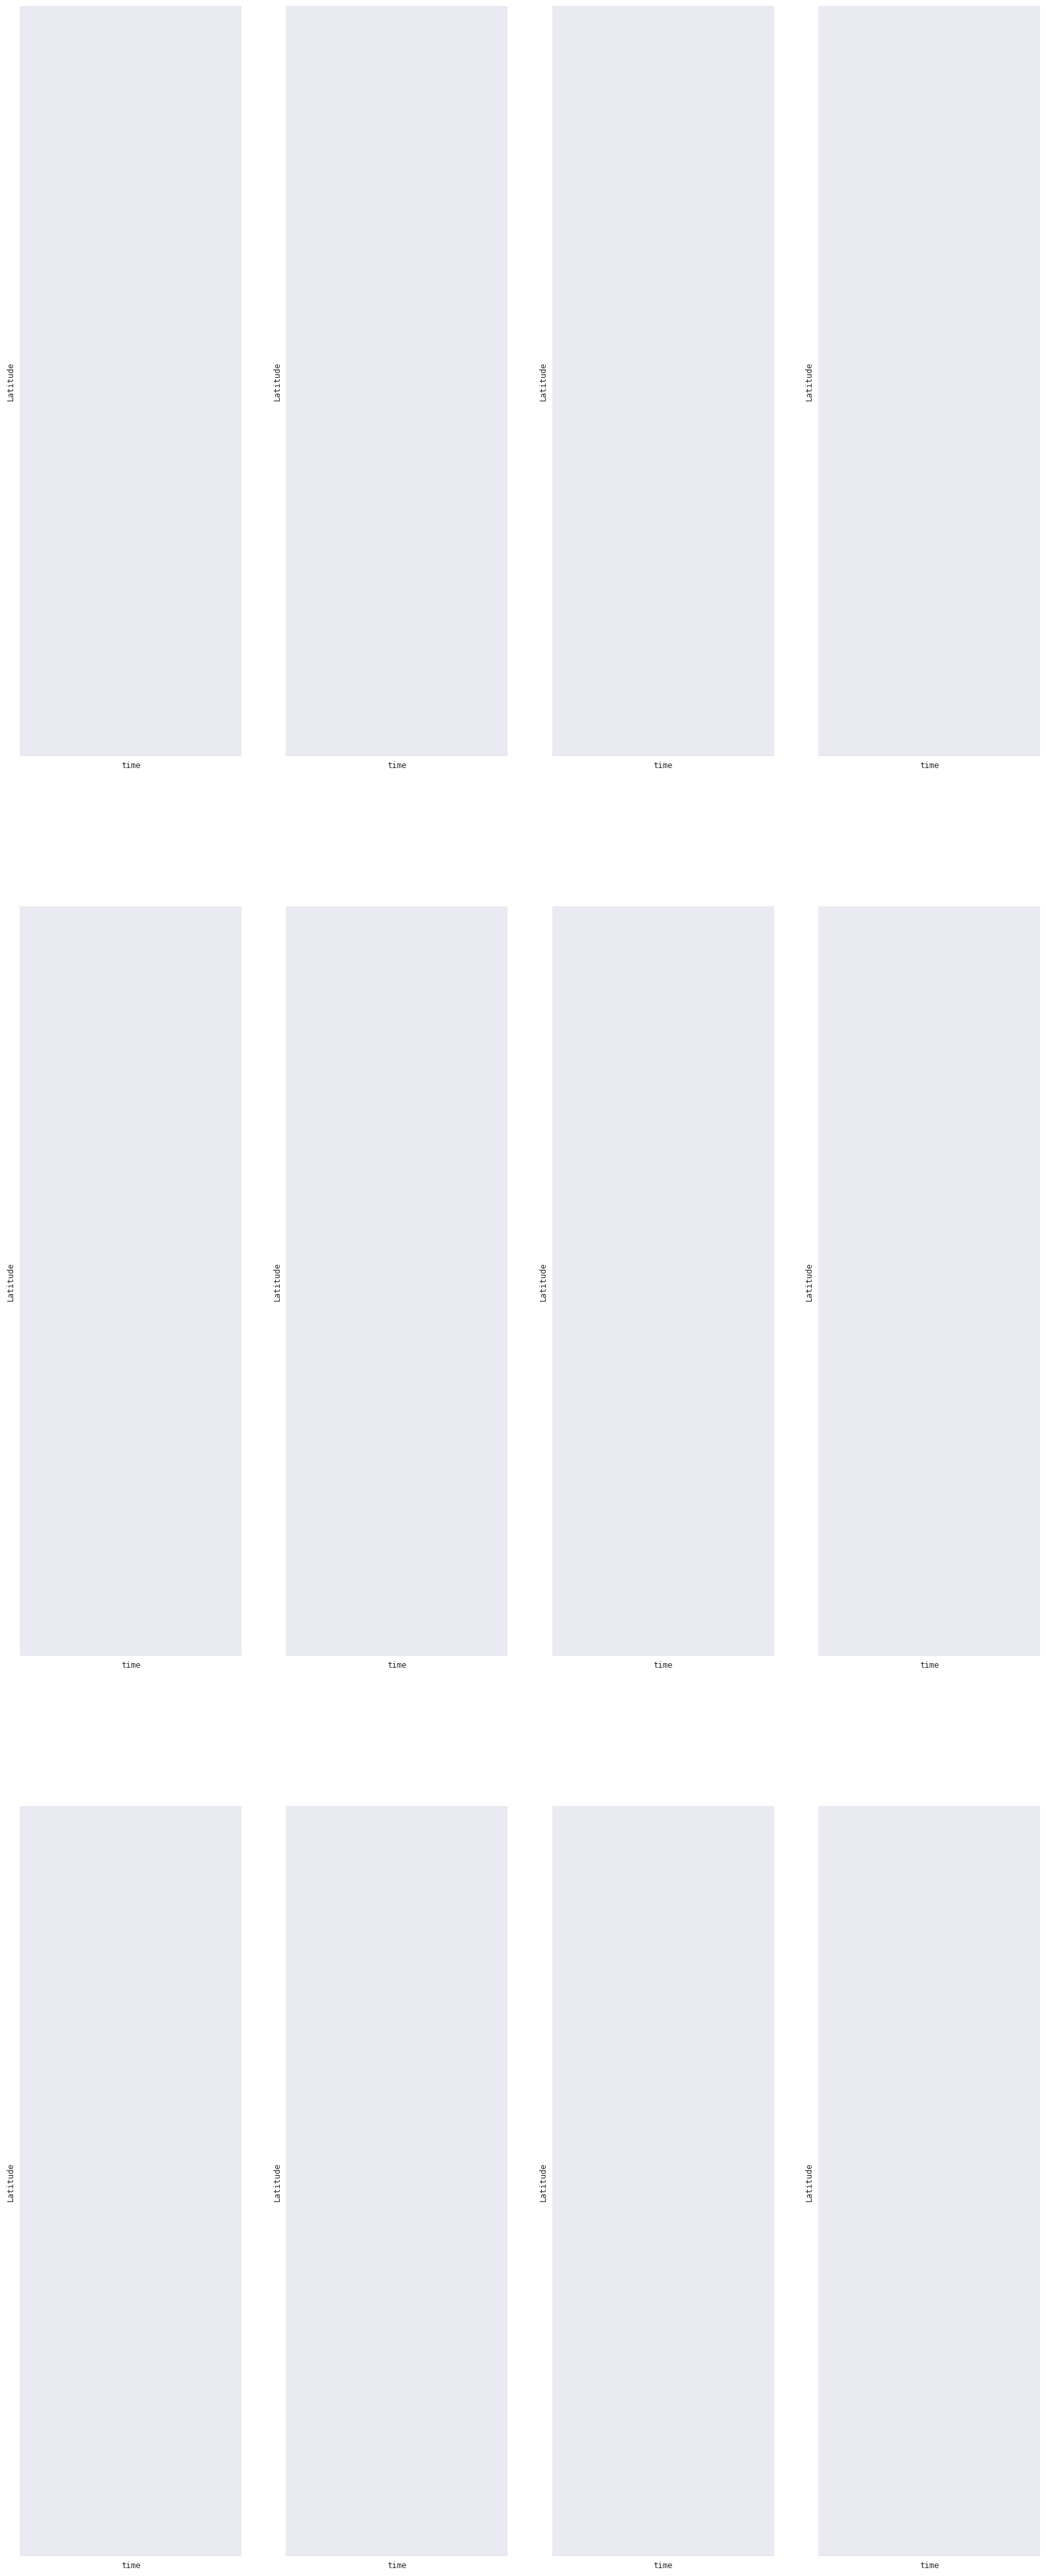

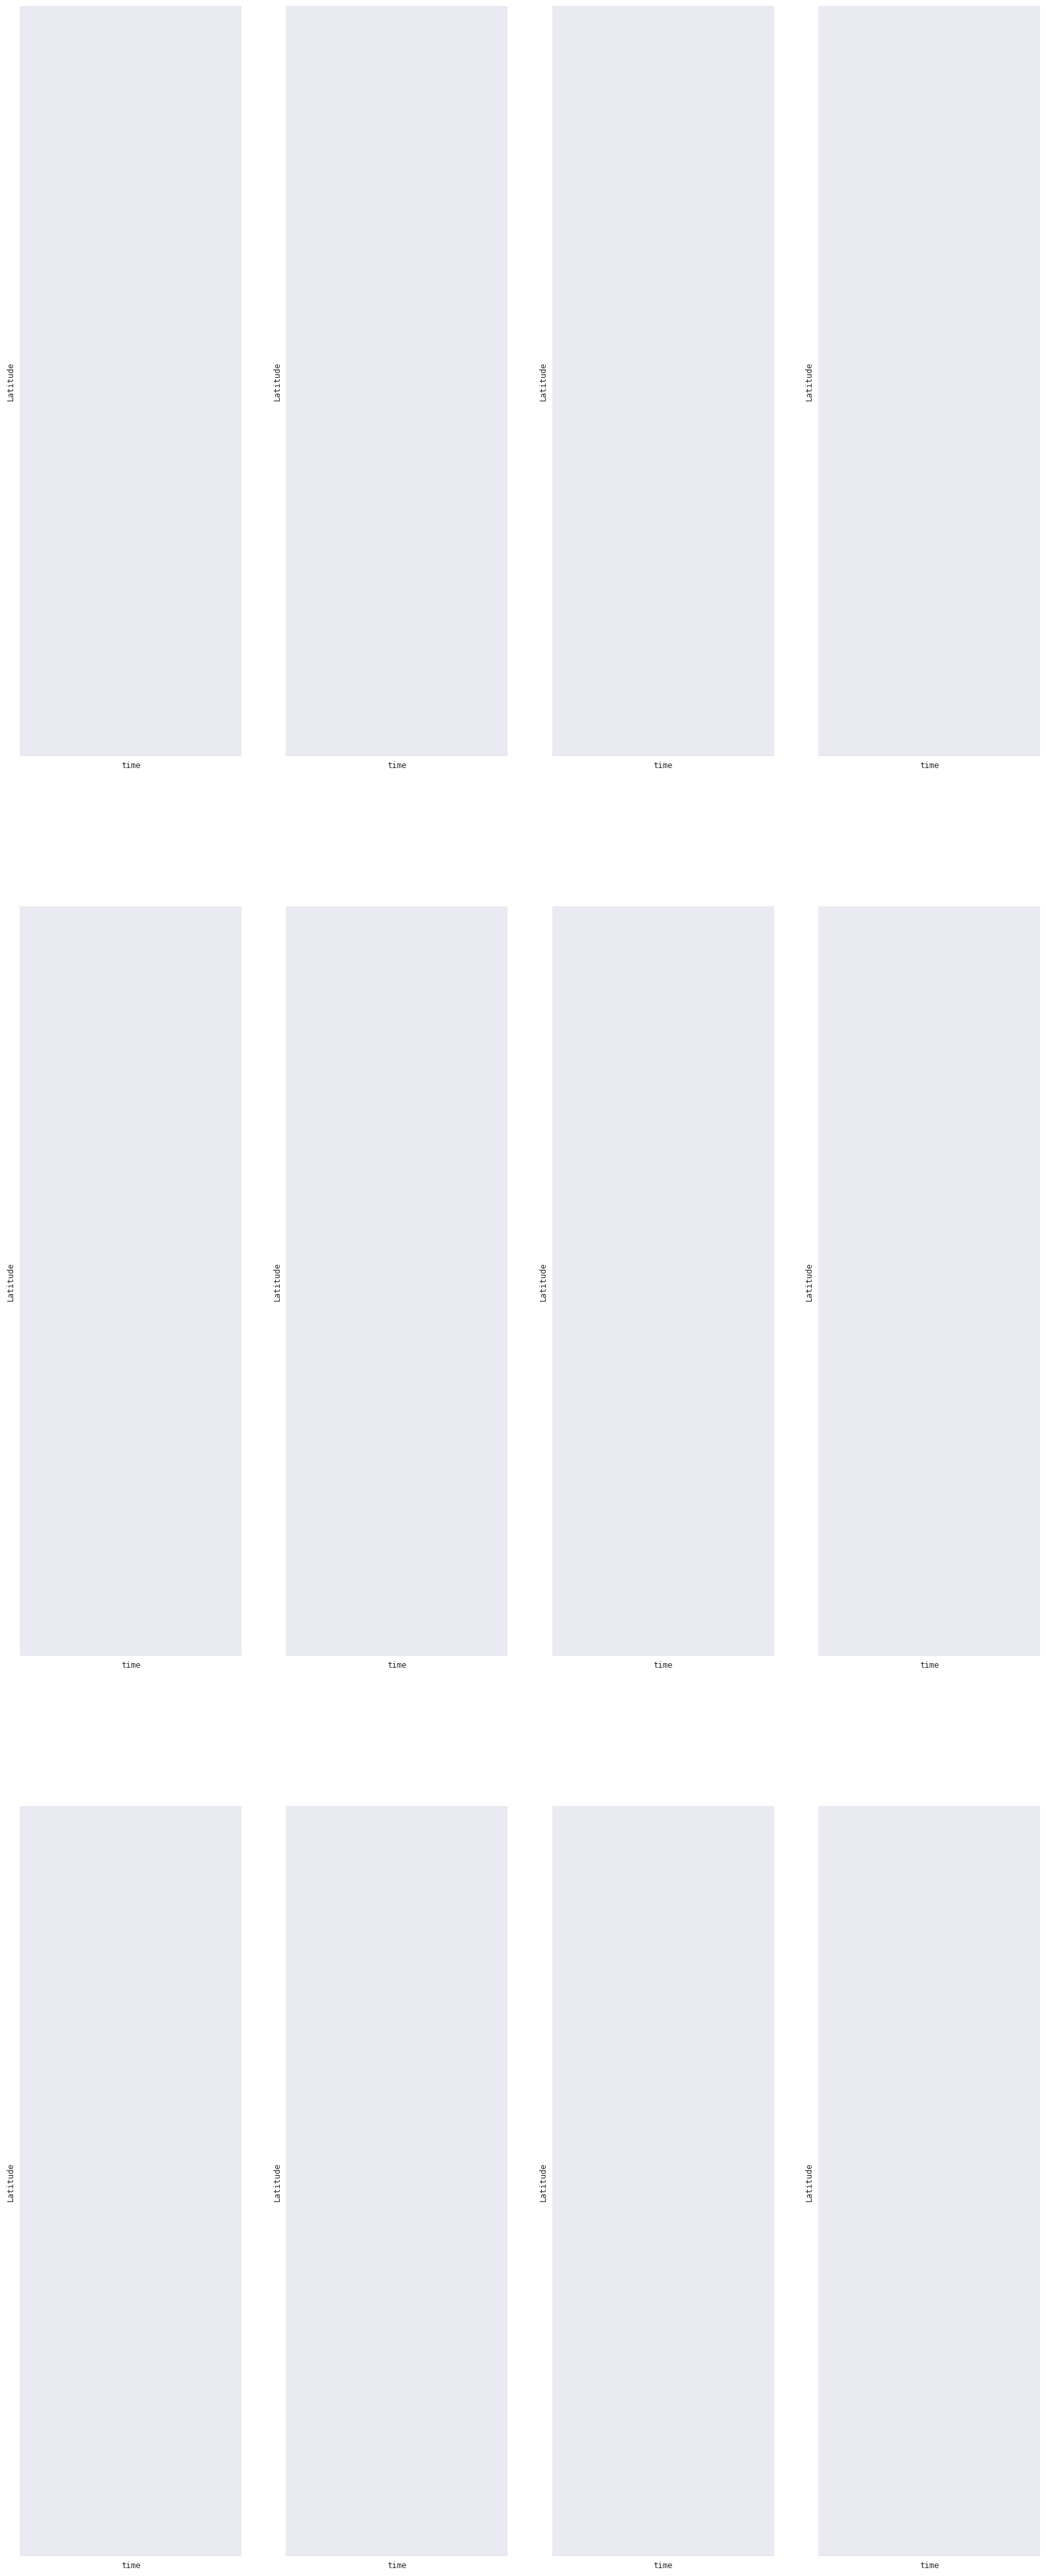

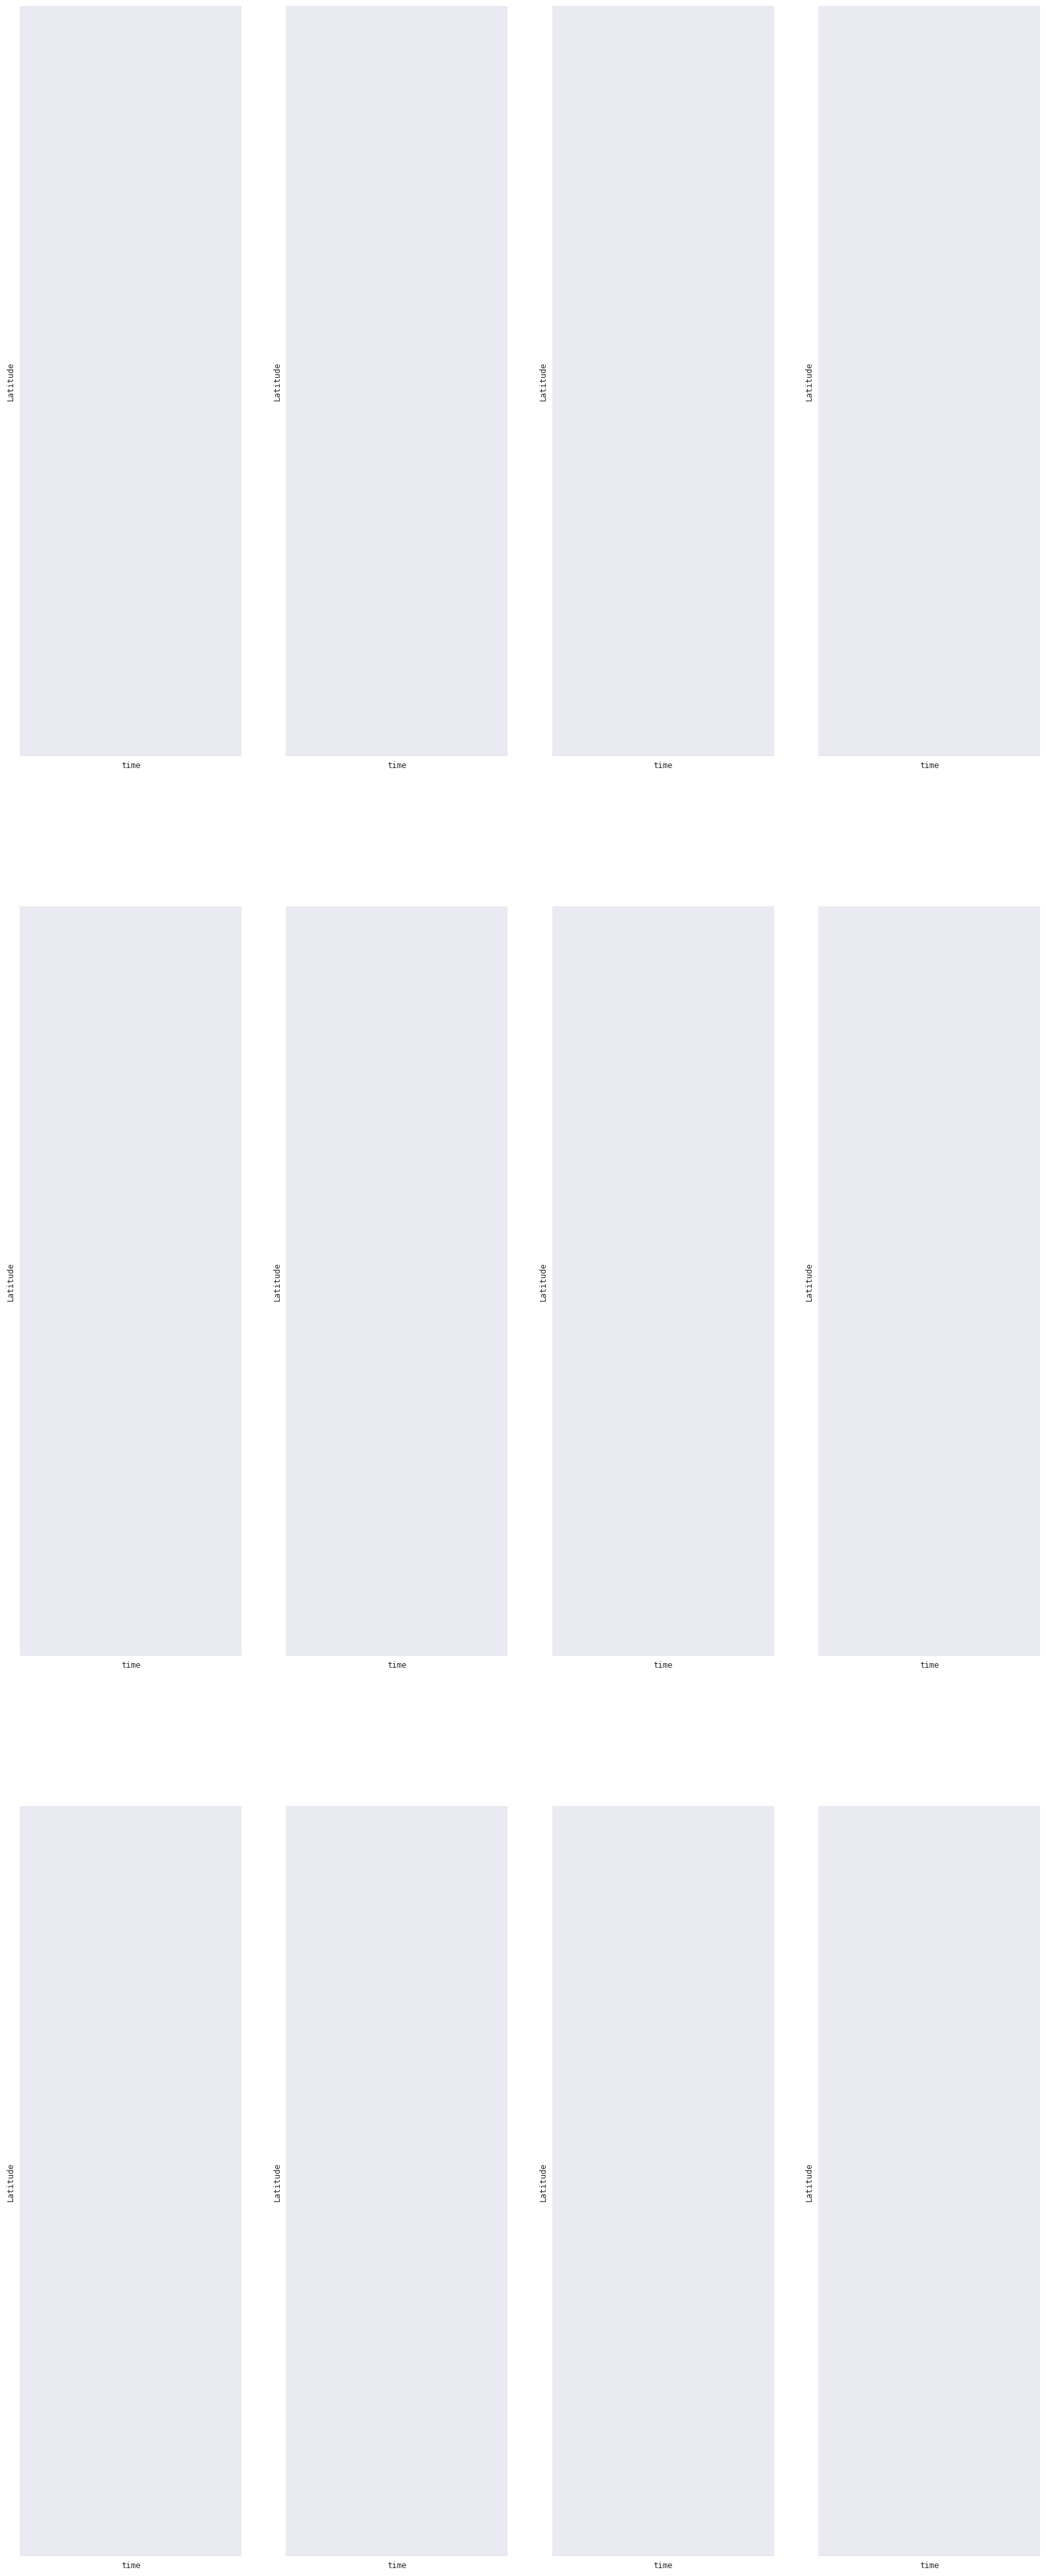

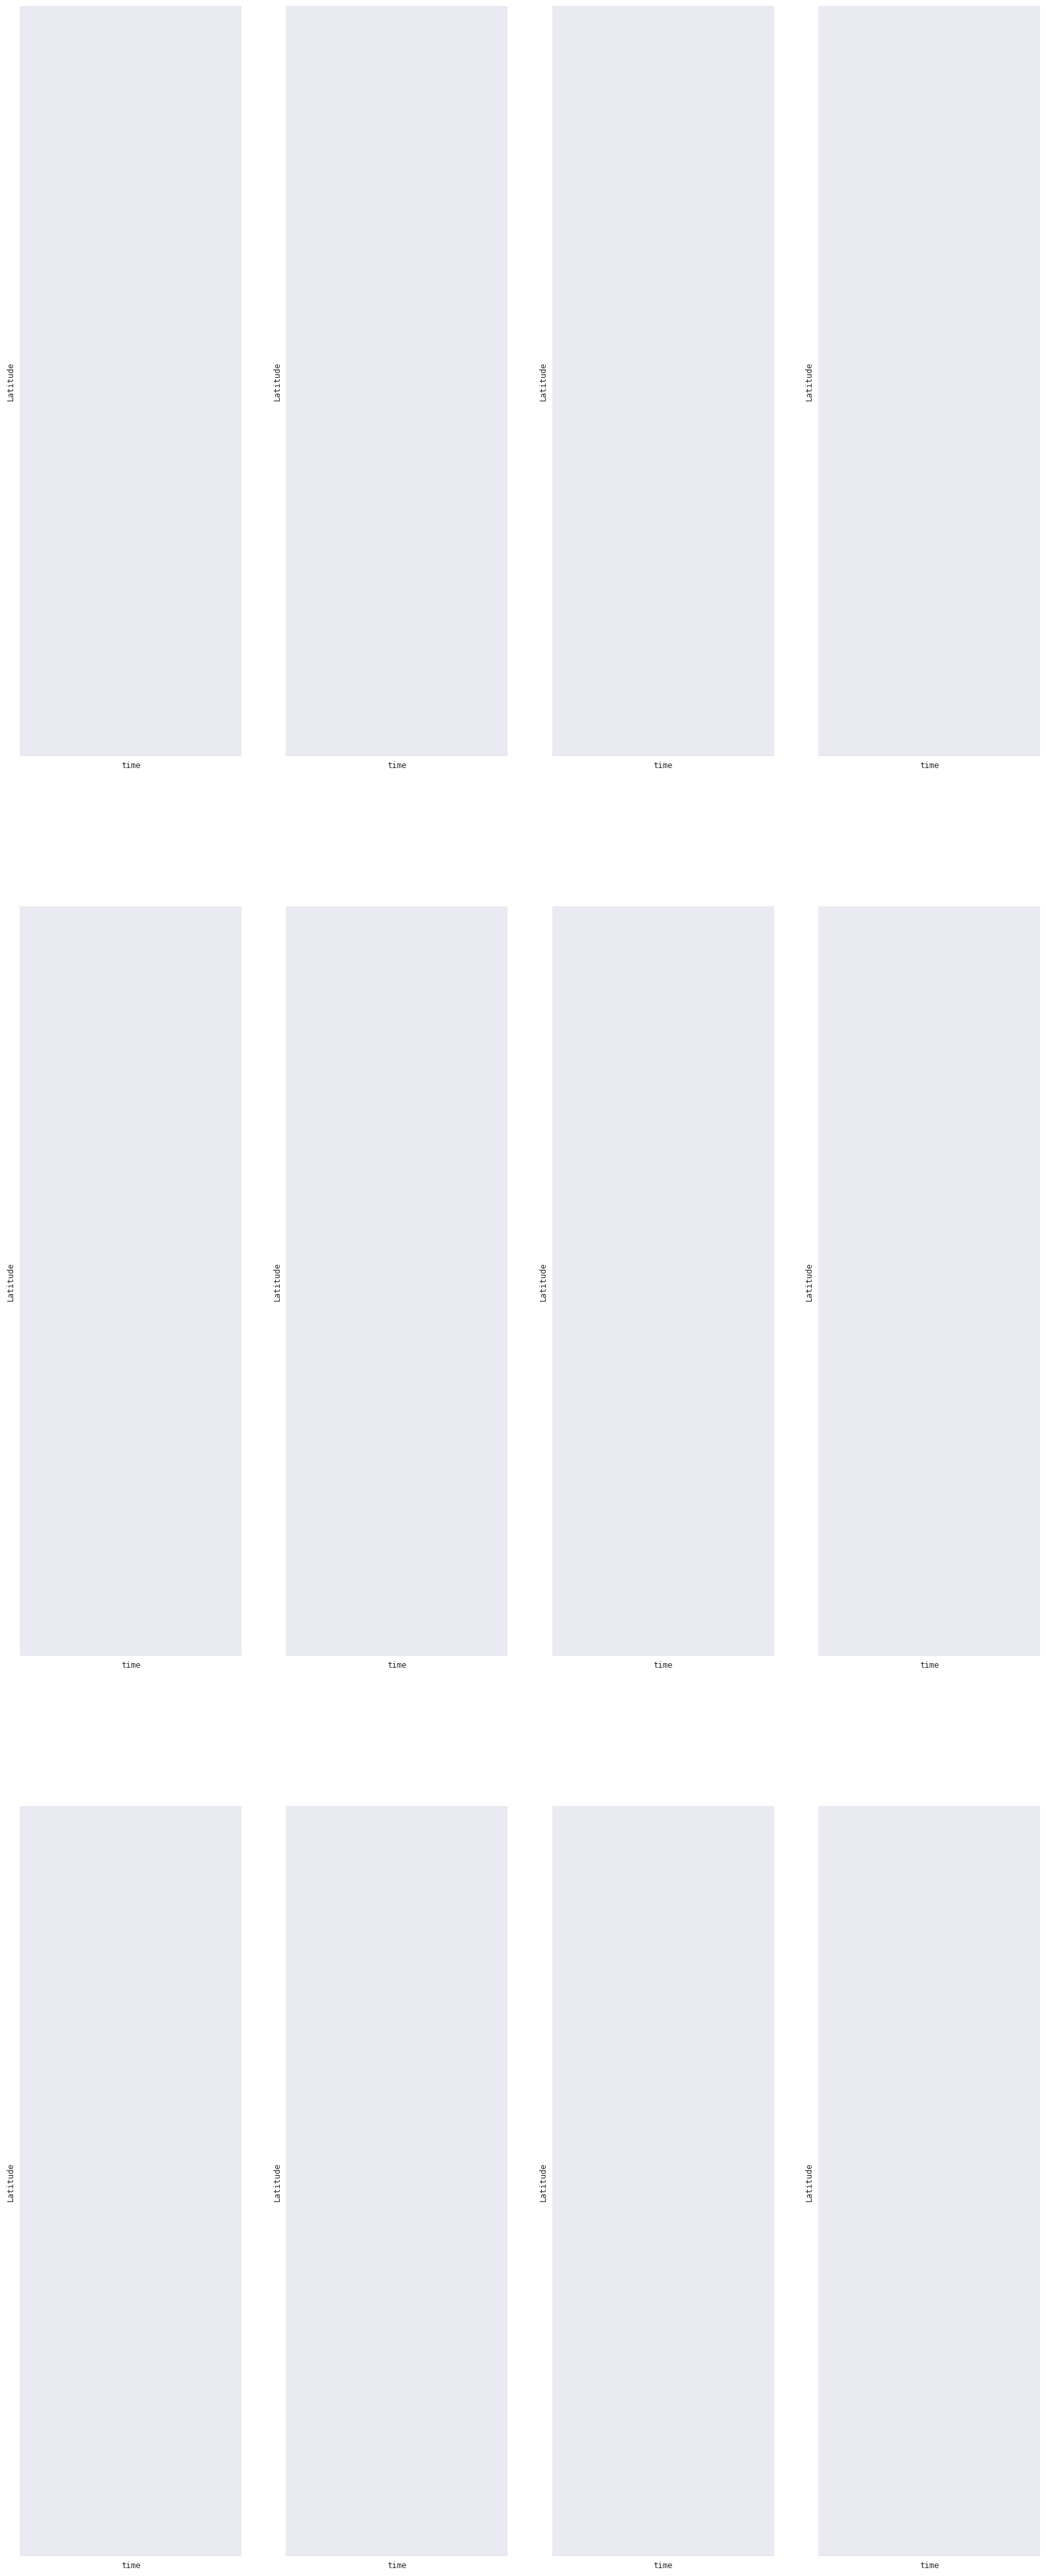

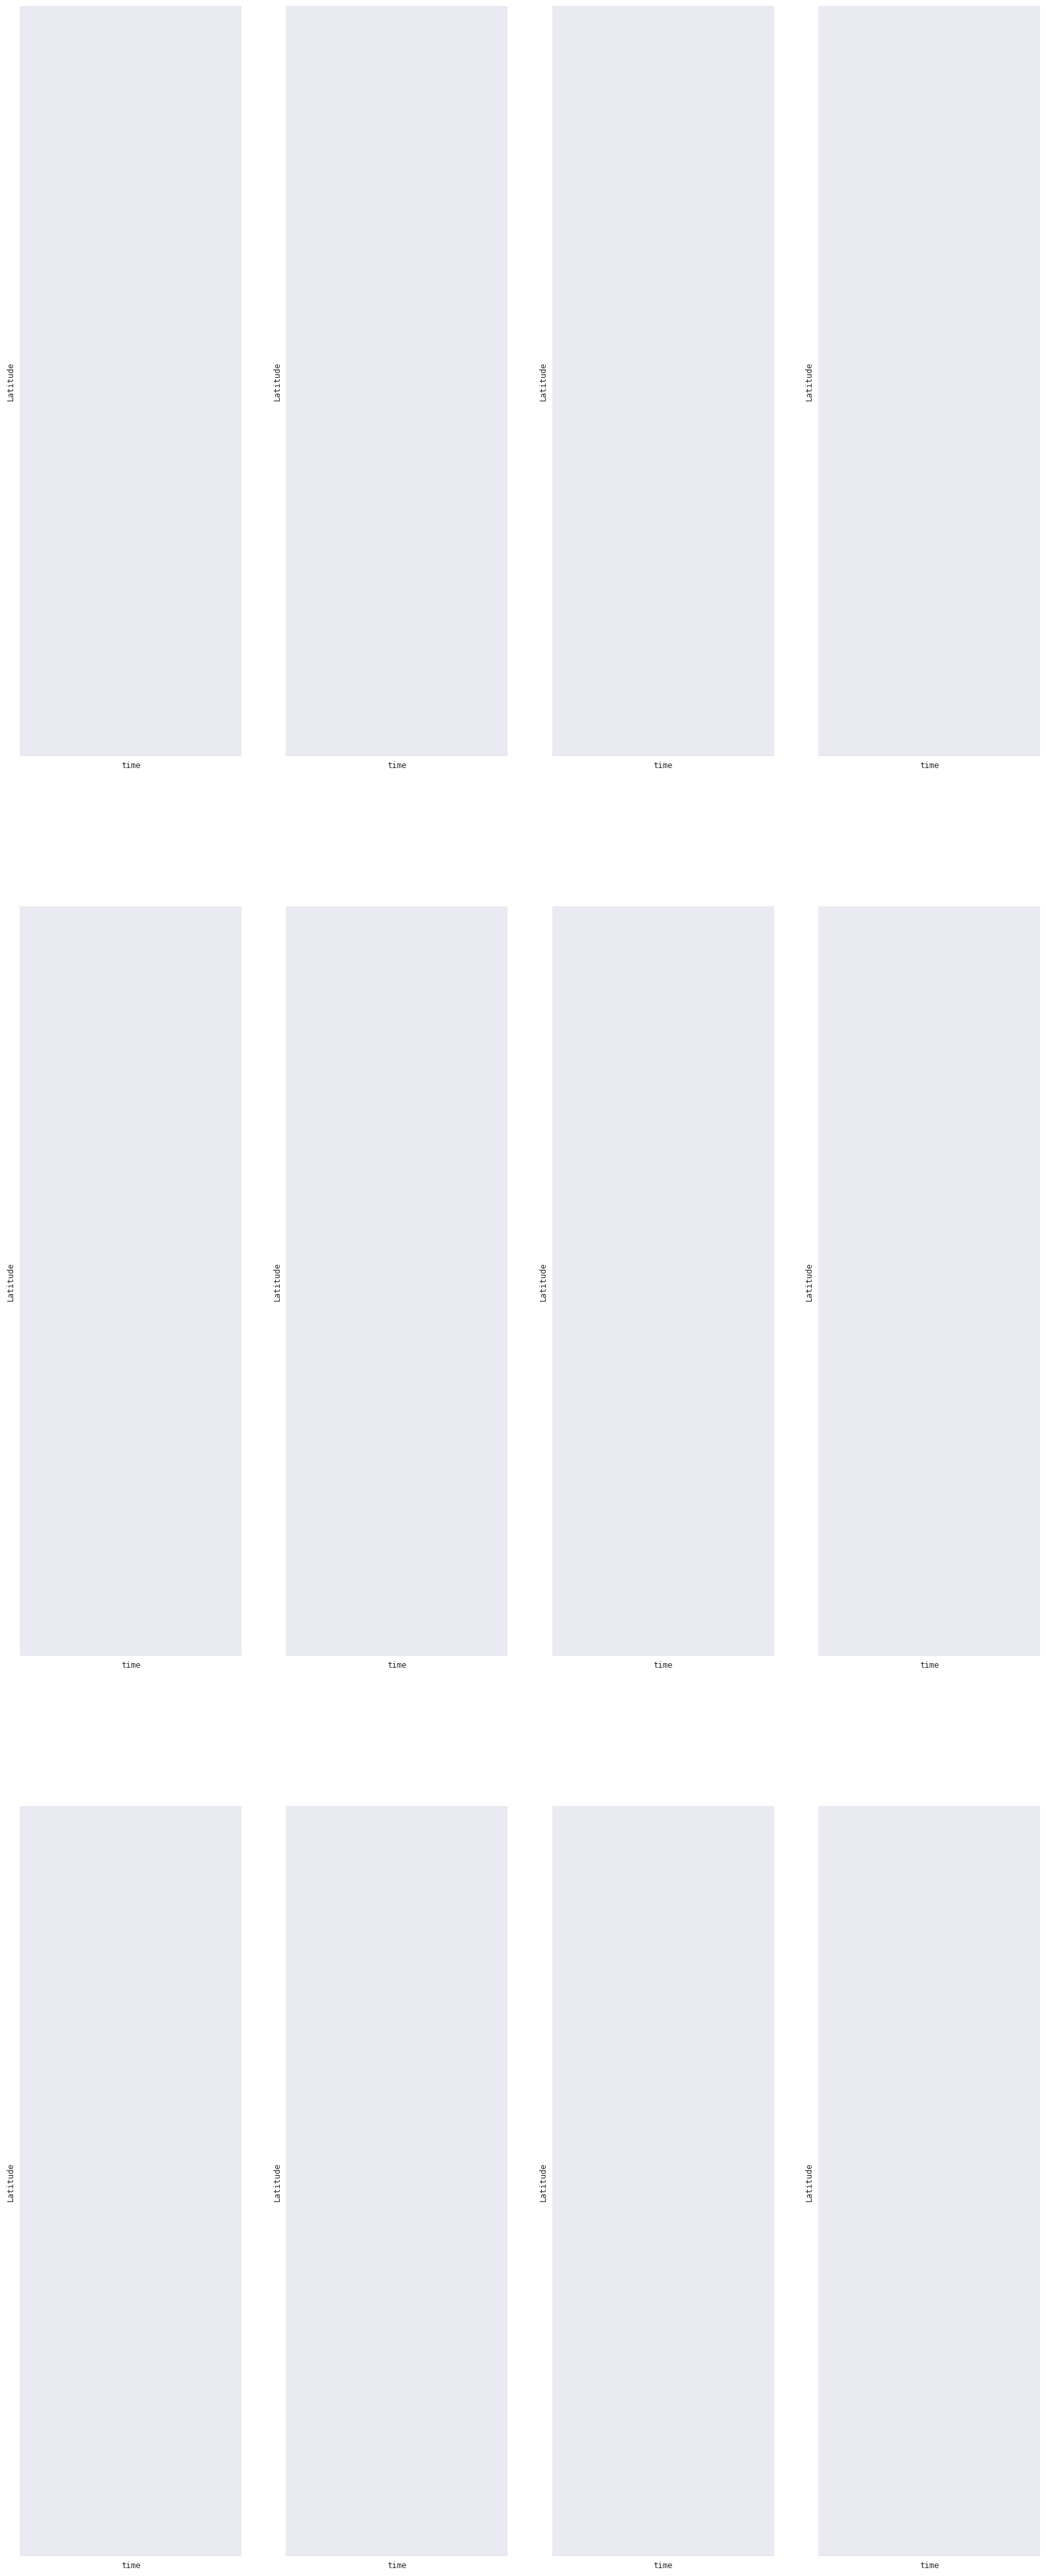

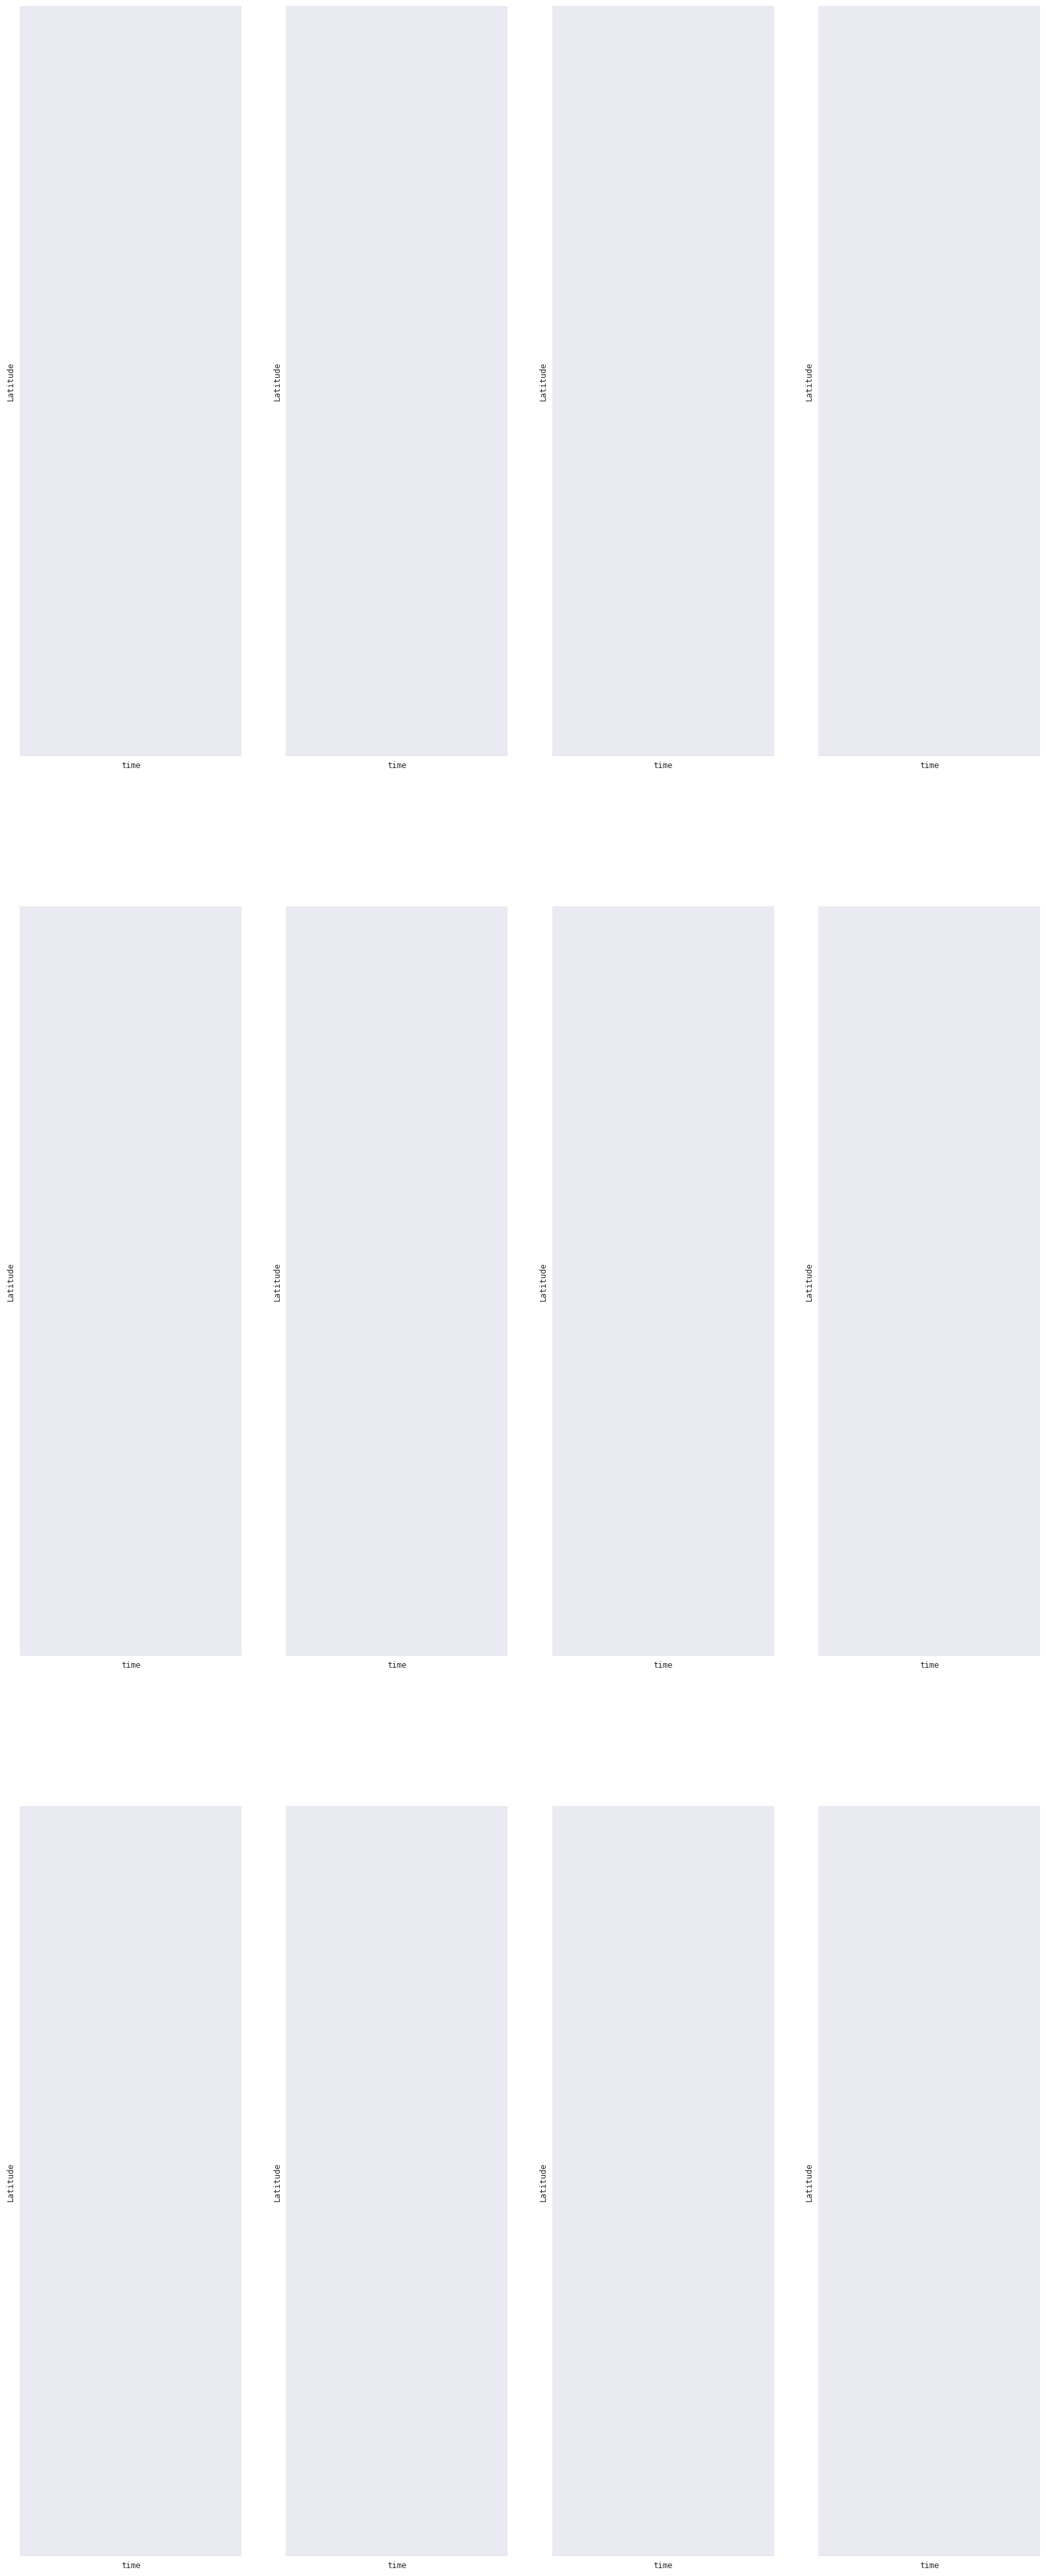

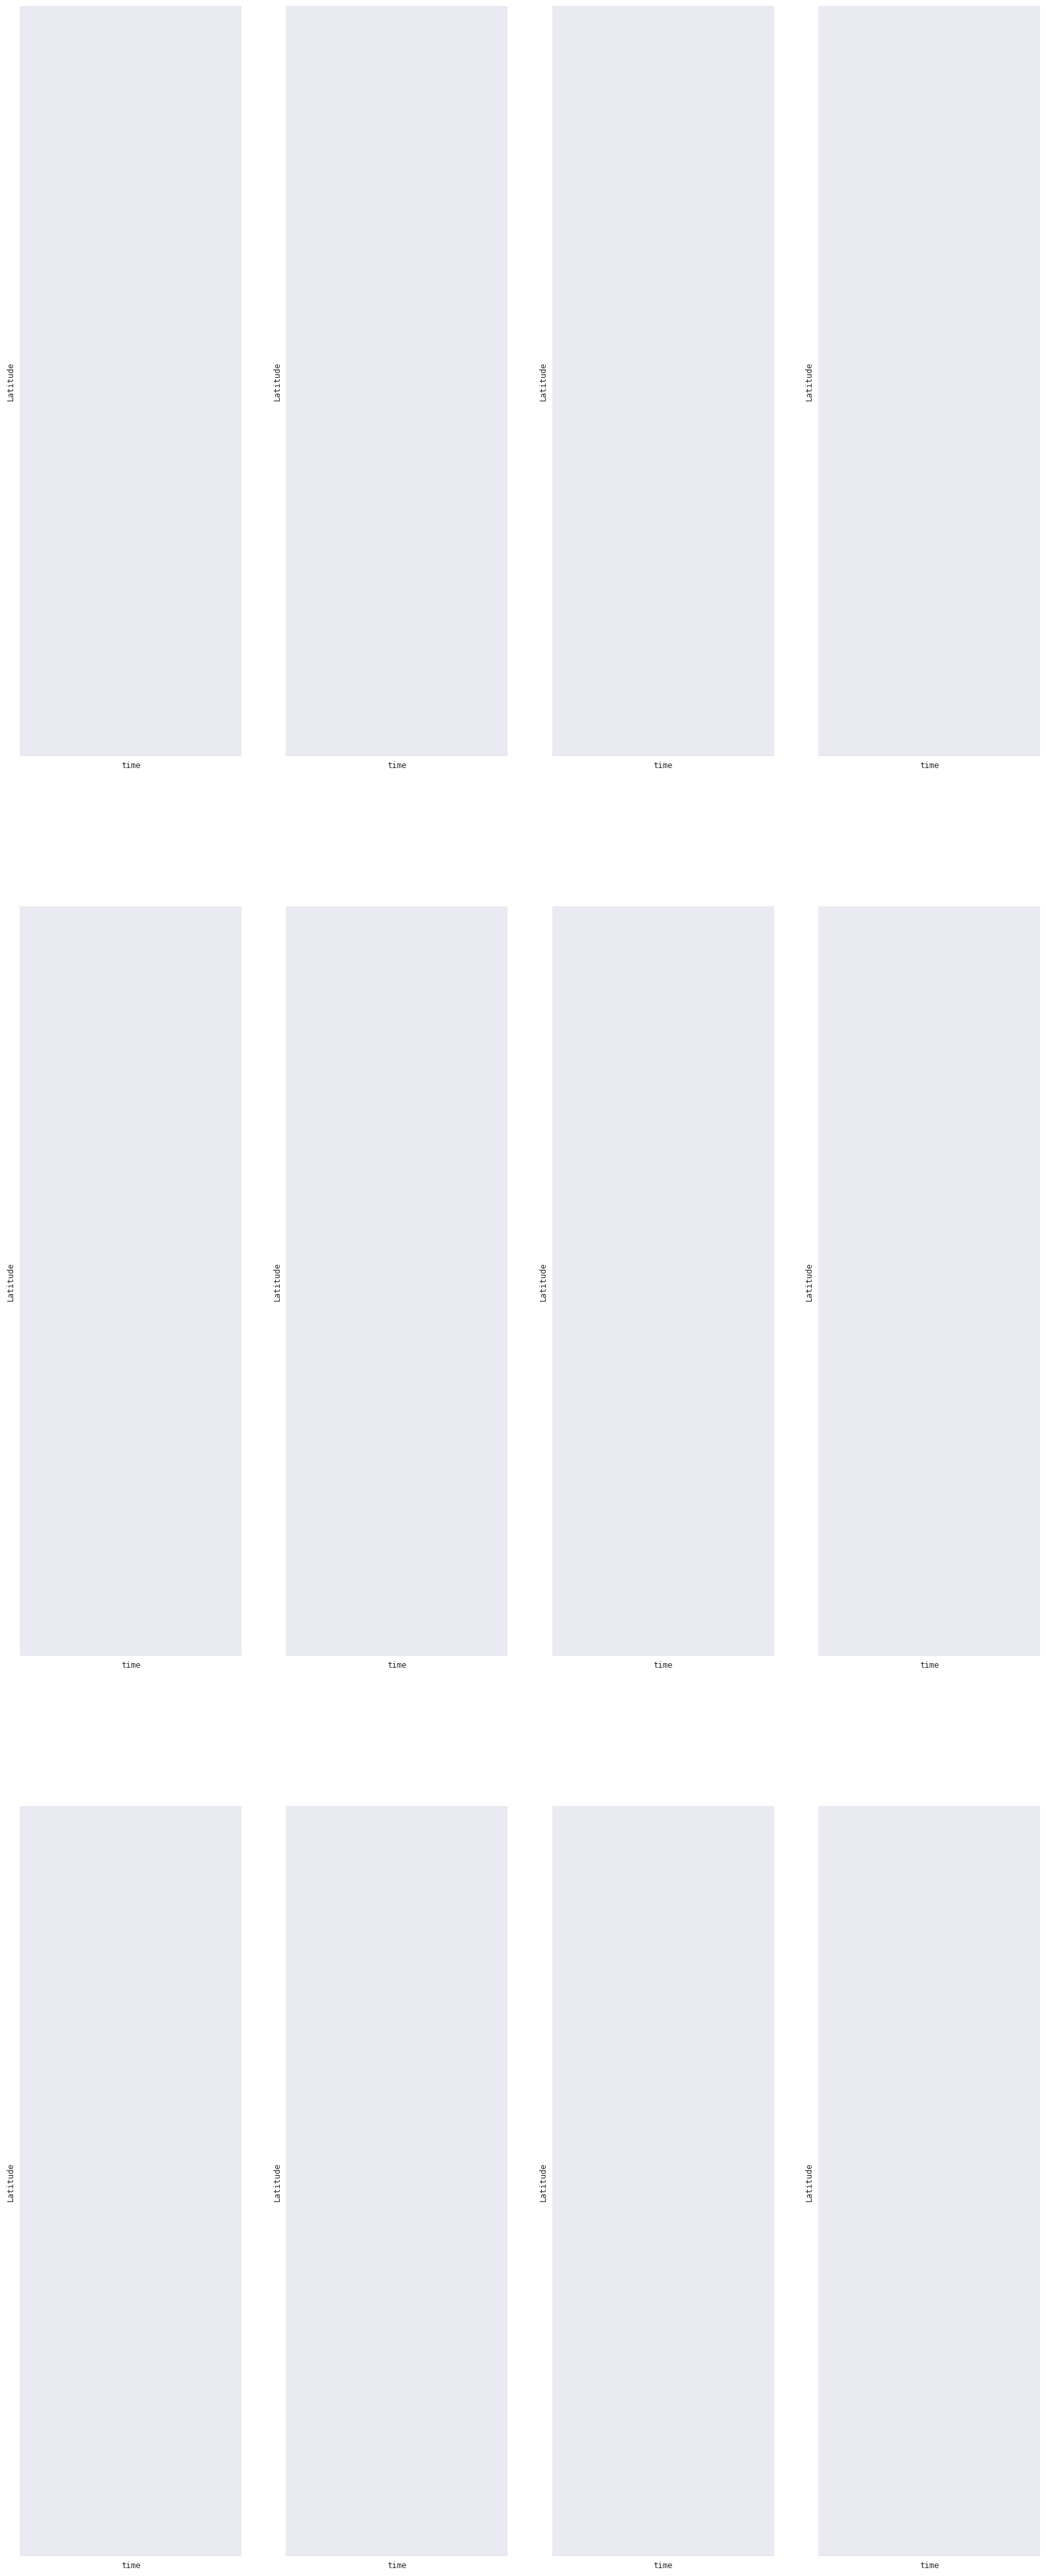

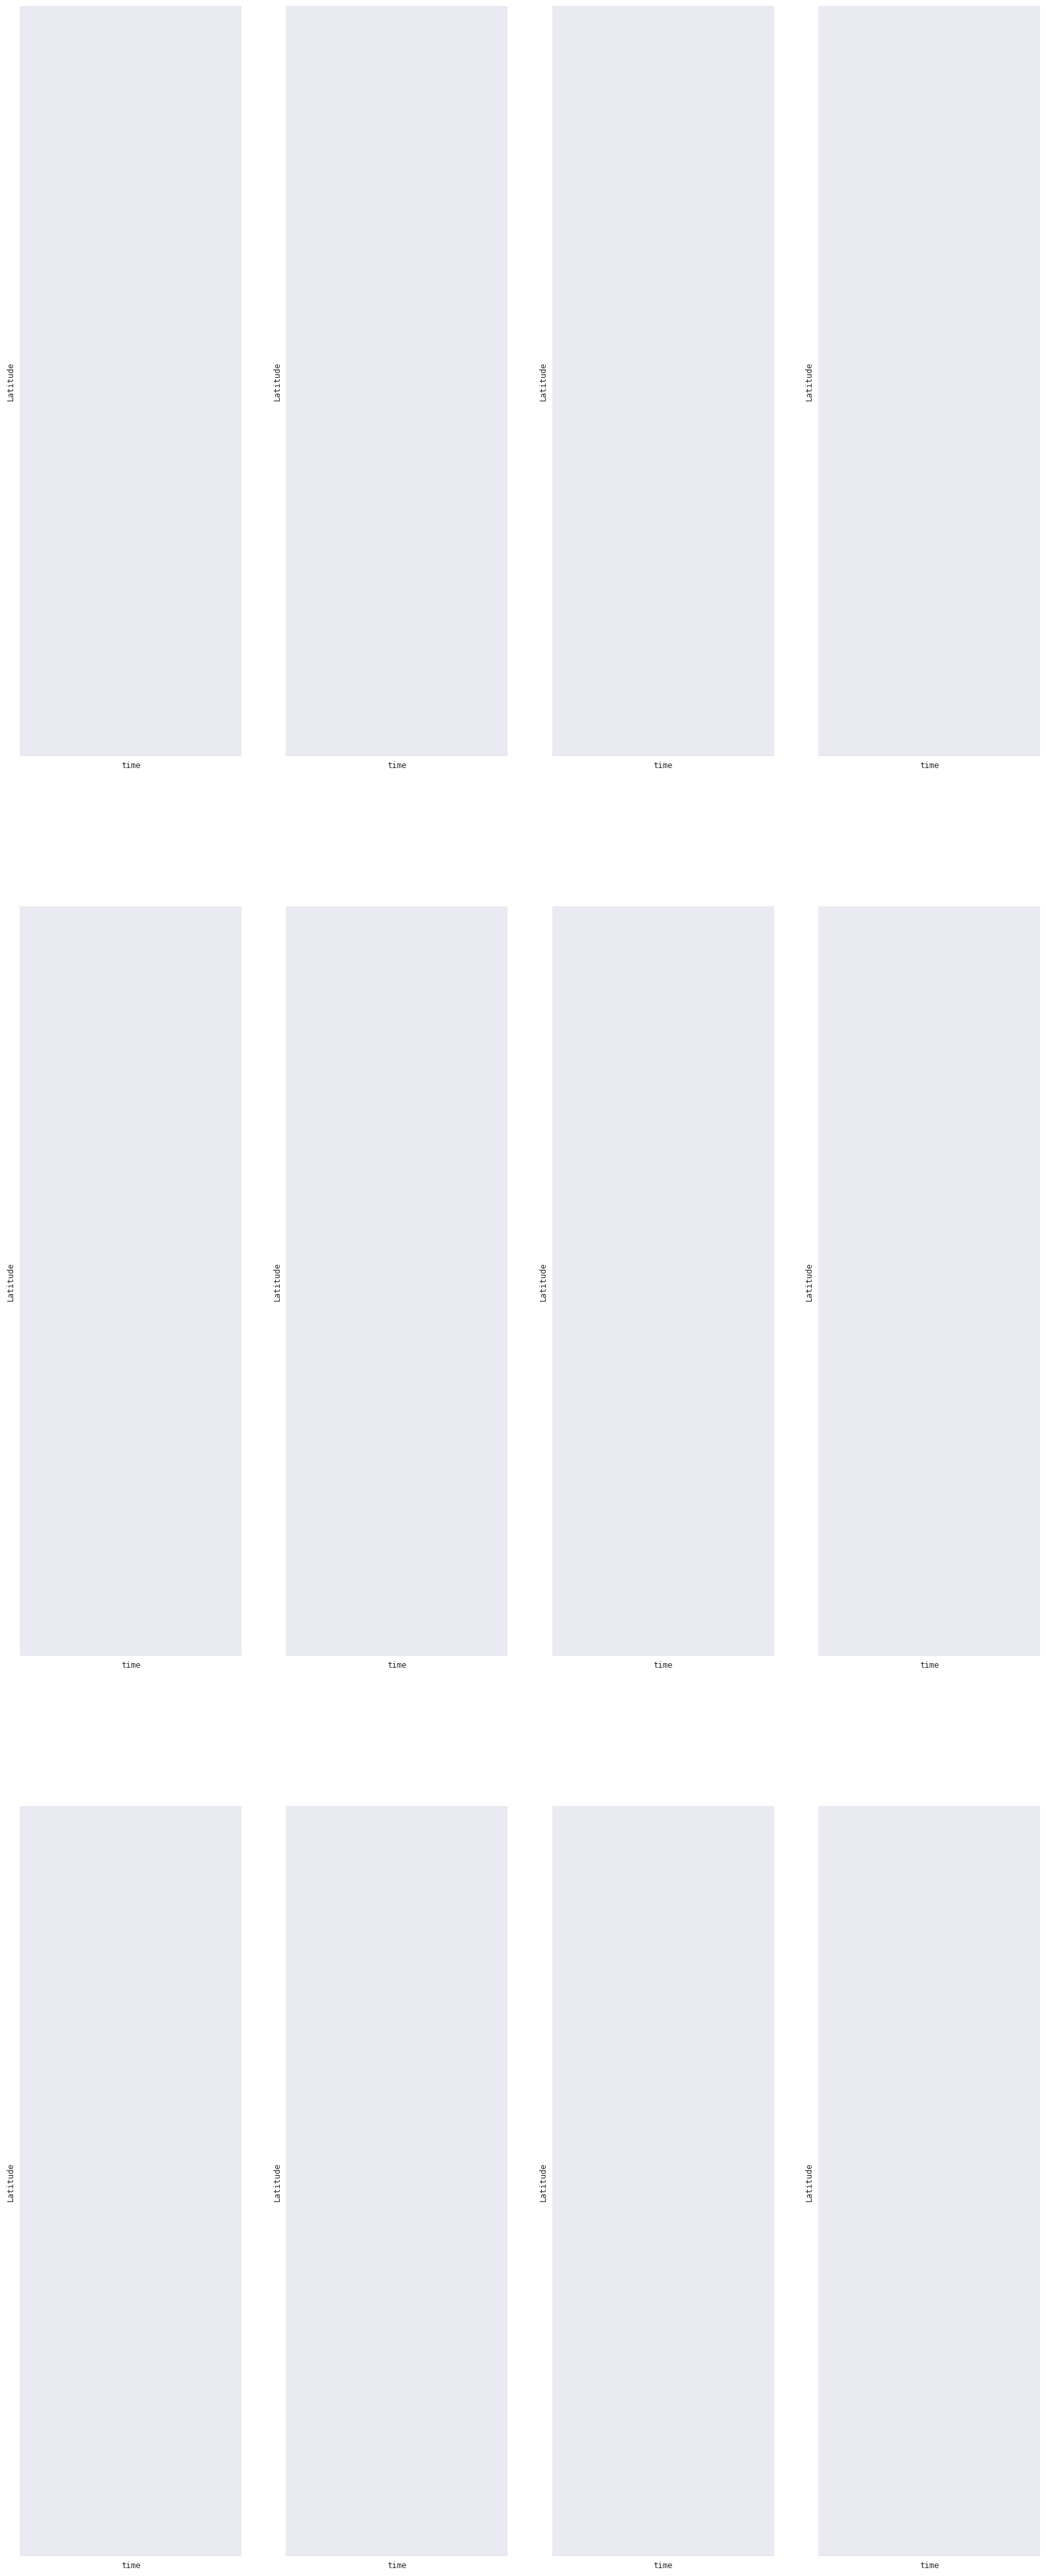

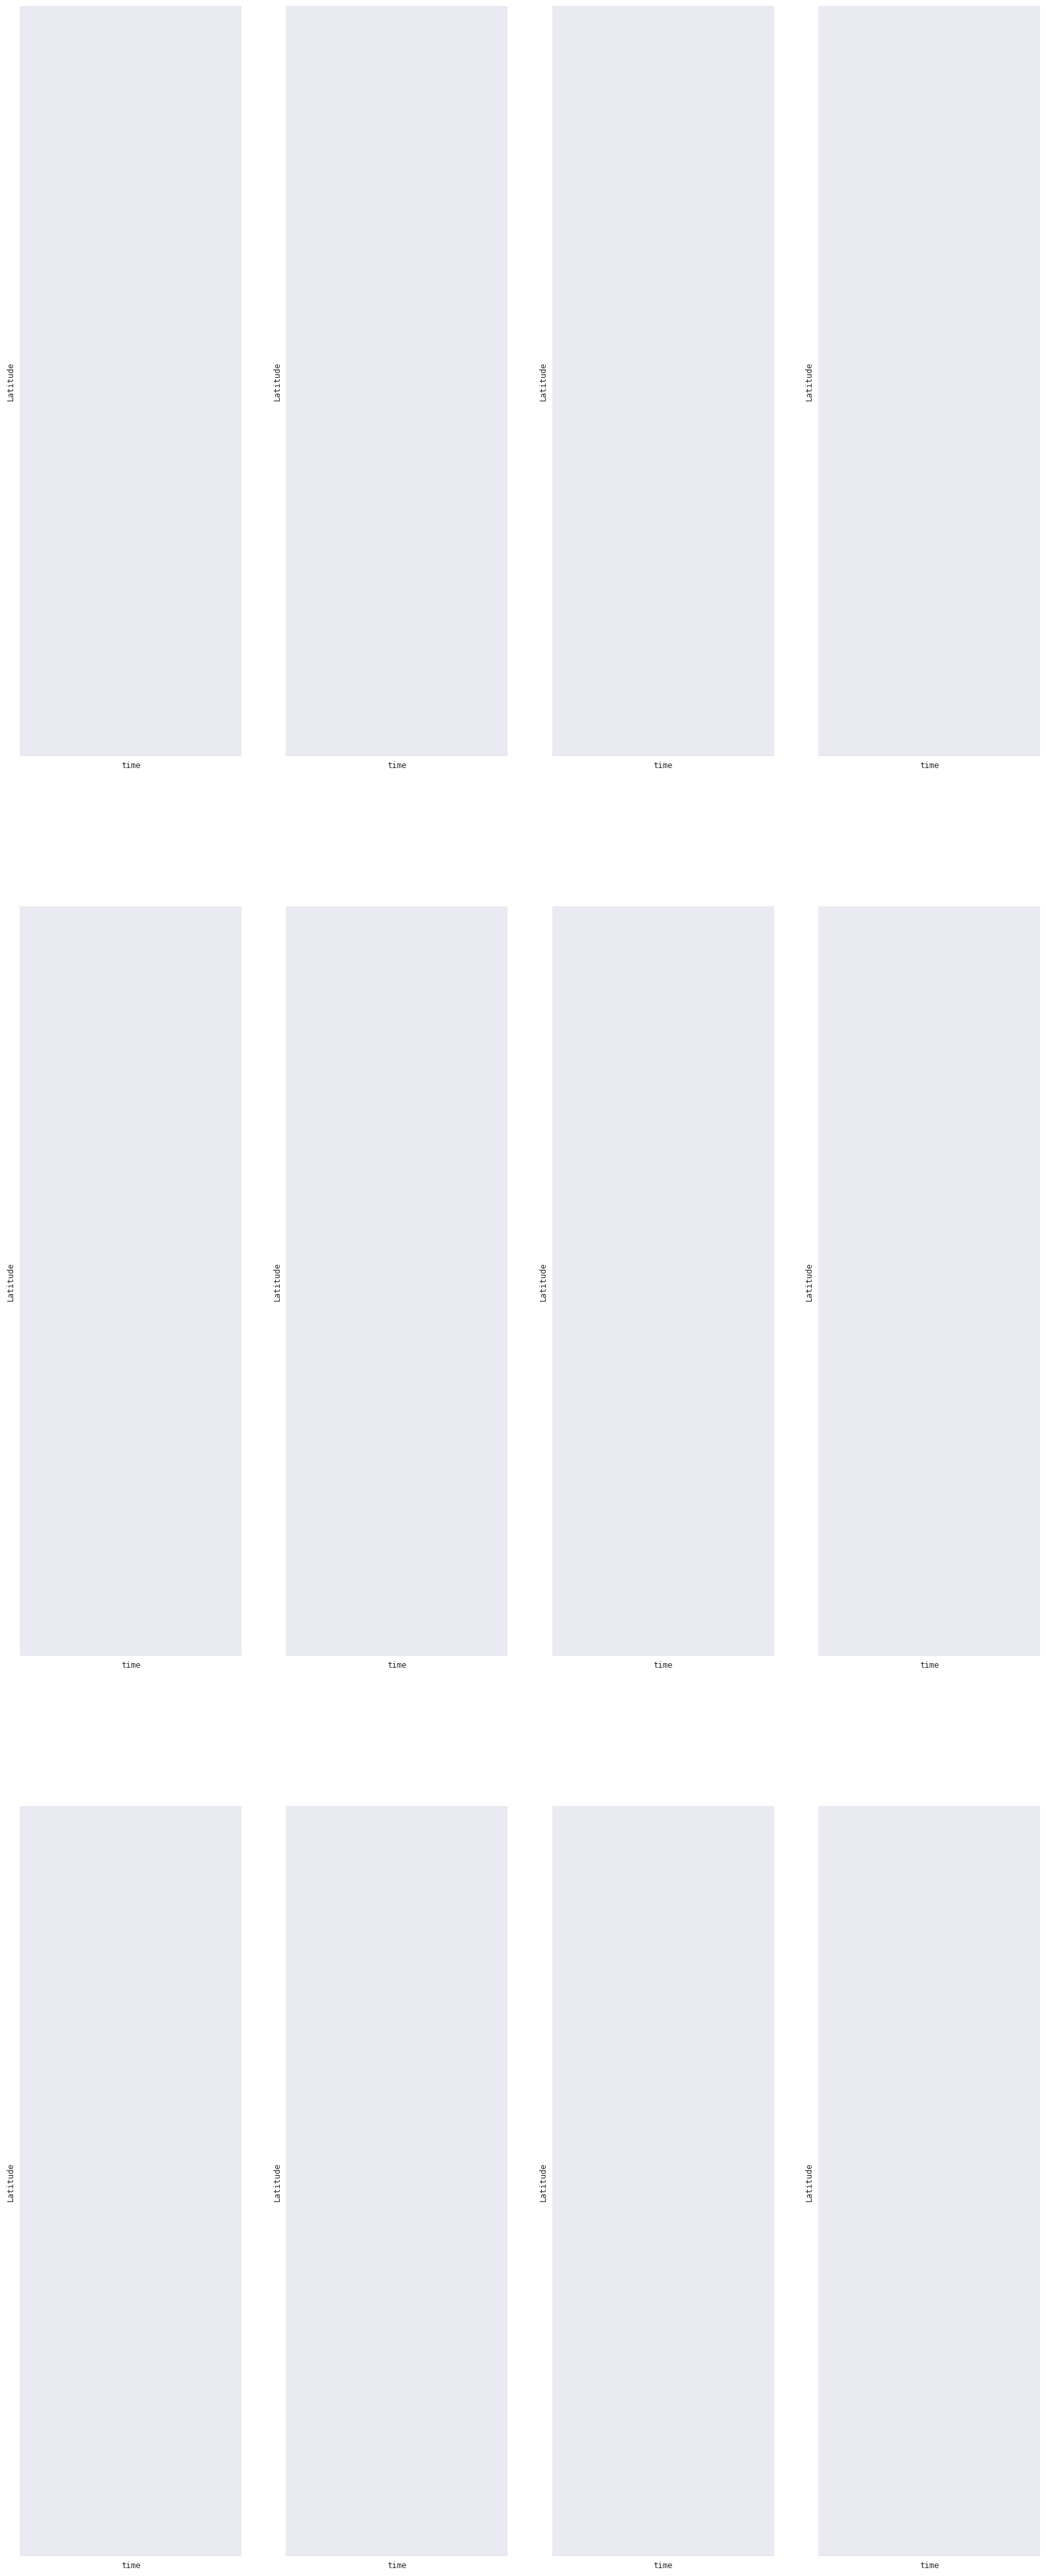

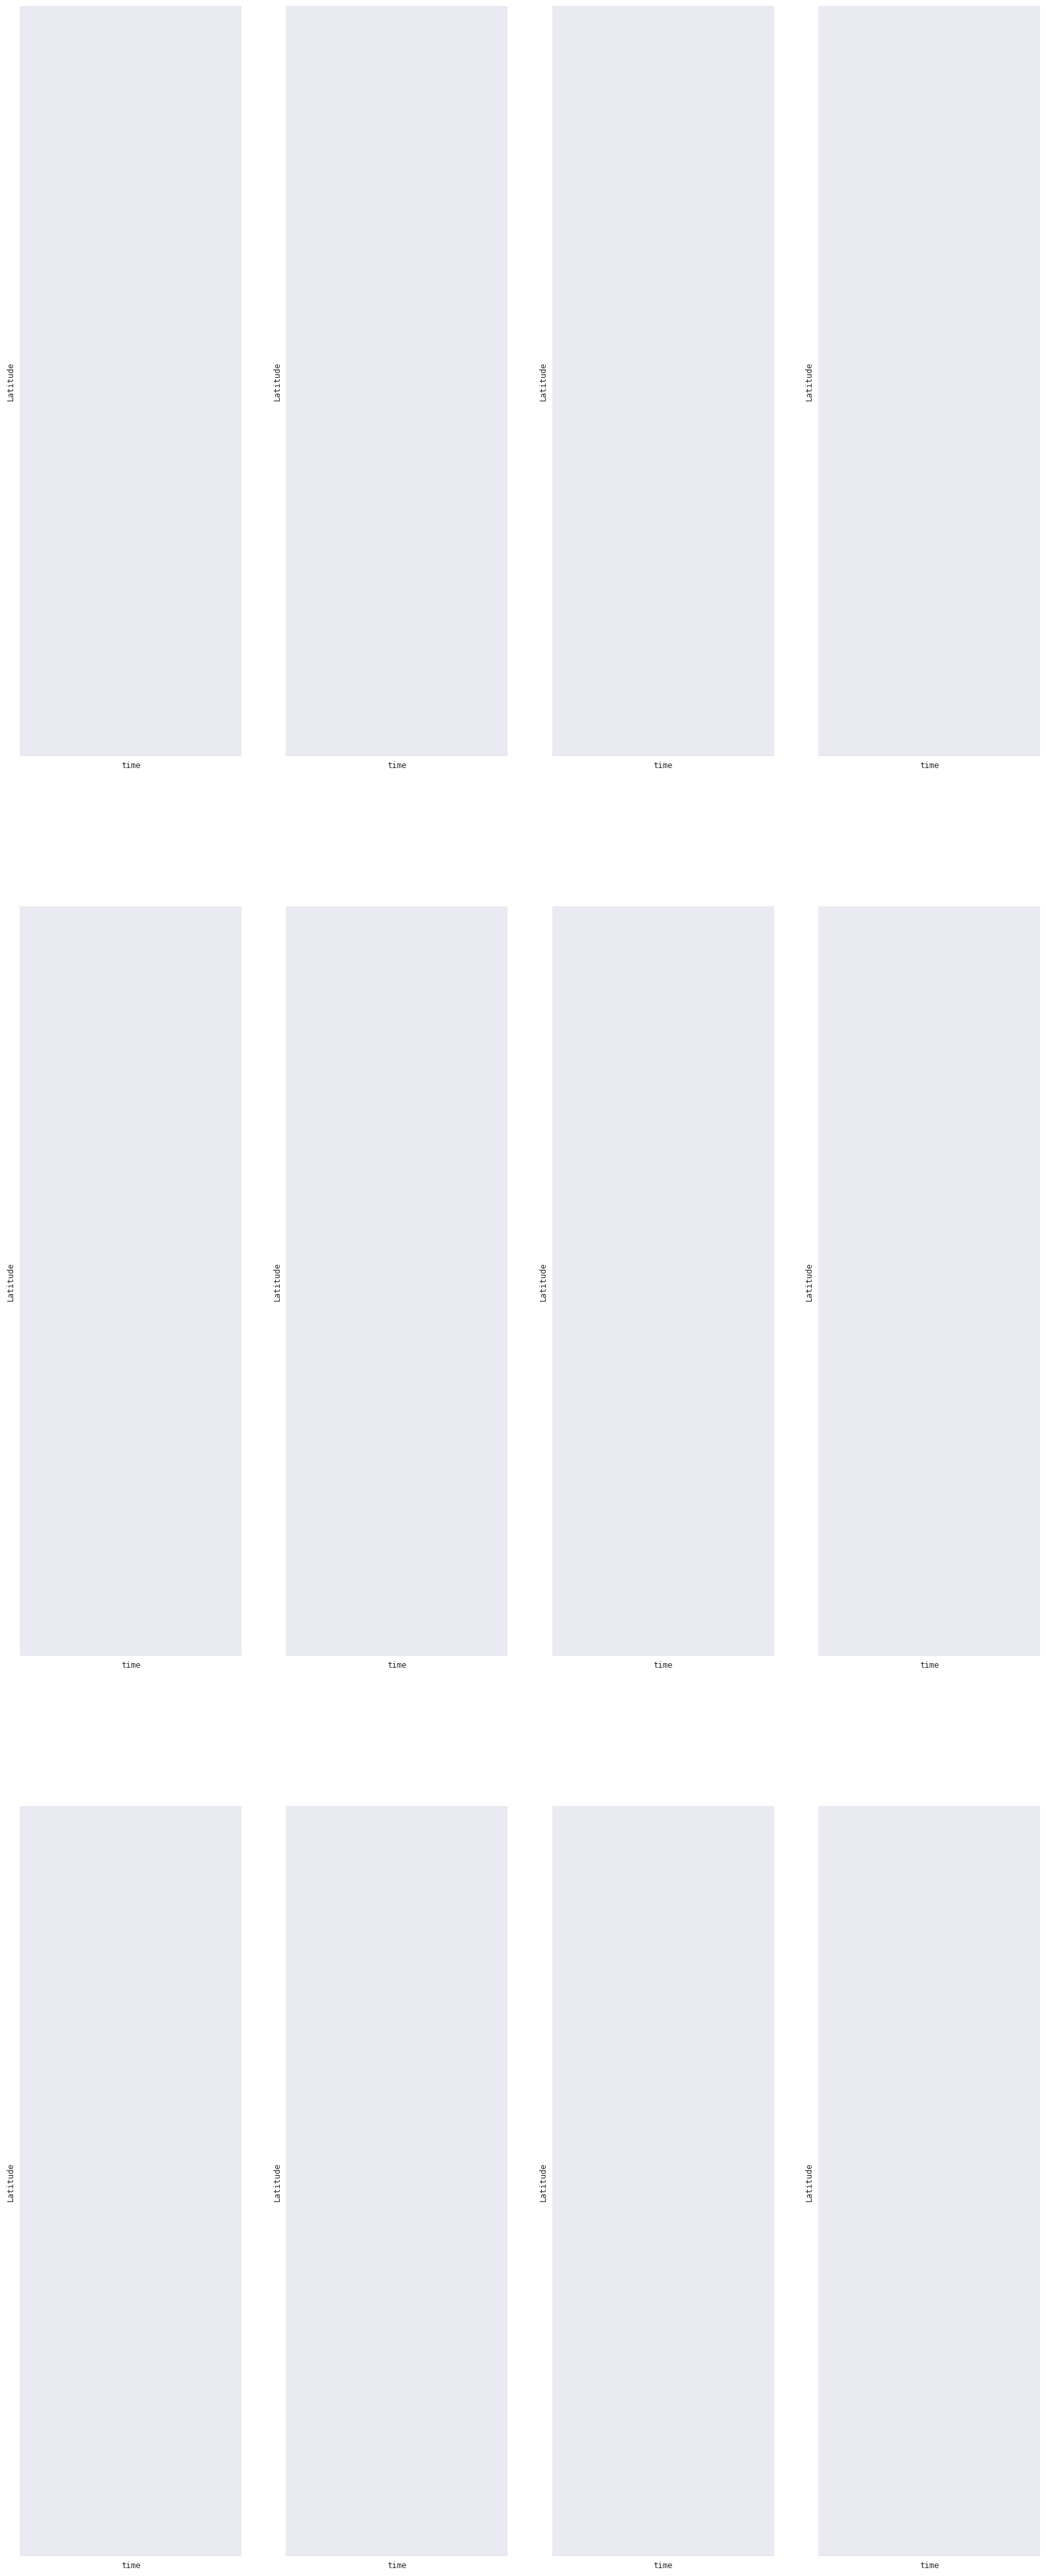

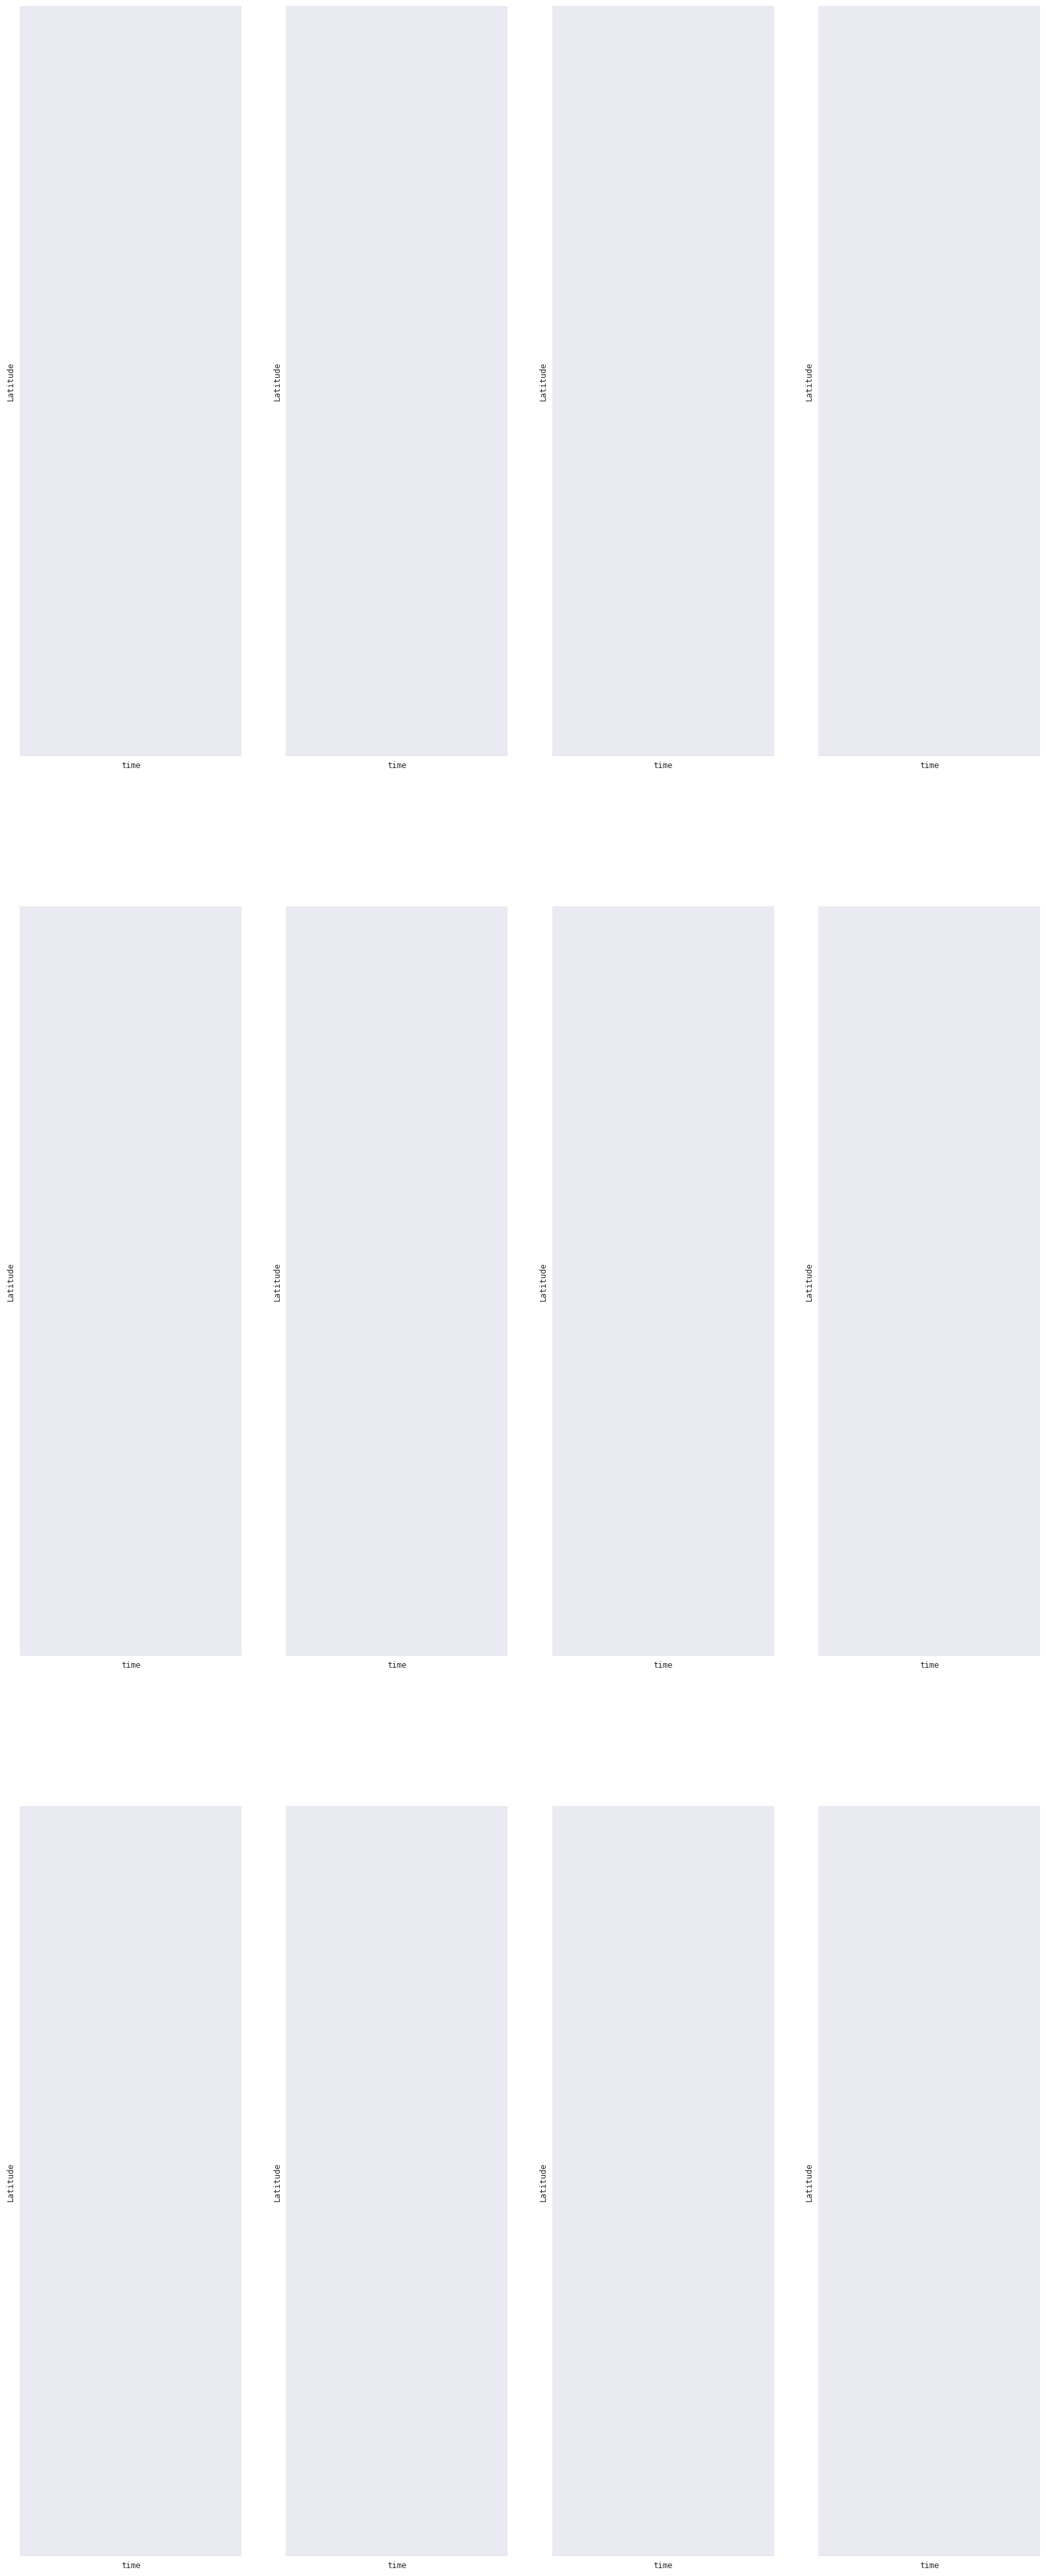

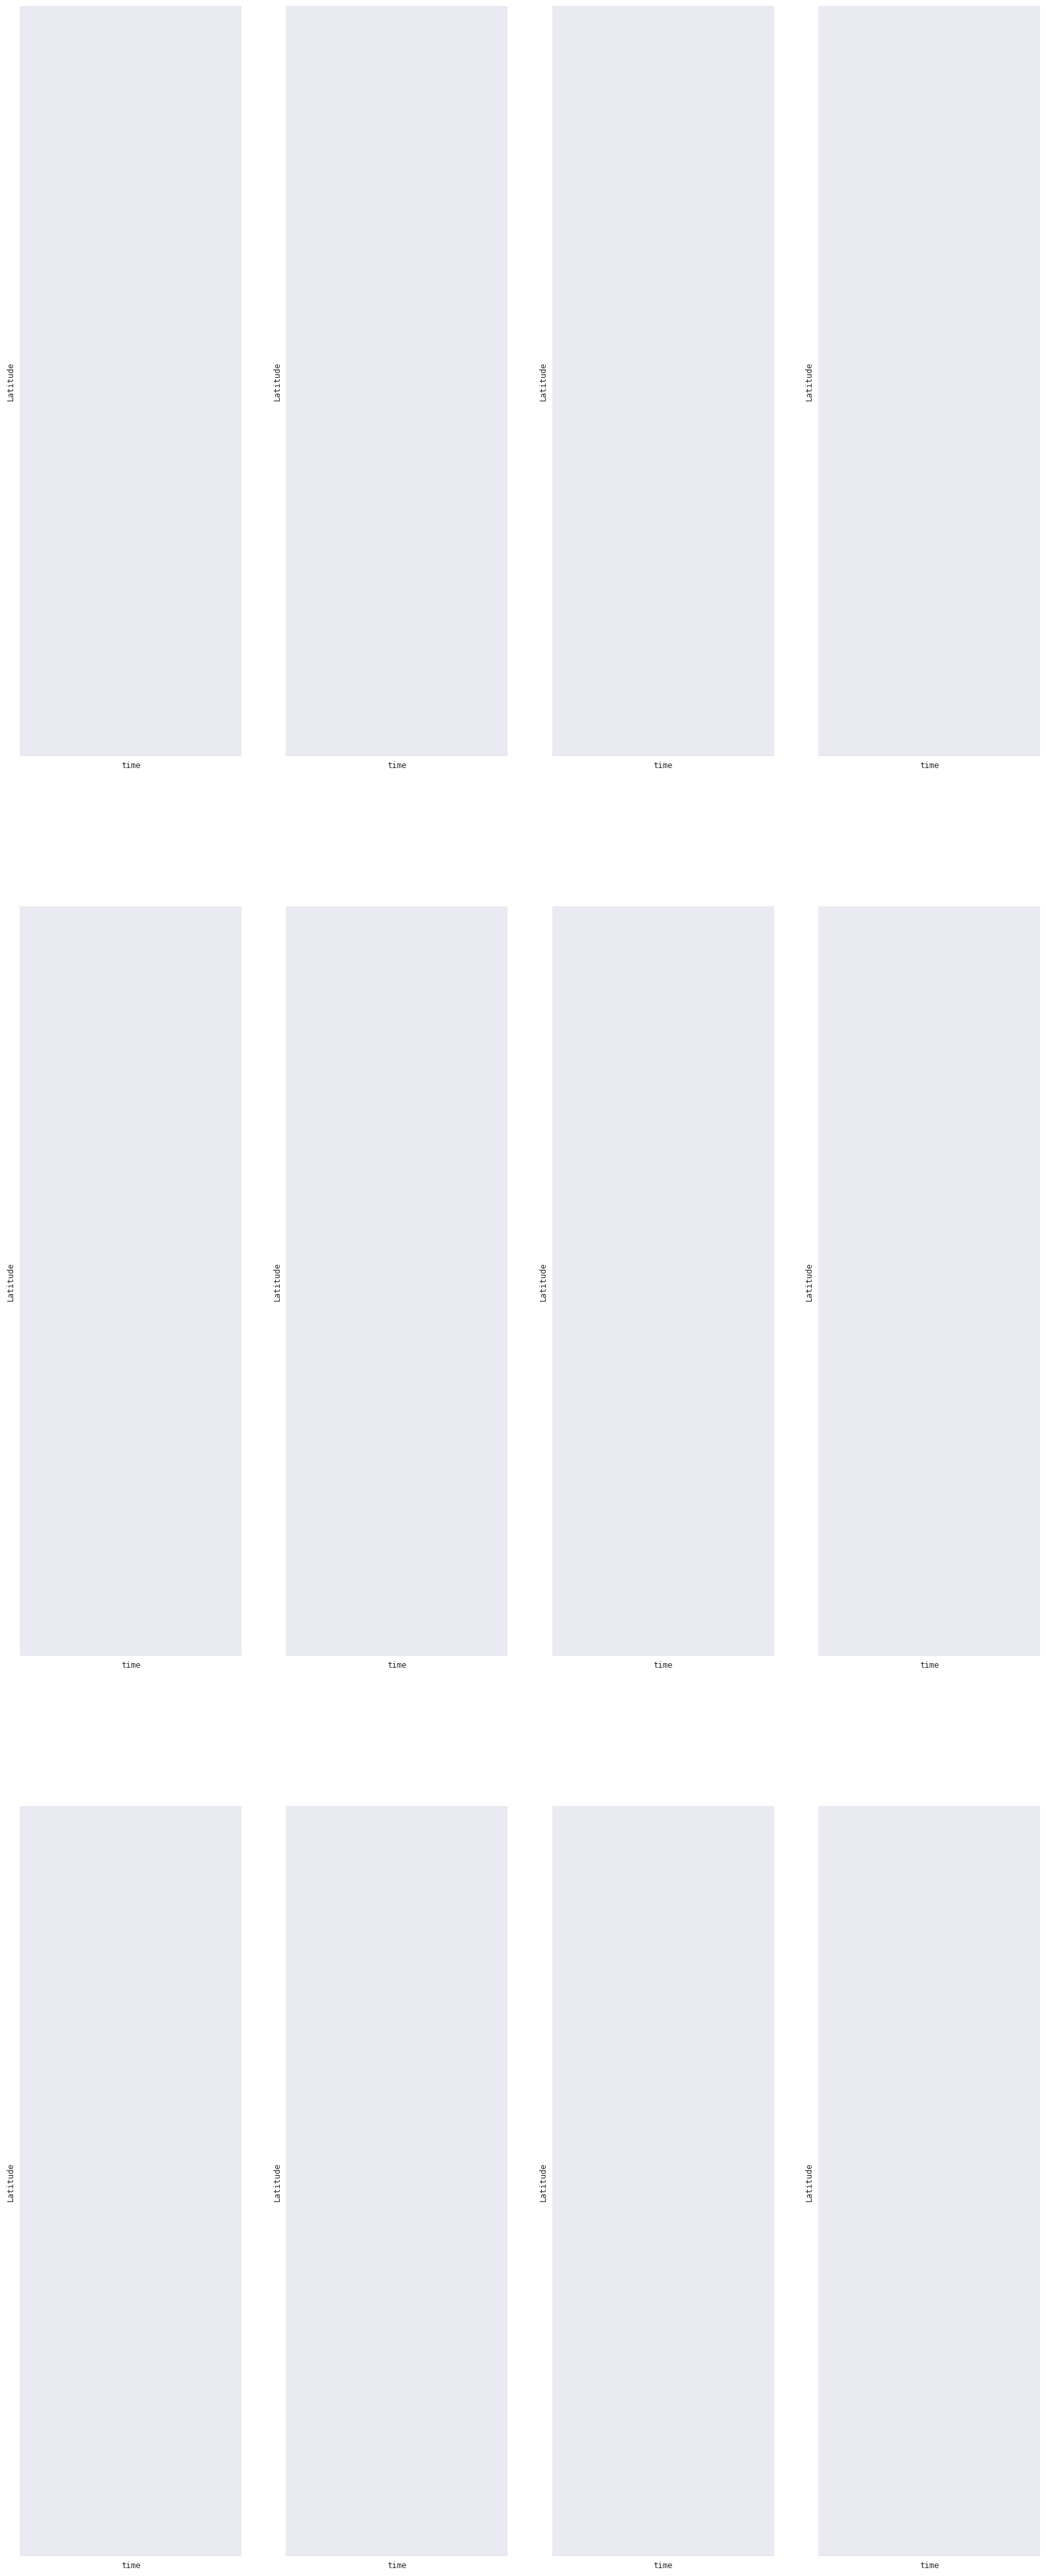

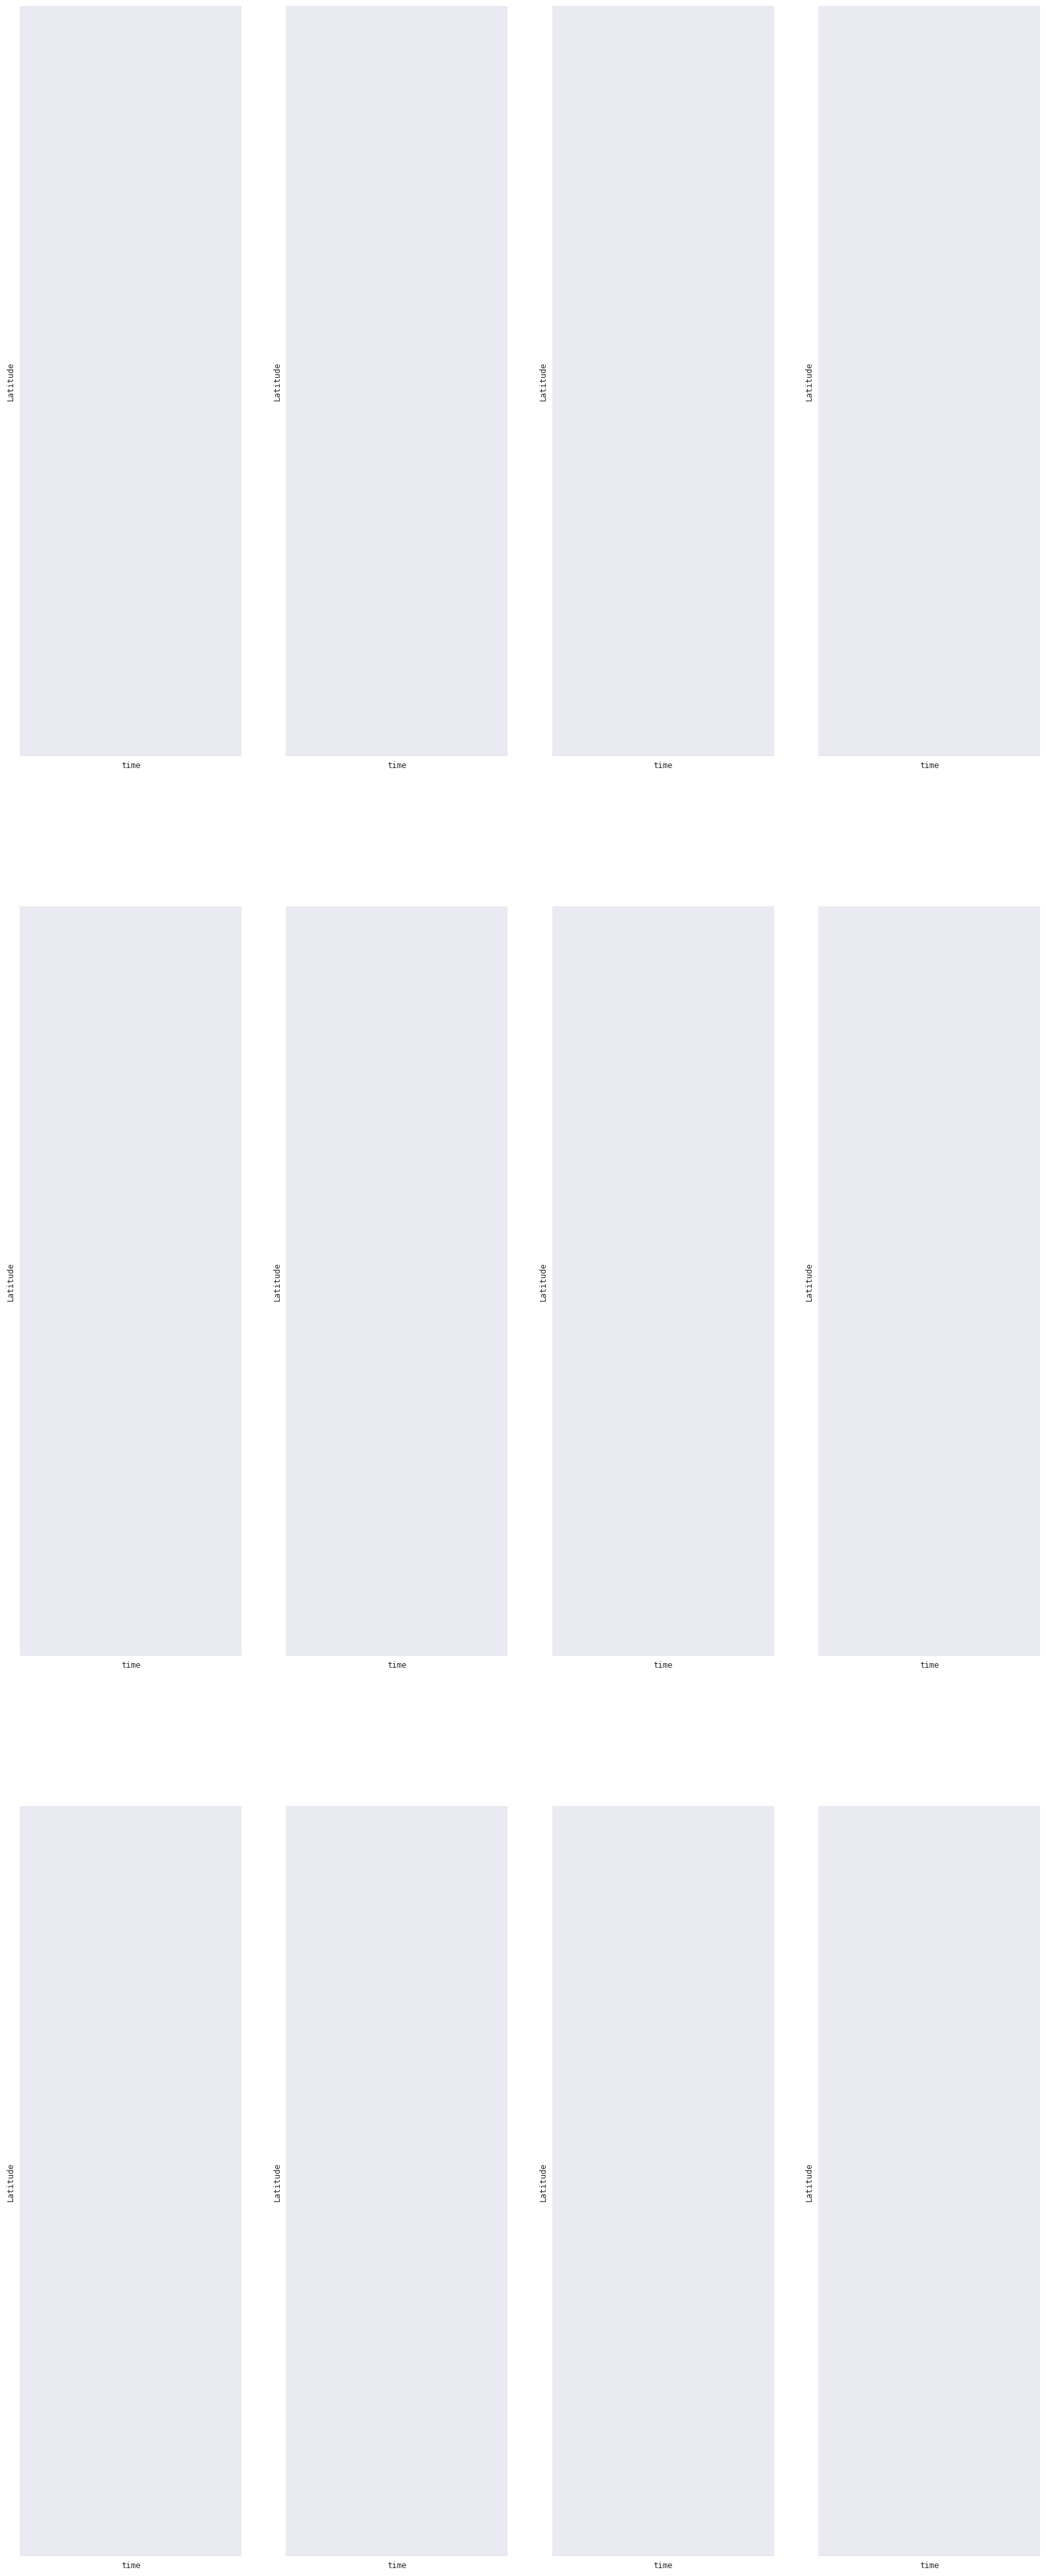

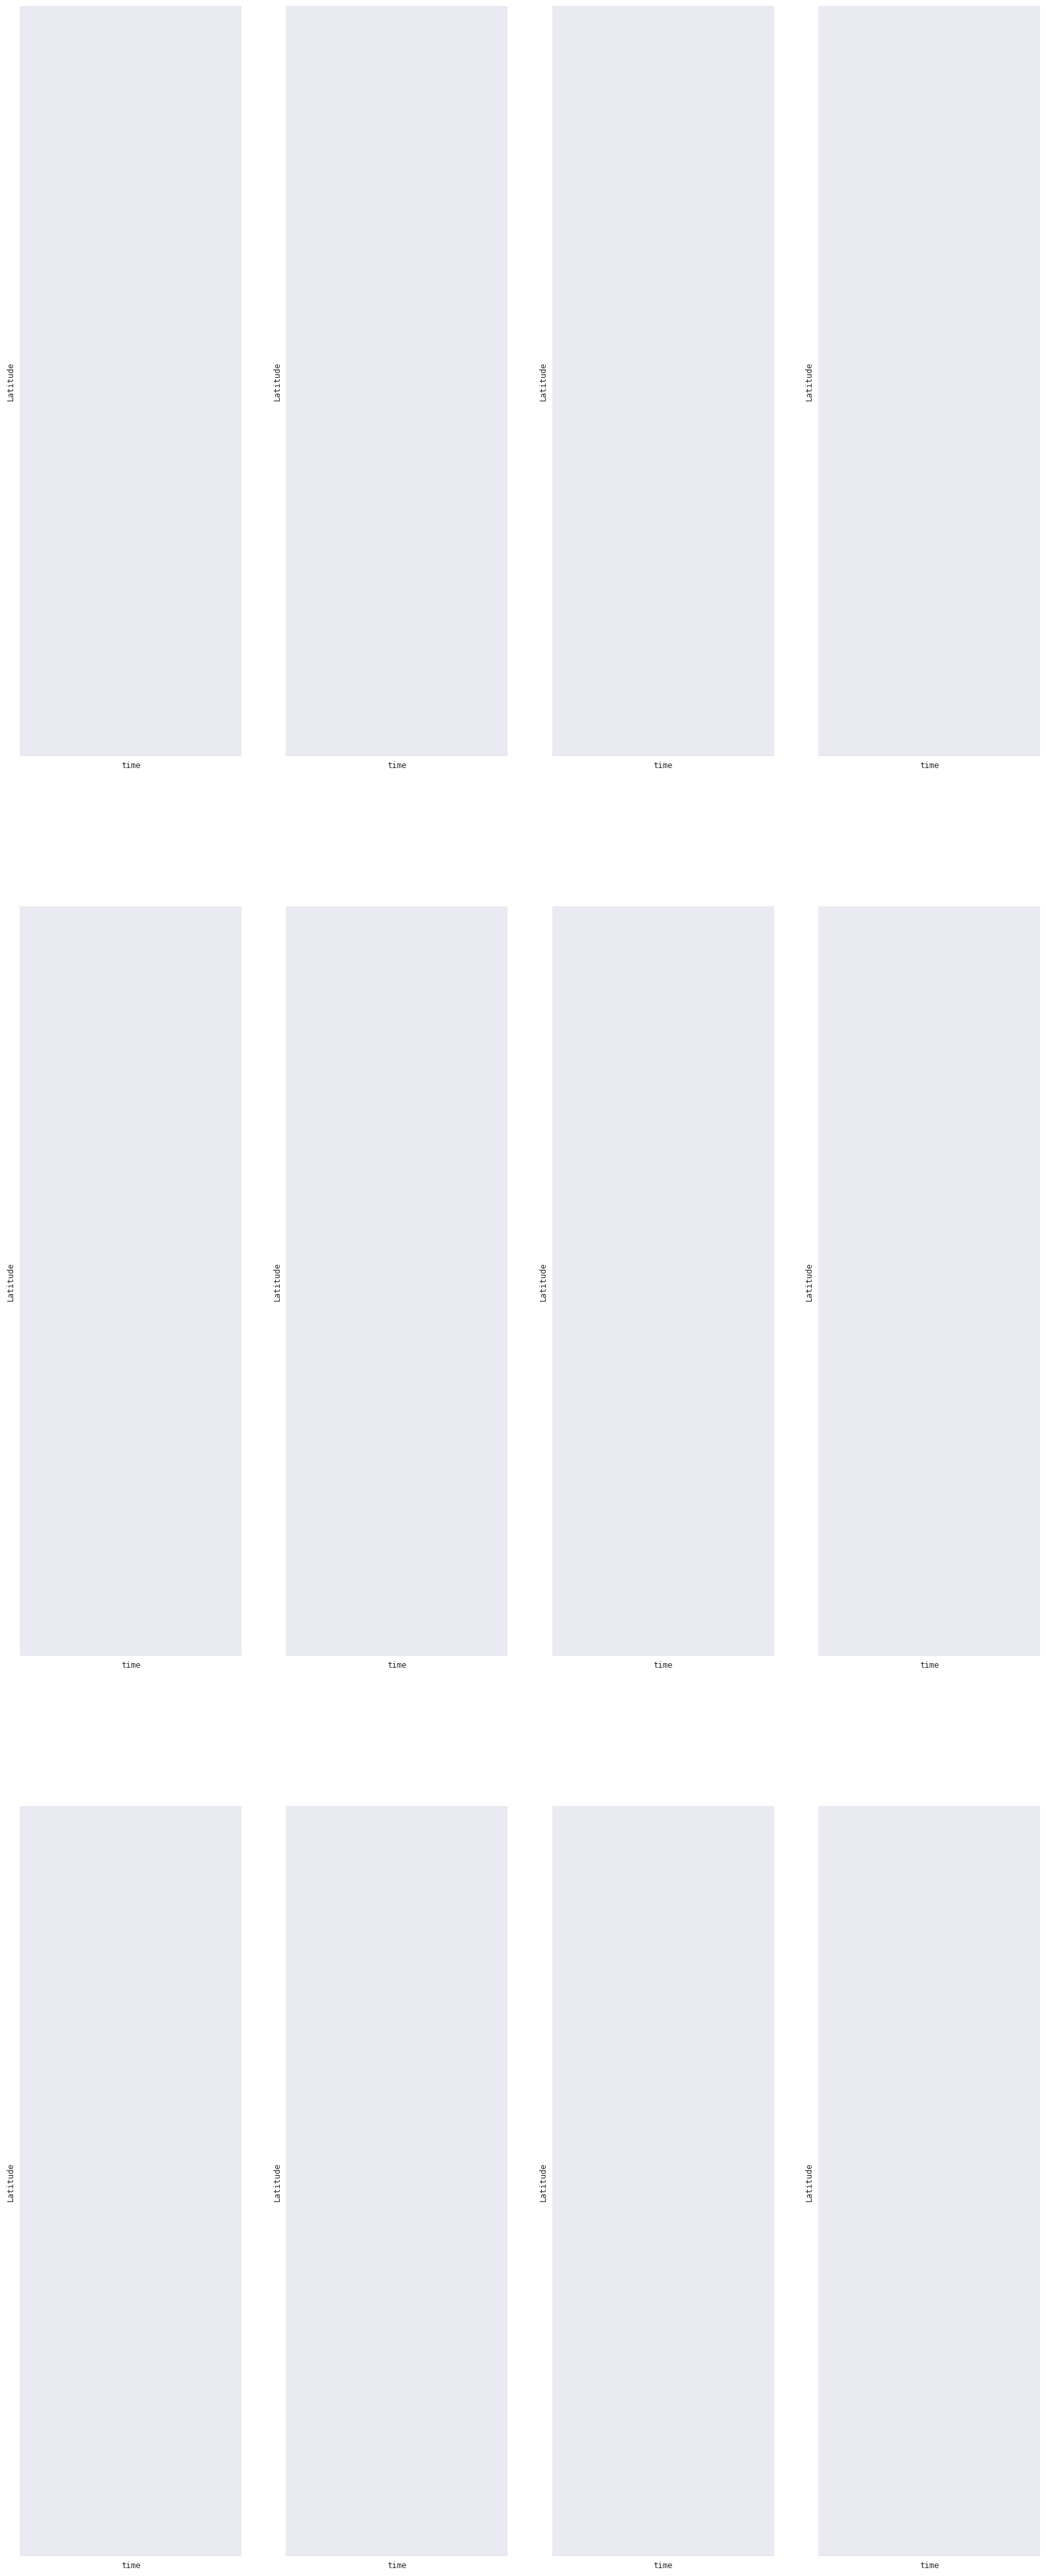

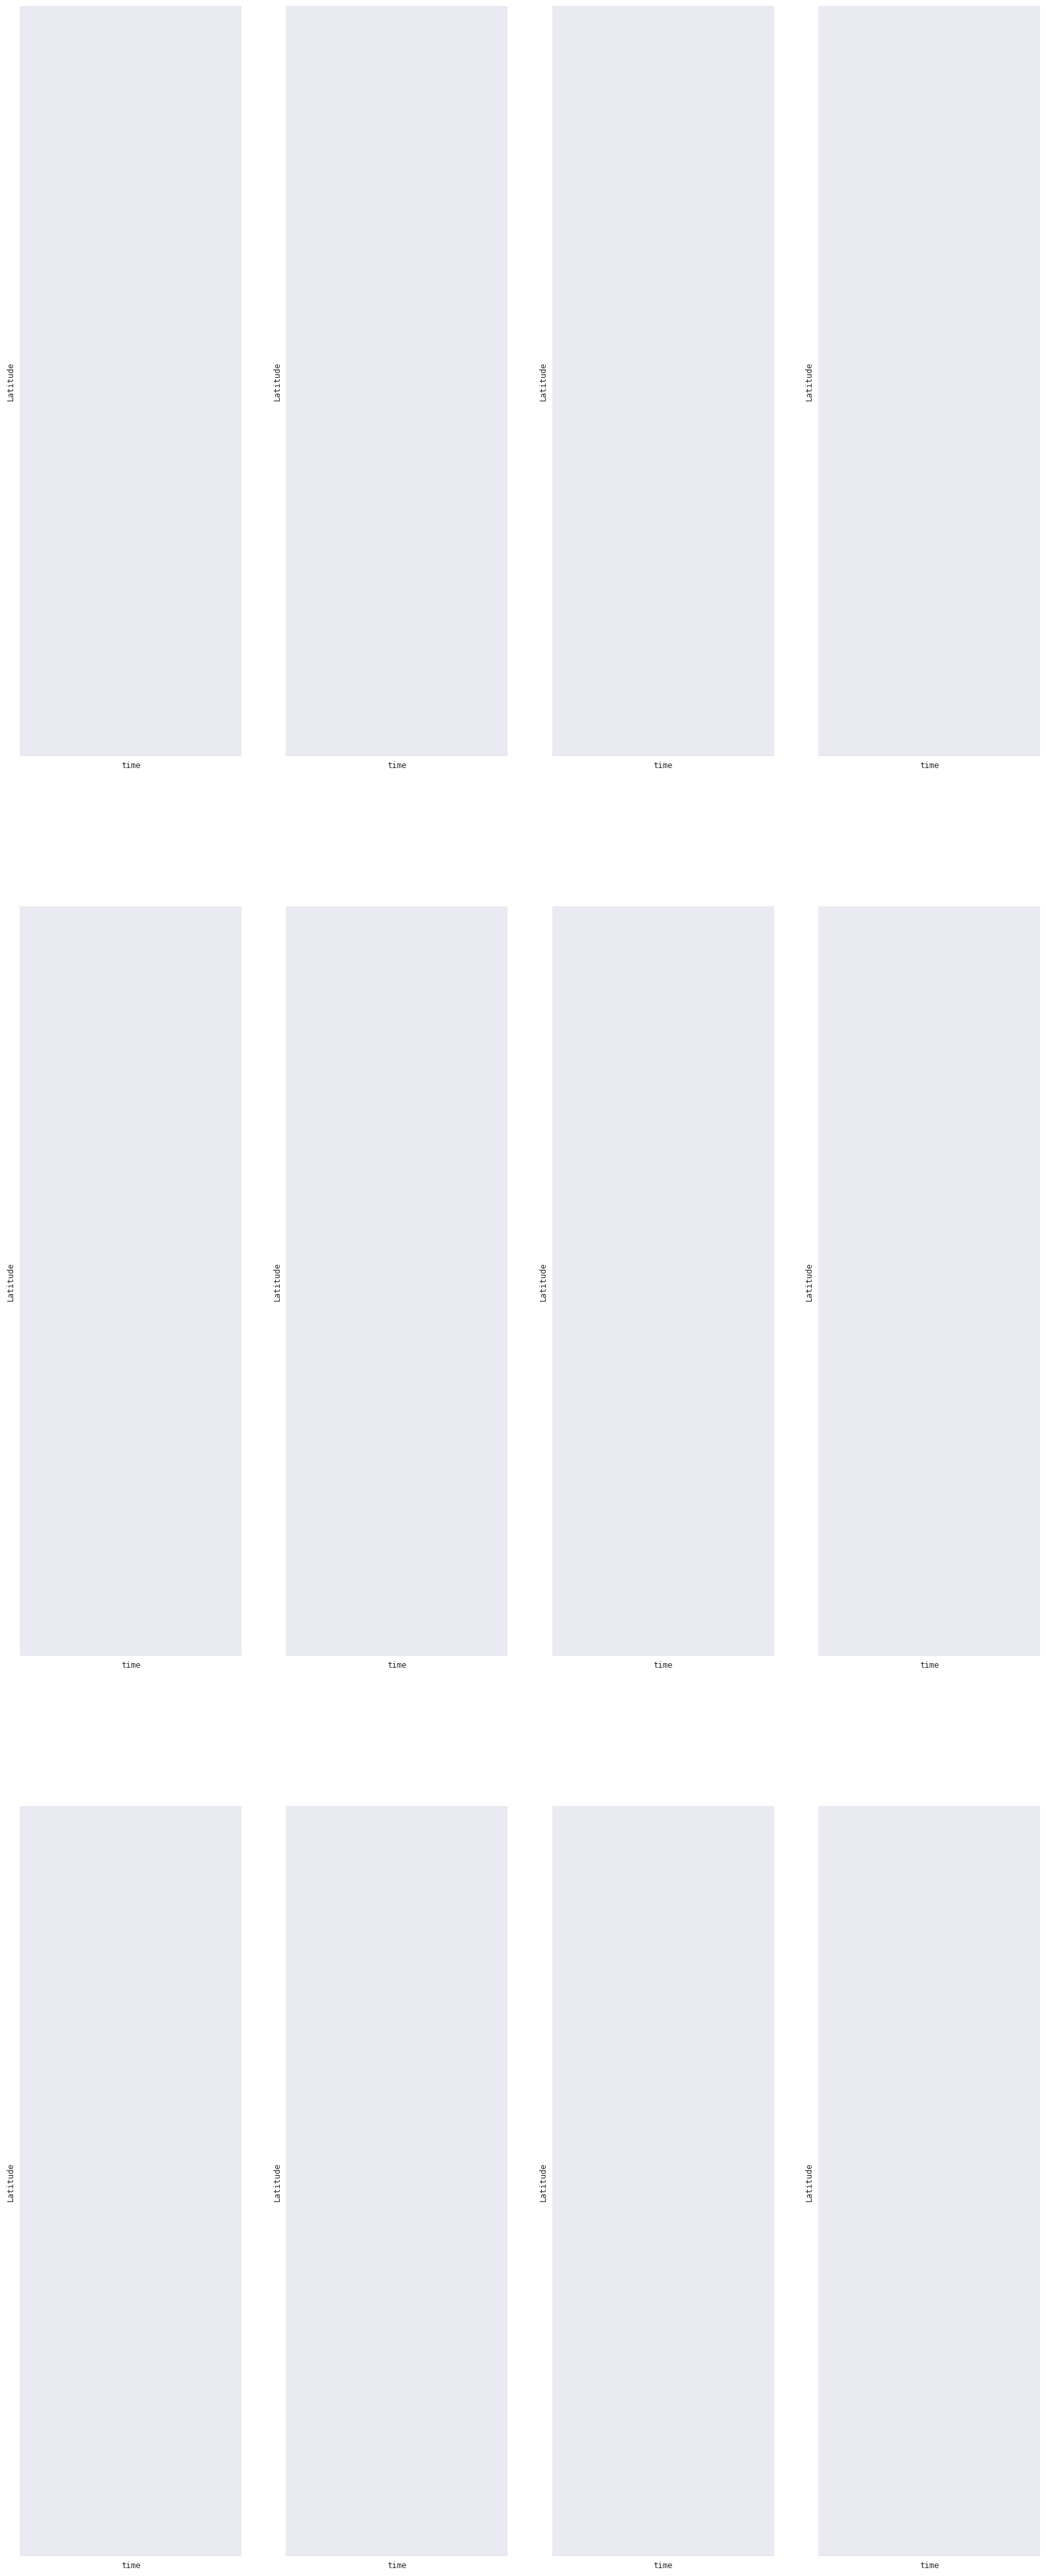

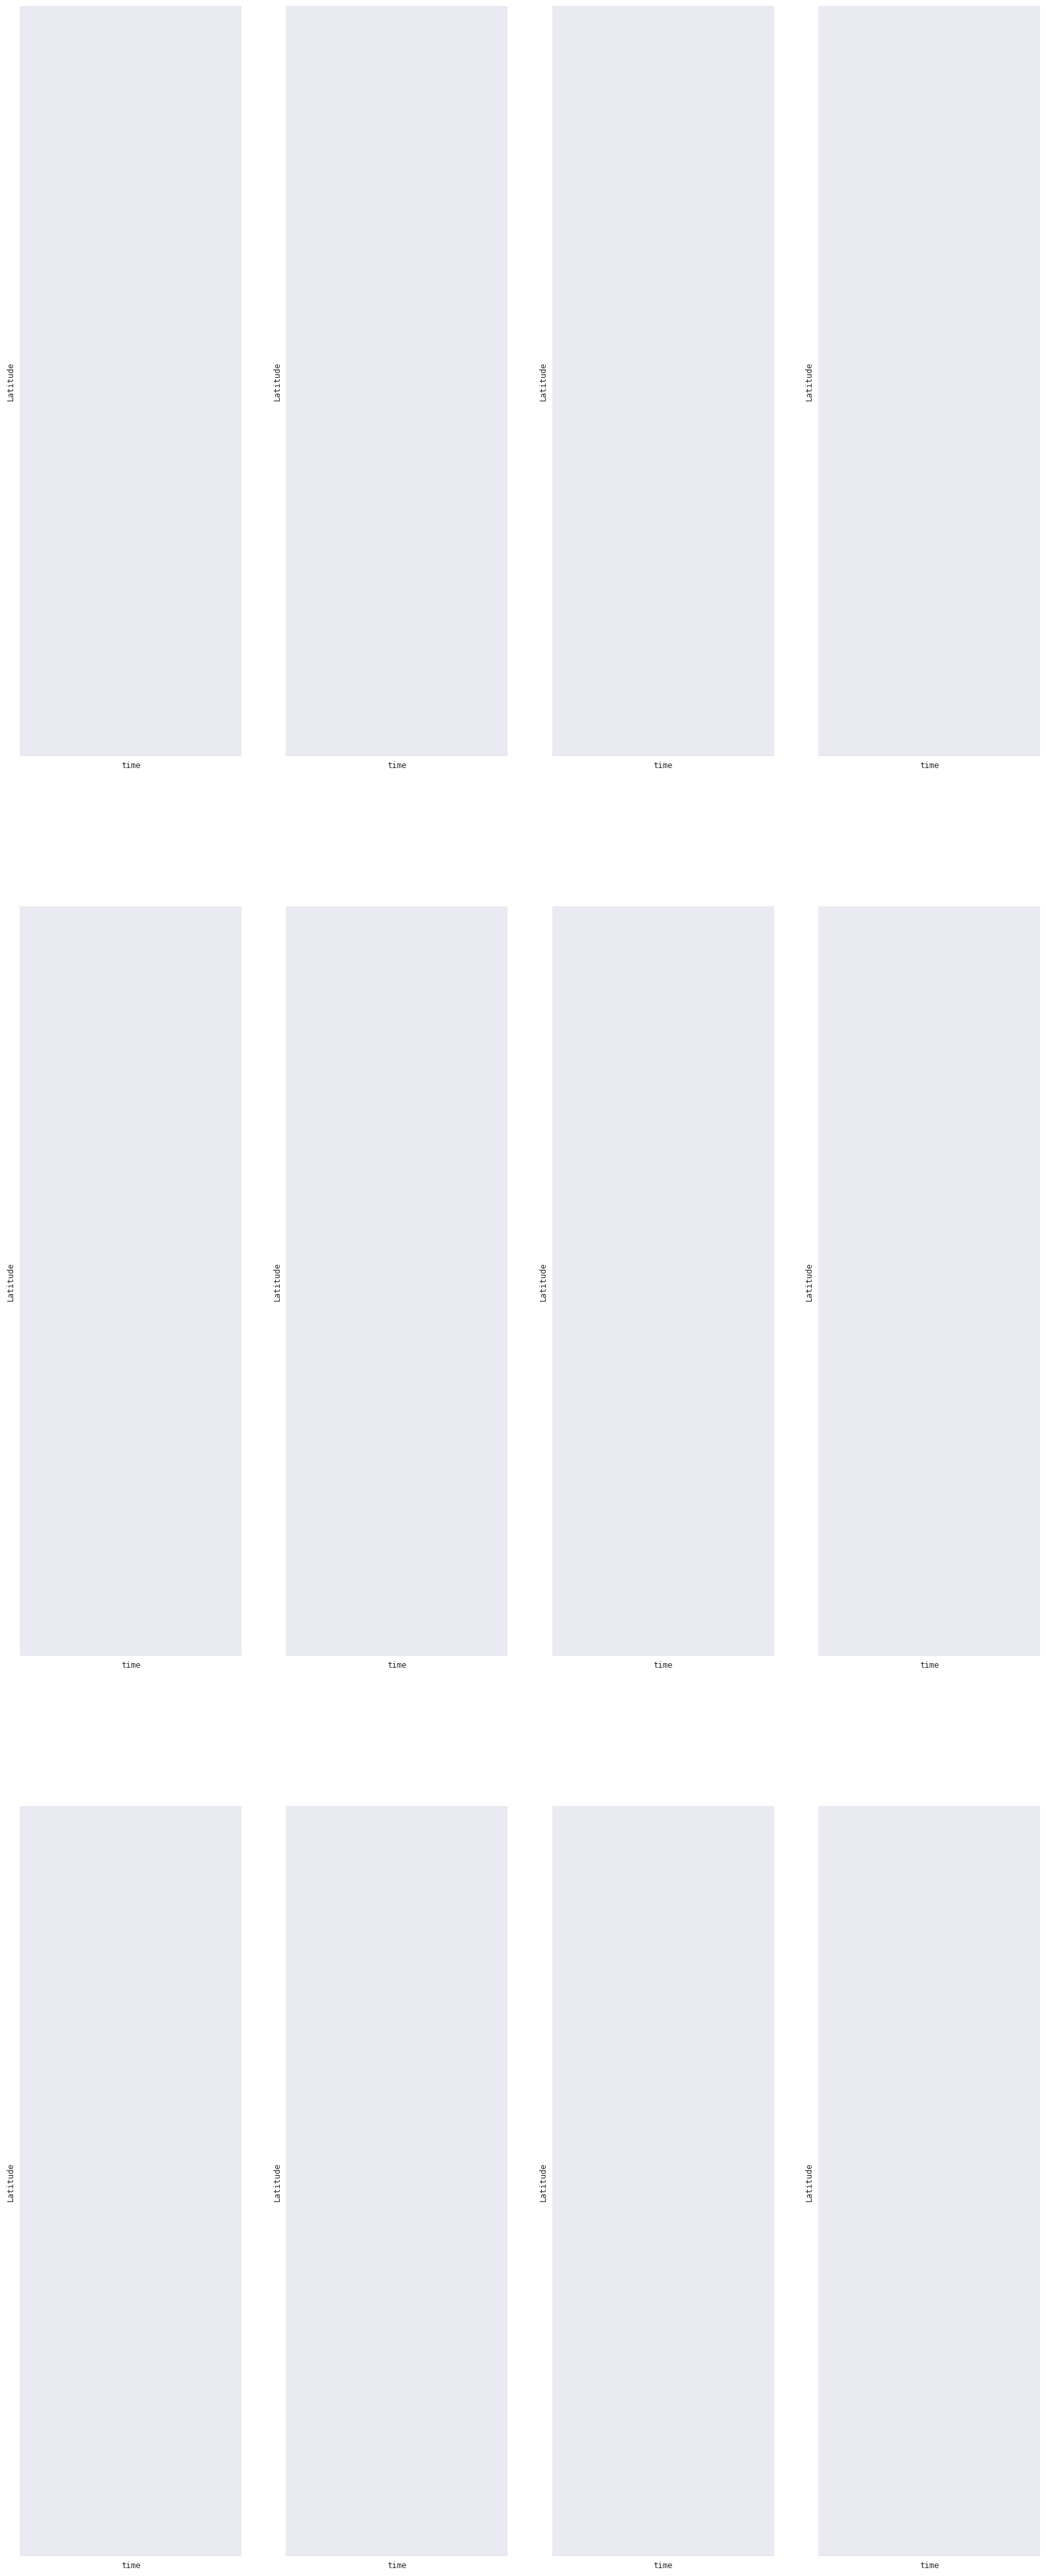

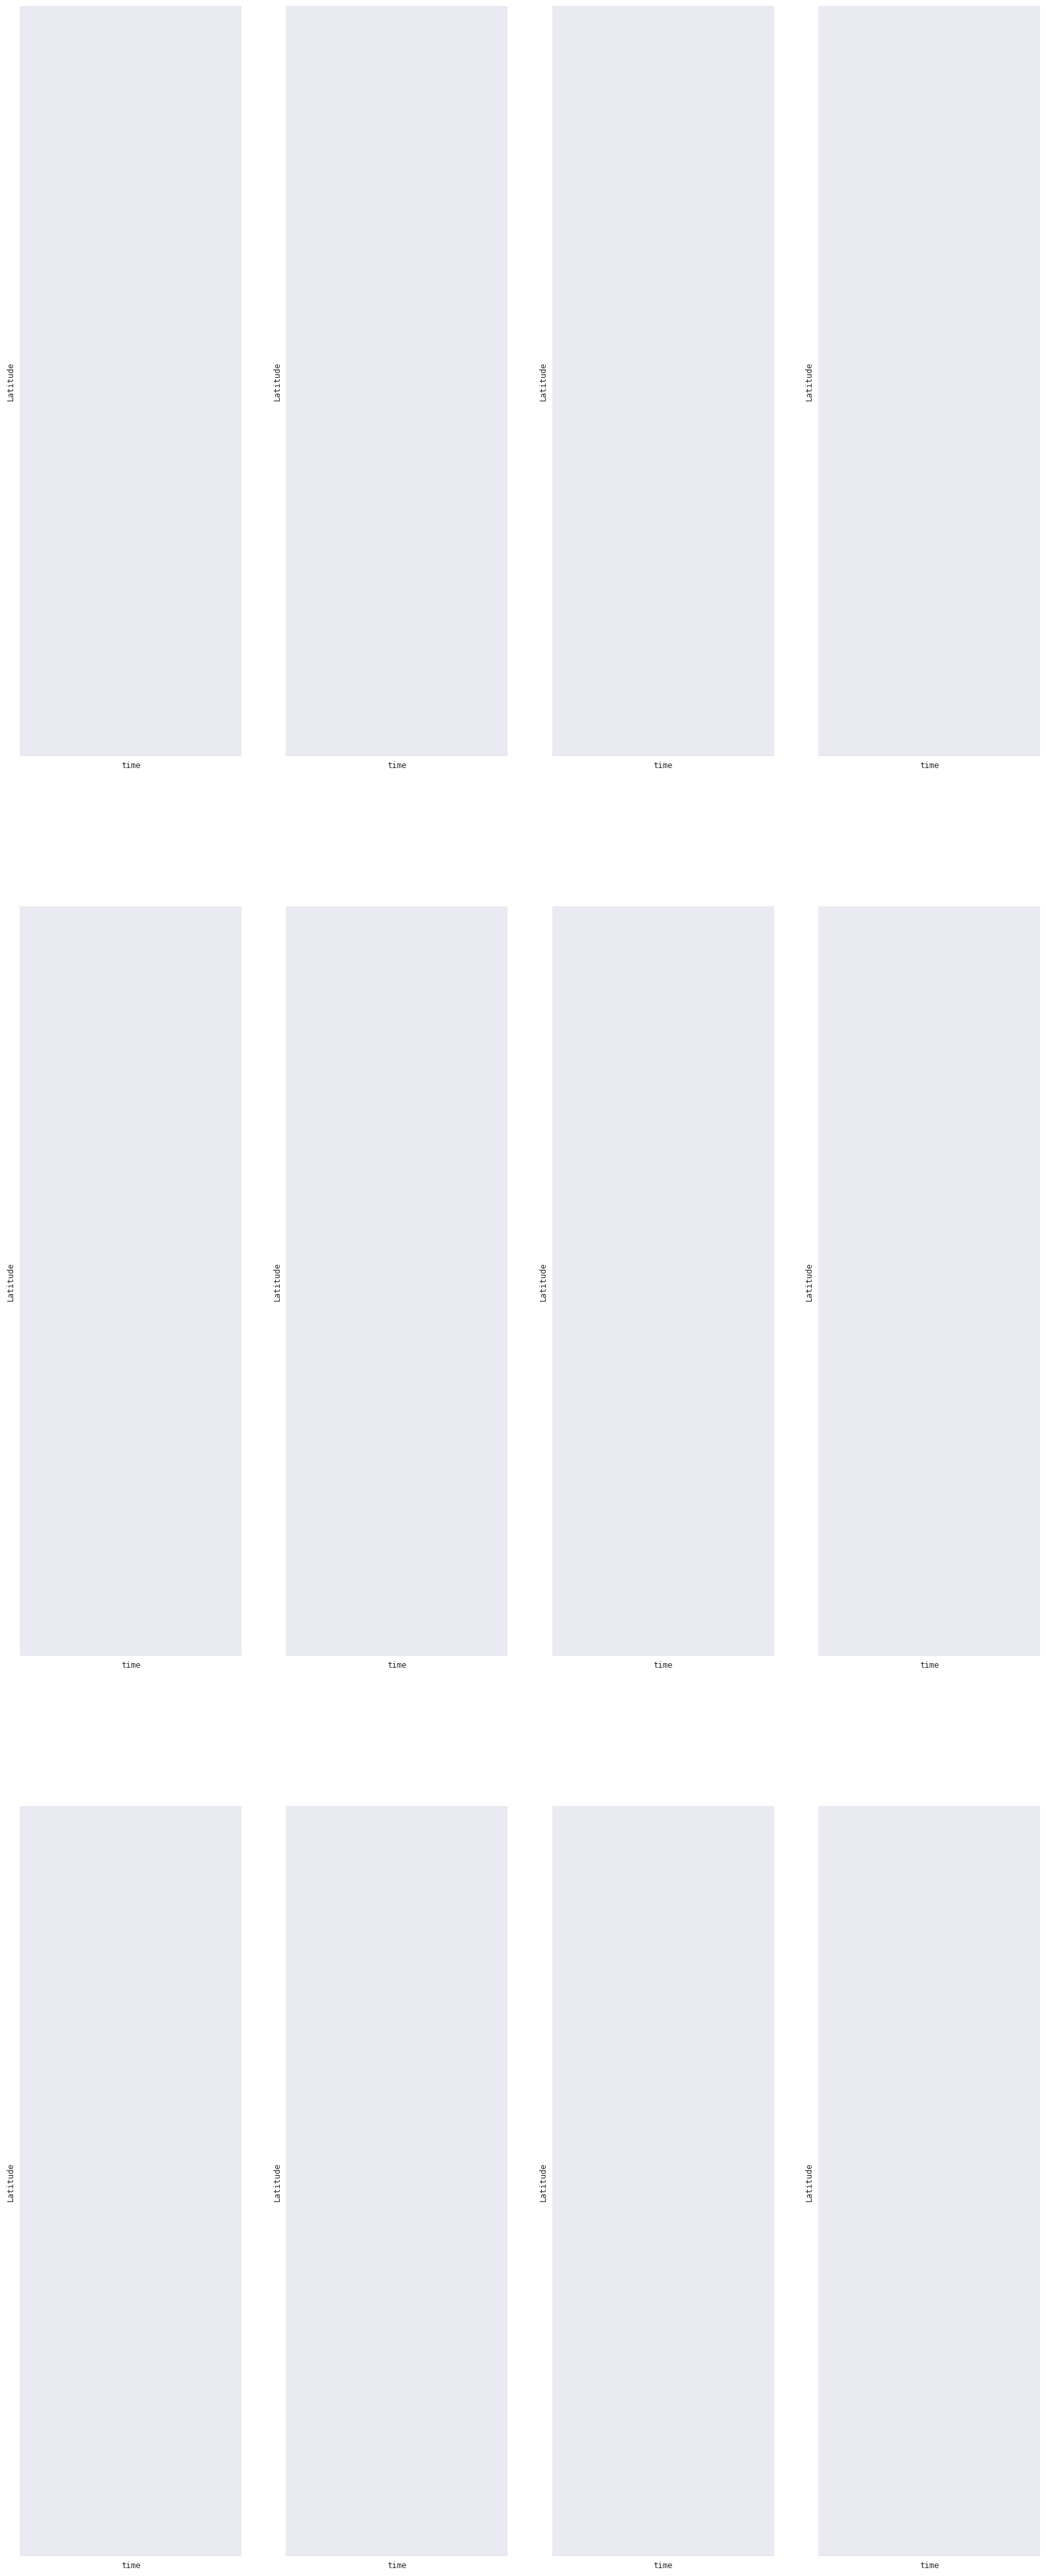

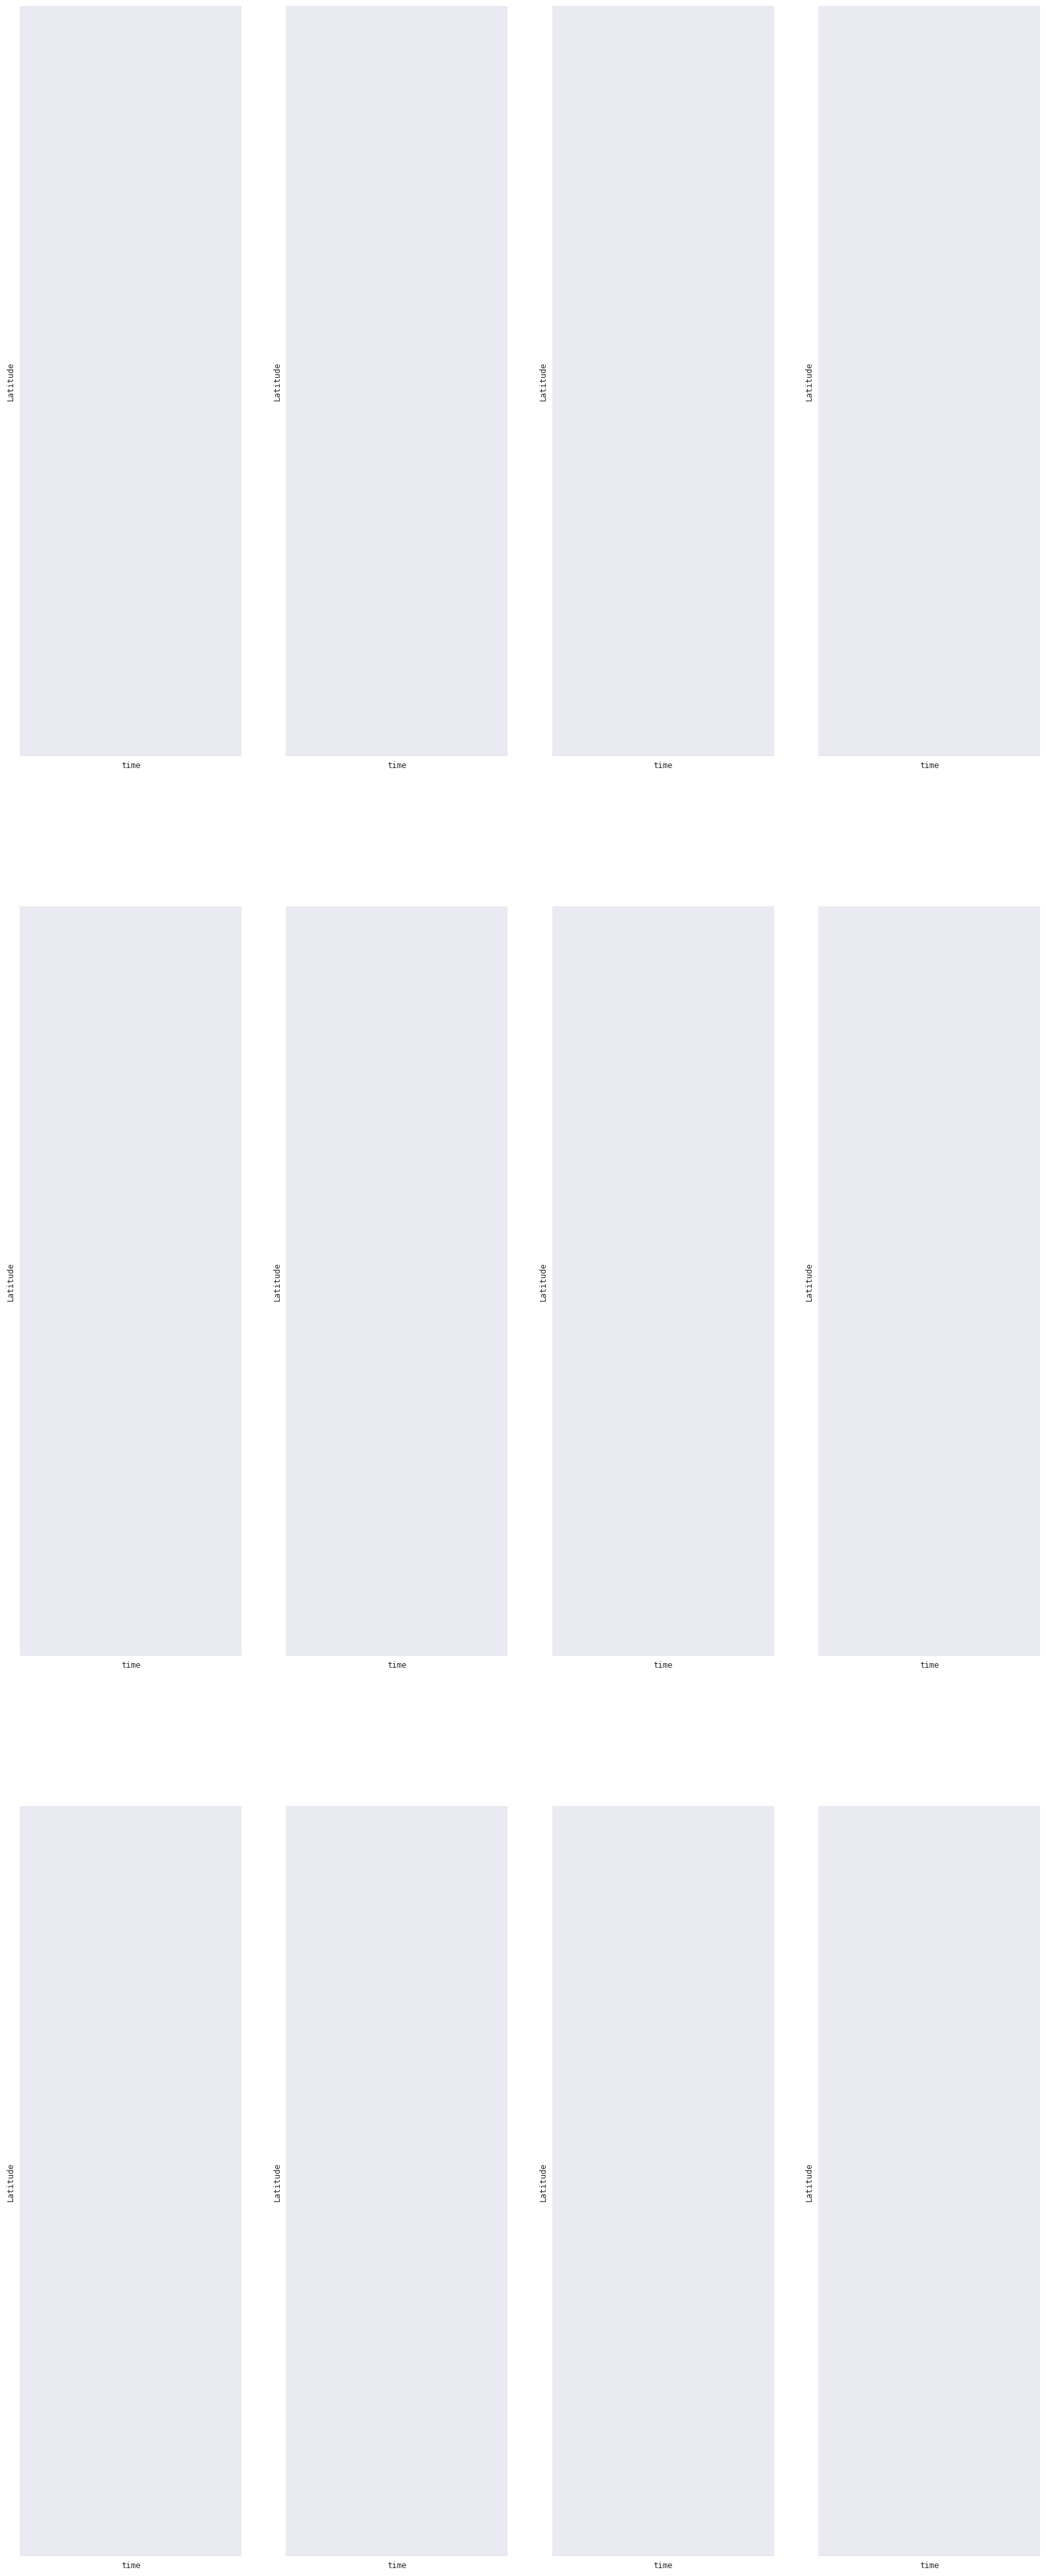

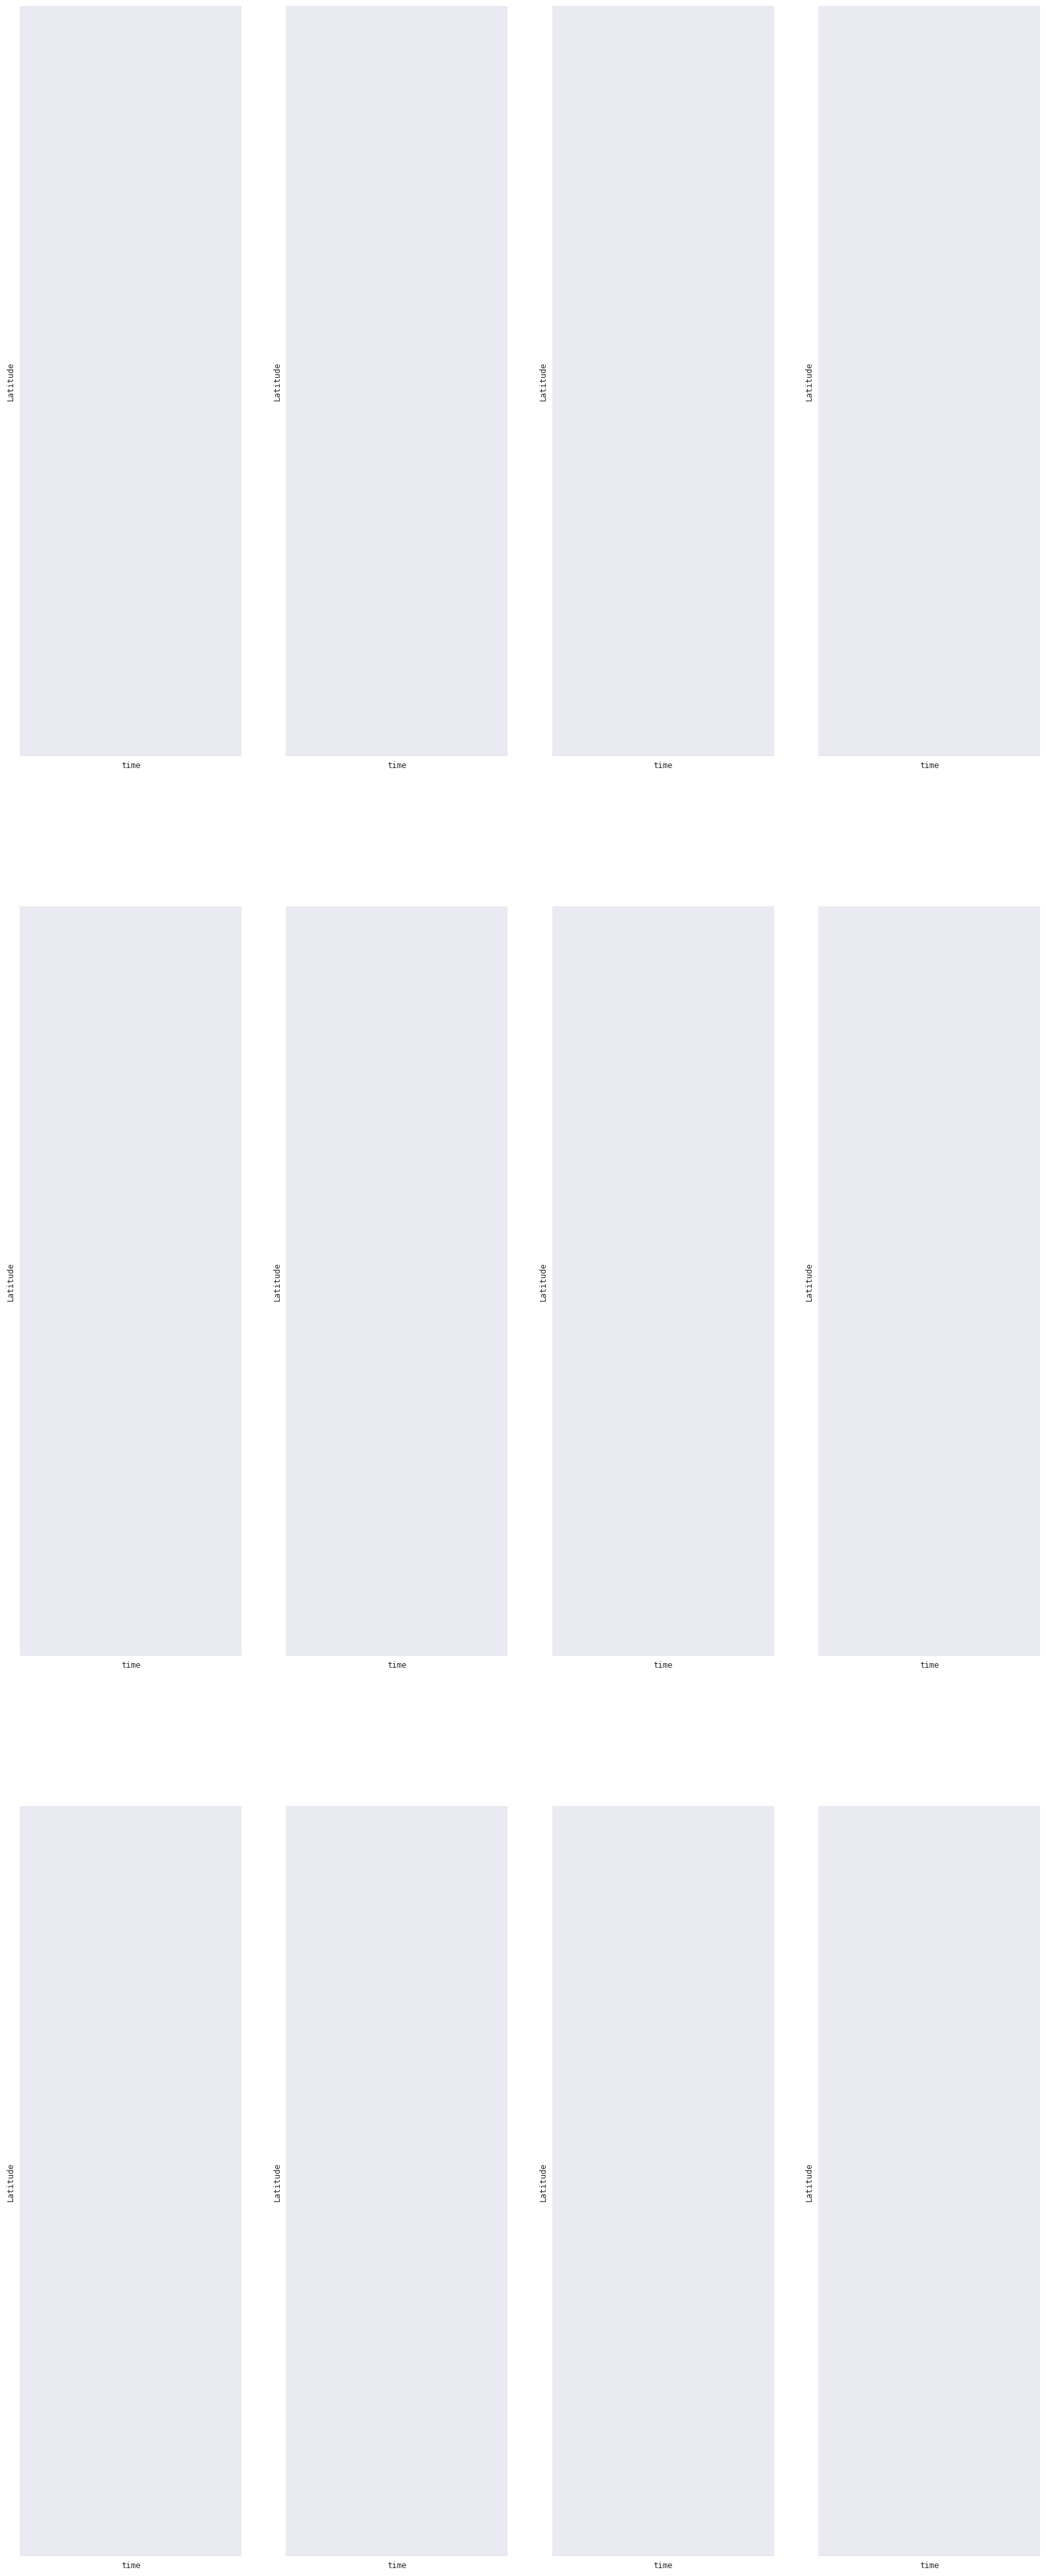

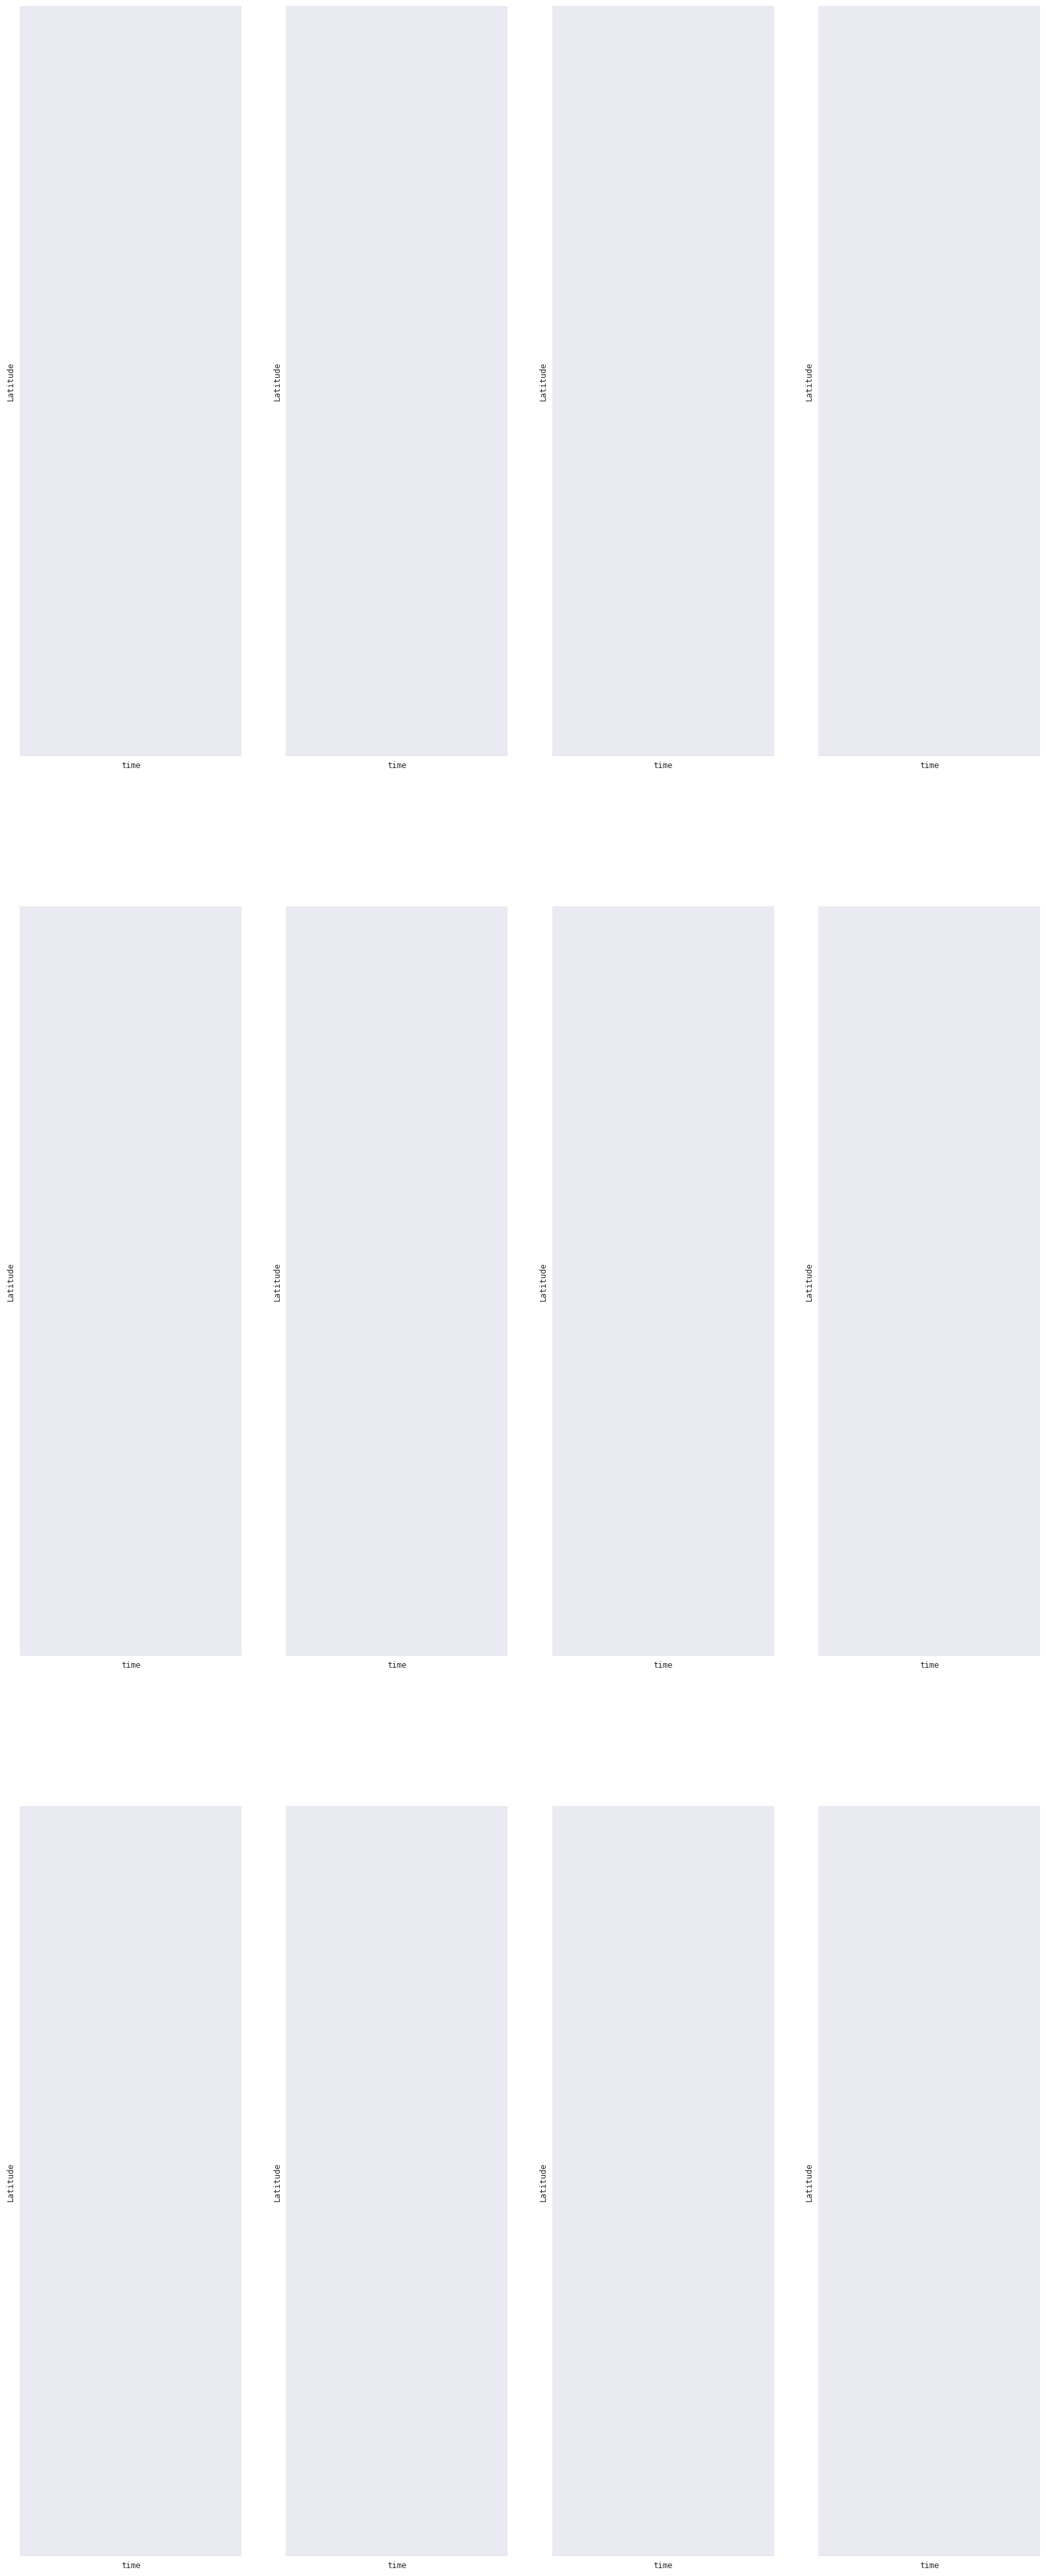

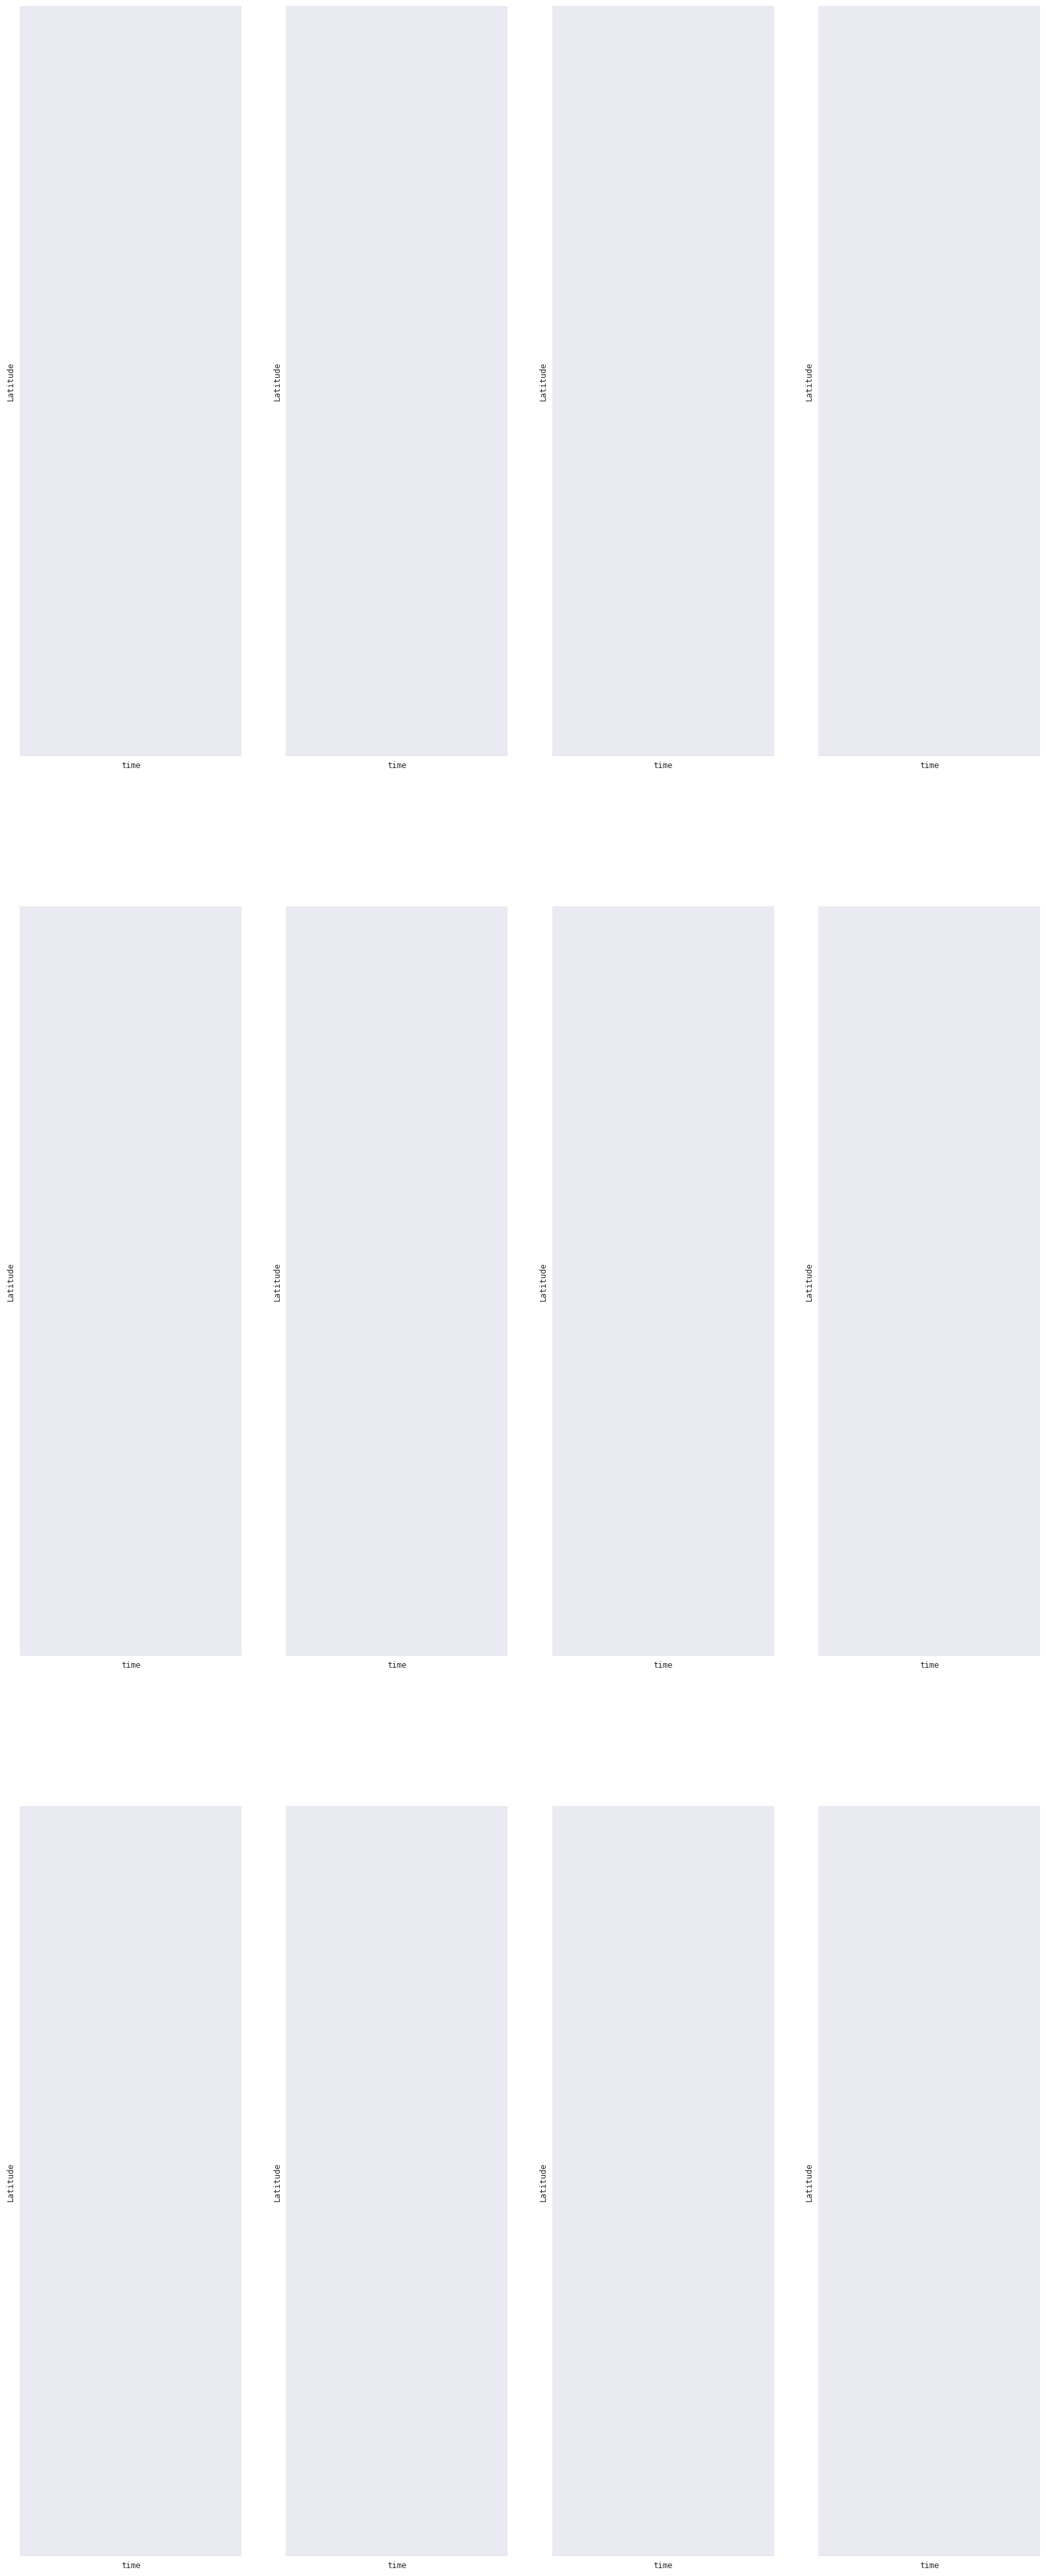

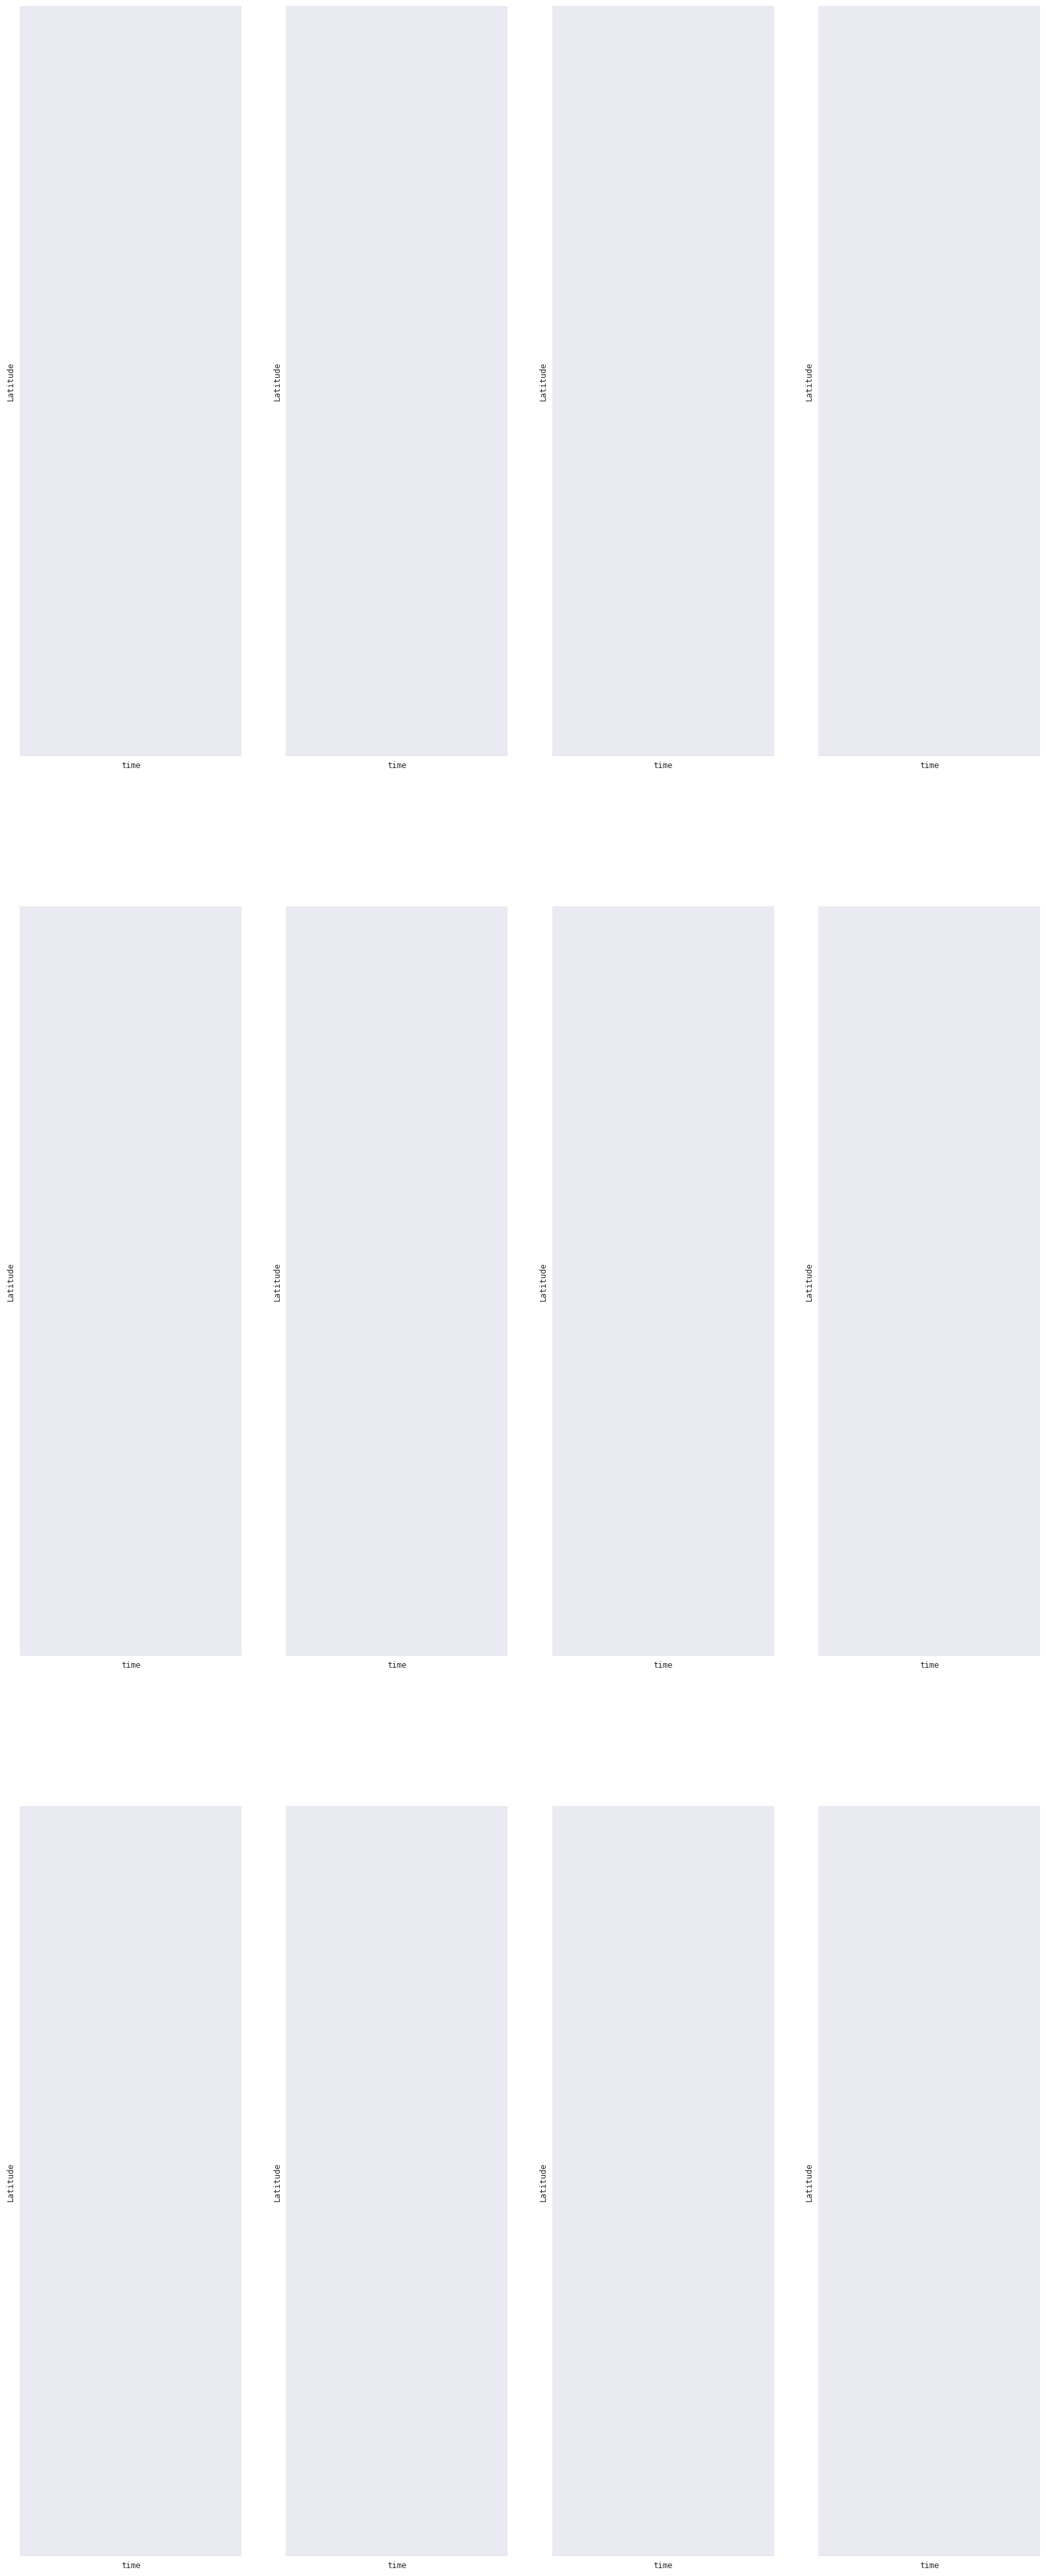

In [8]:
#for a in raw_5_min_data[['Freeway #', 'Direction']].drop_duplicates().itertuples():
#    keyval_dict = {"District": 11, "Freeway #": a[0],  "Lane Type": 'ML', "Direction": a[1]} 
#    freeway_redux = reduce_data_by_dict(raw_5_min_data, keyval_dict)

#    meta_dict= {"District": 11, "Fwy": a[0],  "Dir": a[1]}
#    meta_redux = reduce_data_by_dict(meta, meta_dict)

#    plot_freeway_heatmap(freeway_redux, meta_redux)